In [2]:
# Allows imported code to be updated without the need of running the import statement after each update
%load_ext autoreload
%autoreload 2

In [3]:
import os
import calendar
import numpy as np
import pandas as pd
import datetime as dt
from time import time
from copy import deepcopy
from pprint import pprint
from joblib import load, dump
from collections import OrderedDict
import matplotlib.pylab as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.cluster import KMeans

In [4]:
showings = load('../data/showings_extra_feature.joblib')
showings.replace(np.inf, 0, inplace=True)
genres = load('../data/genres.joblib')

In [5]:
showings.head()

arr_nr  std_movienr                    full_title            showtime  \
0   21419  BVI20160417    Vaiana 2D (norske stemmer) 2017-12-14 11:30:00   
1   22345  UIP20170704  Mamma Mia: Here We Go Again! 2018-07-19 20:00:00   
2   26179  BVI20190484                       Frost 2 2019-12-25 16:30:00   
3   22731  UIP20170704  Mamma Mia: Here We Go Again! 2018-07-21 19:45:00   
4   26178  BVI20190484                       Frost 2 2019-12-14 16:00:00   

   sold   room  seats  seats_b  coverage  location  ...       min_cos  \
0   140  16302  135.0    132.0       1.0       163  ... -1.000000e+00   
1   263  16351  259.0    259.0       1.0       163  ...  1.000000e+00   
2   263  16351  259.0    259.0       1.0       163  ... -1.000000e+00   
3   262  16351  259.0    259.0       1.0       163  ... -1.836970e-16   
4   261  16351  259.0    259.0       1.0       163  ...  1.000000e+00   

        min_sin sec_cos sec_sin is_holiday days_since_release  tfidf_overview  \
0  1.224647e-16     1.0     0.0      False                150        5.025035   
1  0.000000e+00     1.0     0.0      False                 10        4.575531   
2  1.224647e-16     1.0     0.0       True                150        7.121572   
3 -1.000000e+00     1.0     0.0      False                 12        4.575531   
4  0.000000e+00     1.0     0.0      False                150        7.121572   

  tfidf_full_title  tfidf_stripped_title  tfidf_tmdb_title  
0         1.907788              1.000000          1.414010  
1         2.448553              2.448529          2.448752  
2         1.000000              1.000000          1.414211  
3         2.448553              2.448529          2.448752  
4         1.000000              1.000000          1.414211  

[5 rows x 67 columns]

# Coverage per hour

In [6]:
%%time
stats = dict()
for i in range(24):
    if i < 10:
        stats['0' + str(i) + ':00-0' + str(i) + ':59'] = showings.loc[showings.showtime.dt.strftime('%H:%M:%S').between('0' + str(i) + ':00:00', '0' + str(i) + ':59:59'), 'coverage']
    else:
        stats[str(i) + ':00-' + str(i) + ':59'] = showings.loc[showings.showtime.dt.strftime('%H:%M:%S').between(str(i) + ':00:00', str(i) + ':59:59'), 'coverage']

Wall time: 1min 50s


In [7]:
stats_avg = dict()
for i in stats:
    stats_avg[i] = stats[i].mean()

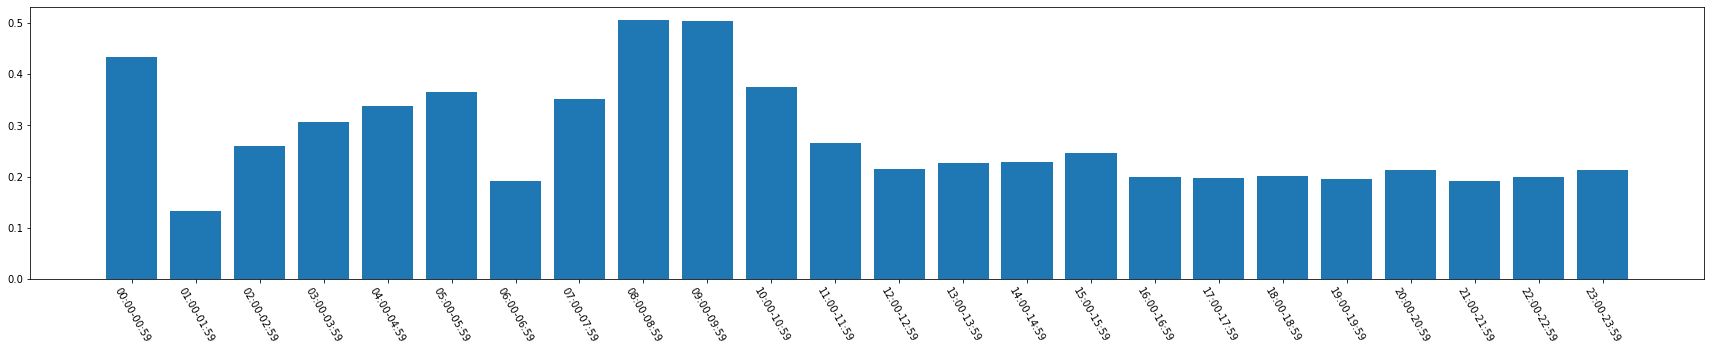

In [8]:
f, ax = plt.subplots(figsize=(30,5))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=300)

plt.show()

In [9]:
stats_num = dict()
for i in stats:
    stats_num[i] = stats[i].count()

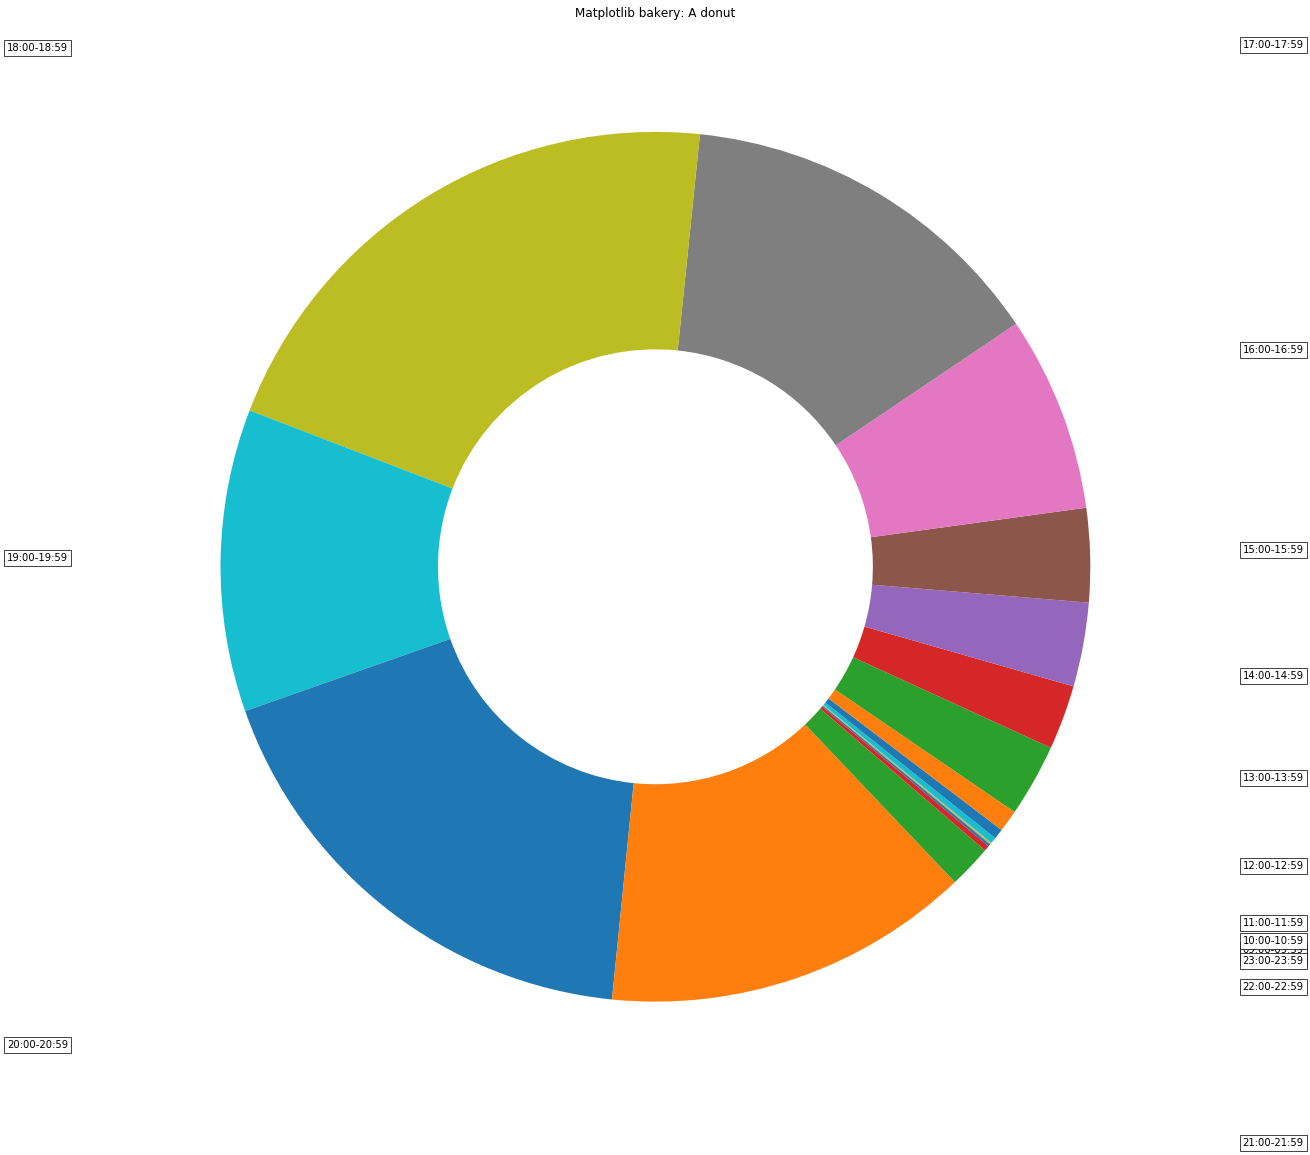

In [10]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(aspect="equal"))

data = [stats_num[i] for i in stats_num]
times = [i for i in stats_num]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-", color='white'),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(times[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Matplotlib bakery: A donut")

plt.show()

## Coverage by day of week

In [46]:
%%time
stats = dict()
for i in range(7):
    stats[calendar.day_name[i]] = showings.loc[showings.showtime.dt.dayofweek == i, 'coverage']

Wall time: 393 ms


In [47]:
stats_avg = dict()
for i in stats:
    stats_avg[i] = stats[i].mean()

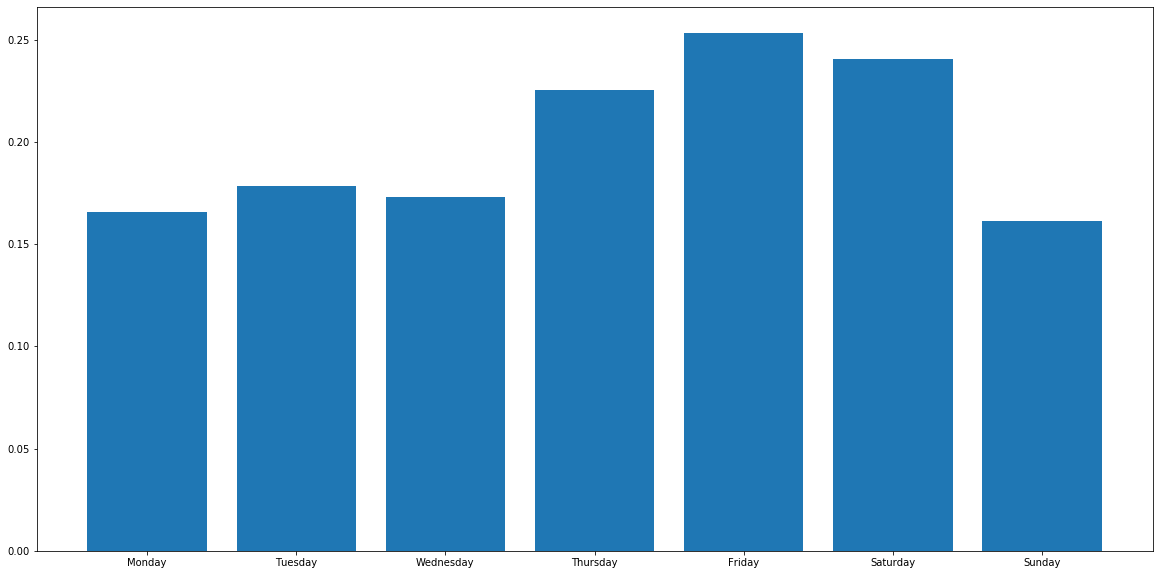

In [49]:
f, ax = plt.subplots(figsize=(20,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=0)

plt.show()

In [51]:
stats_num = dict()
for i in stats:
    stats_num[i] = stats[i].count()

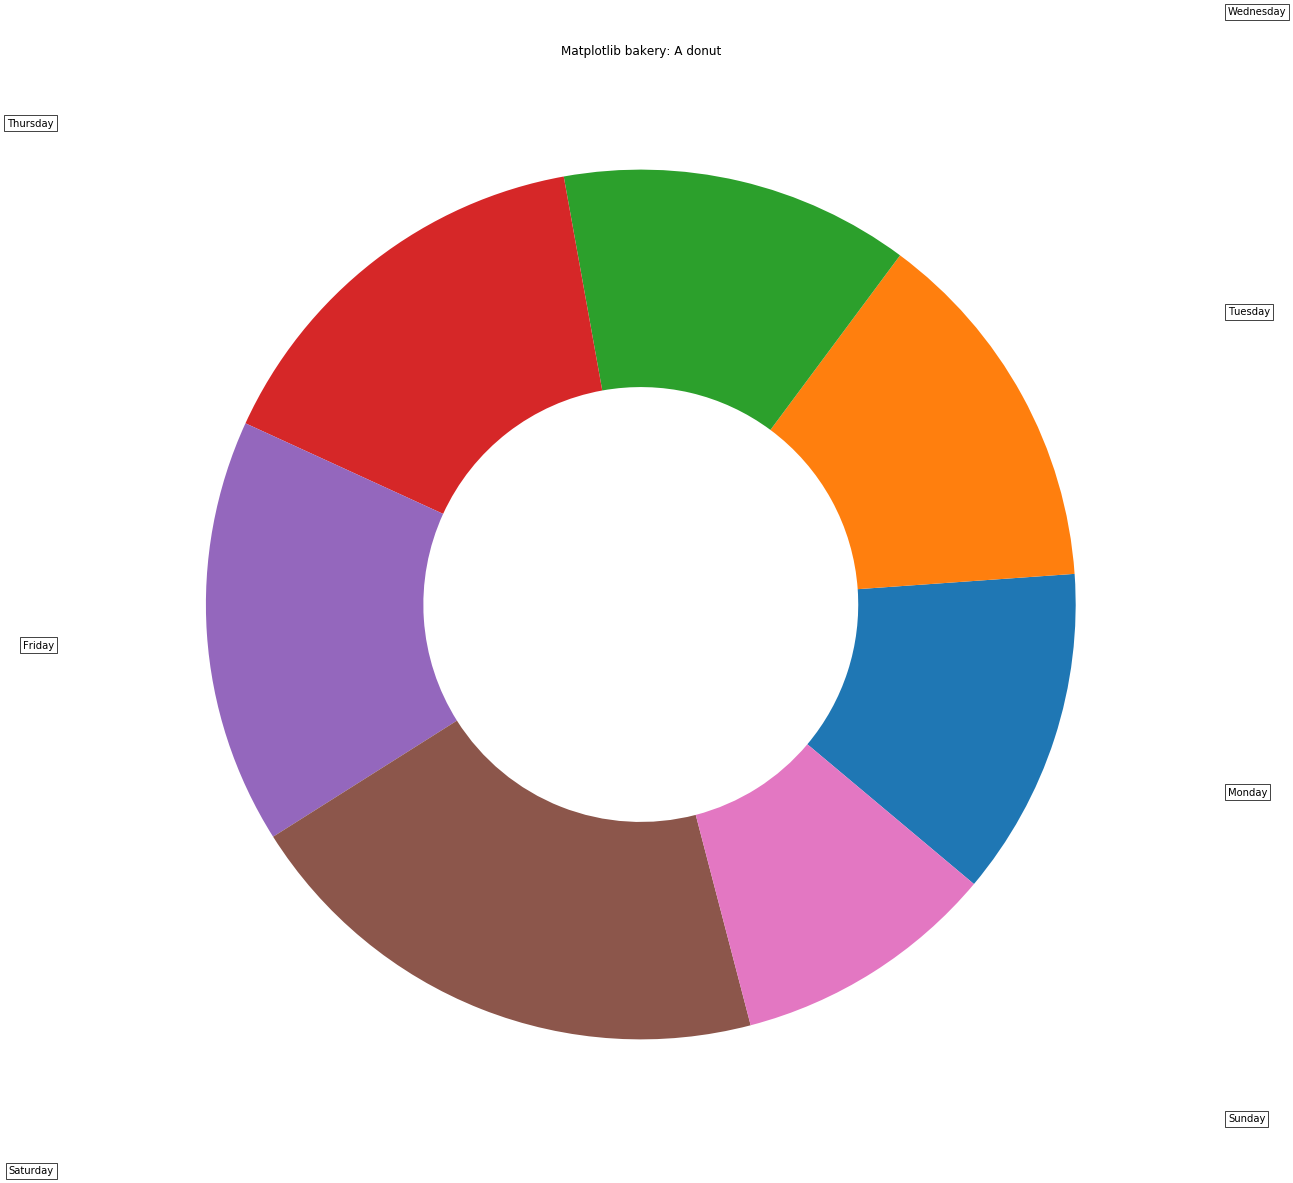

In [52]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(aspect="equal"))

data = [stats_num[i] for i in stats_num]
days = [i for i in stats_num]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-", color='white'),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(days[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Matplotlib bakery: A donut")

plt.show()

## Coverage by genre

In [5]:
genre = set()
all_genres = showings.tmdb_genre_ids.tolist()
for i in all_genres:
    genre.update(i)

In [6]:
%%time
stats = dict()
for i in genre:
    stats[genres[i]] = showings.loc[showings.tmdb_genre_ids.apply(lambda numbers: i in numbers), 'coverage']

Wall time: 2.92 s


In [7]:
stats_avg = dict()
for i in stats:
    stats_avg[i] = stats[i].mean()

In [8]:
stats_cnt = dict()
for i in stats:
    stats_cnt[i] = stats[i].count()

In [9]:
f, ax = plt.subplots(figsize=(20,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=300)

for i, (j, v) in enumerate(stats_cnt.items()):
    ax.text(i - .4, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

In [10]:
stats_num = dict()
for i in stats:
    stats_num[i] = stats[i].count()

In [11]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(aspect="equal"))

data = [stats_num[i] for i in stats_num]
genres = [i for i in stats_num]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-", color='white'),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(genres[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)


plt.show()

## Coverage by TMDb score

In [12]:
scores = showings.tmdb_vote_average.unique()
scores.sort()

In [13]:
%%time
stats = dict()
for i in scores:
    stats[i] = showings.loc[showings.tmdb_vote_average == i, 'coverage']

Wall time: 111 ms


In [14]:
stats_avg = dict()
for i in stats:
    stats_avg[i] = stats[i].mean()

In [17]:
stats_cnt = dict()
for i in stats:
    stats_cnt[i] = stats[i].count()

In [21]:
f, ax = plt.subplots(figsize=(20,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=270)

for i, (j, v) in enumerate(stats_cnt.items()):
    ax.text(i - .4, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

In [103]:
stats_num = dict()
for i in stats:
    stats_num[i] = stats[i].count()

In [137]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))

data = [stats_num[i] for i in stats_num]
scores_avg = [i for i in stats_num]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-", color='white'),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(scores_avg[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)


plt.show()

## Coverage by TMDb popularity

In [22]:
popularity = list(set(showings.tmdb_popularity.unique().round()))
popularity.sort()

In [23]:
%%time
stats = dict()
for i in popularity:
    stats[i] = showings.loc[showings.tmdb_popularity.round() == i, 'coverage']

Wall time: 2.27 s


In [24]:
stats_avg = dict()
for i in stats:
    stats_avg[i] = stats[i].mean()

In [25]:
stats_cnt = dict()
for i in stats:
    stats_cnt[i] = stats[i].count()

In [27]:
f, ax = plt.subplots(figsize=(20,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=270)

for i, (j, v) in enumerate(stats_cnt.items()):
    ax.text(i - .4, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

In [103]:
stats_num = dict()
for i in stats:
    stats_num[i] = stats[i].count()

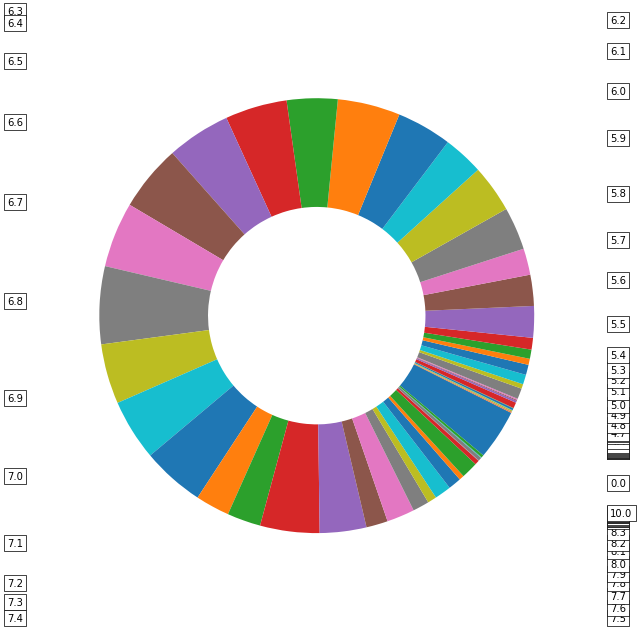

In [136]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))

data = [stats_num[i] for i in stats_num]
scores_avg = [i for i in stats_num]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-", color='white'),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(scores_avg[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)


plt.show()

# Stats per hour per day of week

In [177]:
%%time
stats = dict()
for i in range(7):
    temp = showings.loc[showings.showtime.dt.dayofweek == i, ('showtime', 'coverage')]
    stats[calendar.day_name[i]] = dict()
    for j in range(24):
        if j < 10:
            stats[calendar.day_name[i]]['0' + str(j) + ':00-0' + str(j) + ':59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between('0' + str(j) + ':00:00', '0' + str(j) + ':59:59'),
                'coverage']
        else:
            stats[calendar.day_name[i]][str(j) + ':00-' + str(j) + ':59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between(str(j) + ':00:00', str(j) + ':59:59'),
                'coverage']

Wall time: 1min 49s


In [180]:
stats_avg = dict()
for i in stats:
    stats_avg[i] = dict()
    for j in stats[i]:
        stats_avg[i][j] = stats[i][j].mean()

In [182]:
stats_cnt = dict()
for i in stats:
    stats_cnt[i] = dict()
    for j in stats[i]:
        stats_cnt[i][j] = stats[i][j].count()

In [199]:
stats_nil = dict()
for i in stats:
    stats_nil[i] = dict()
    for j in stats[i]:
        stats_nil[i][j] = stats[i][j].where(stats[i][j] == 0).count()

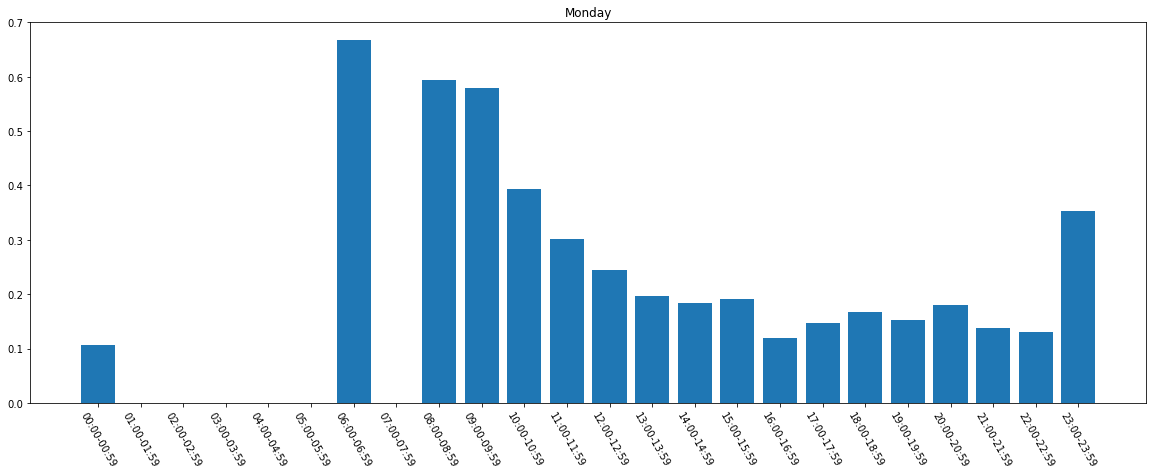

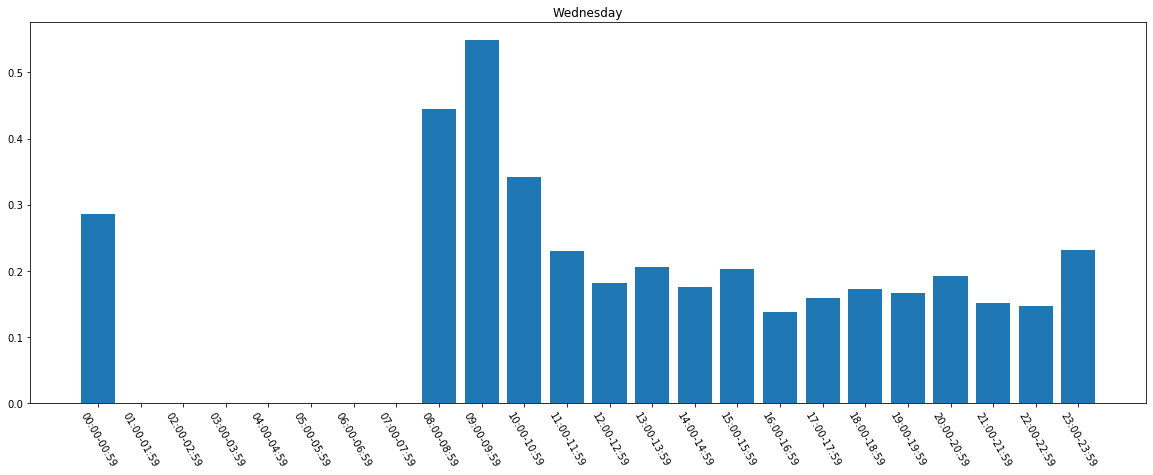

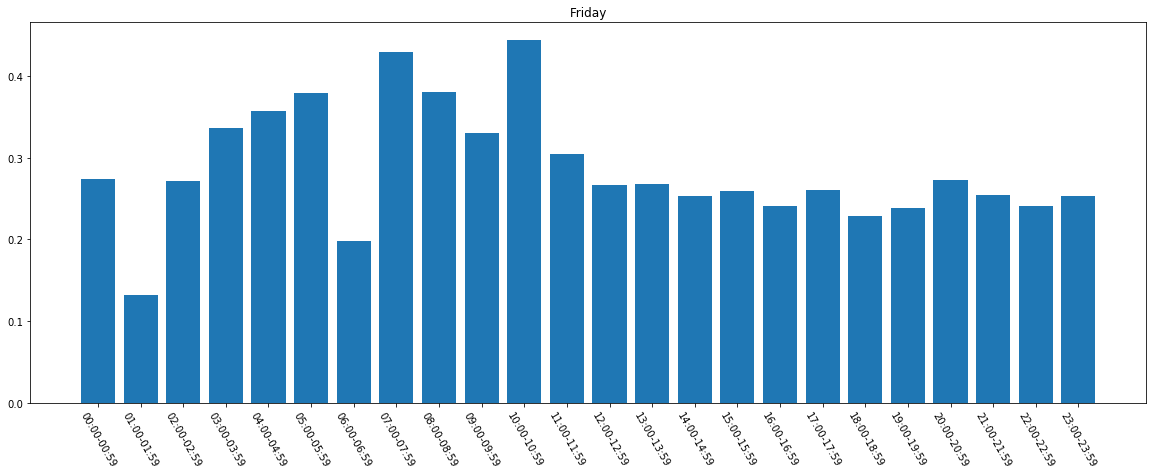

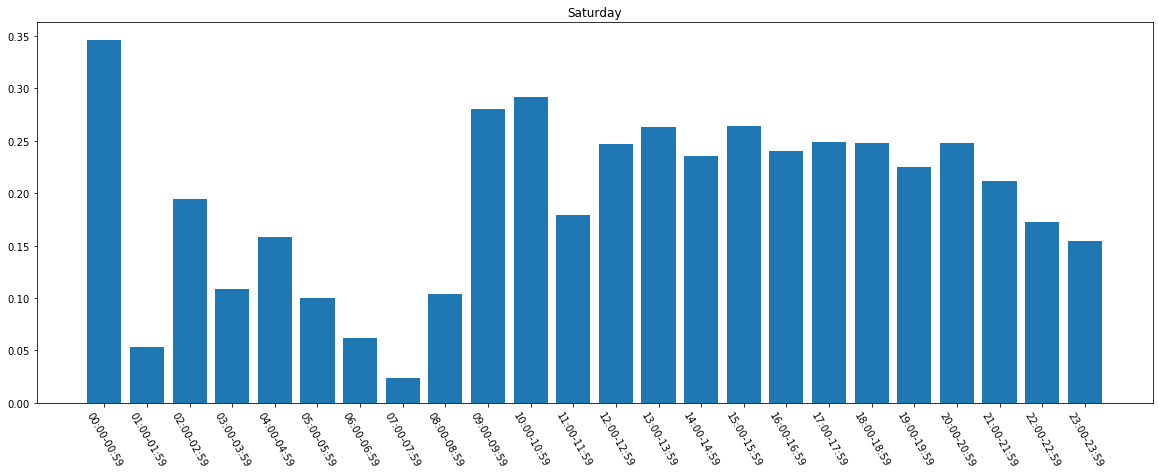

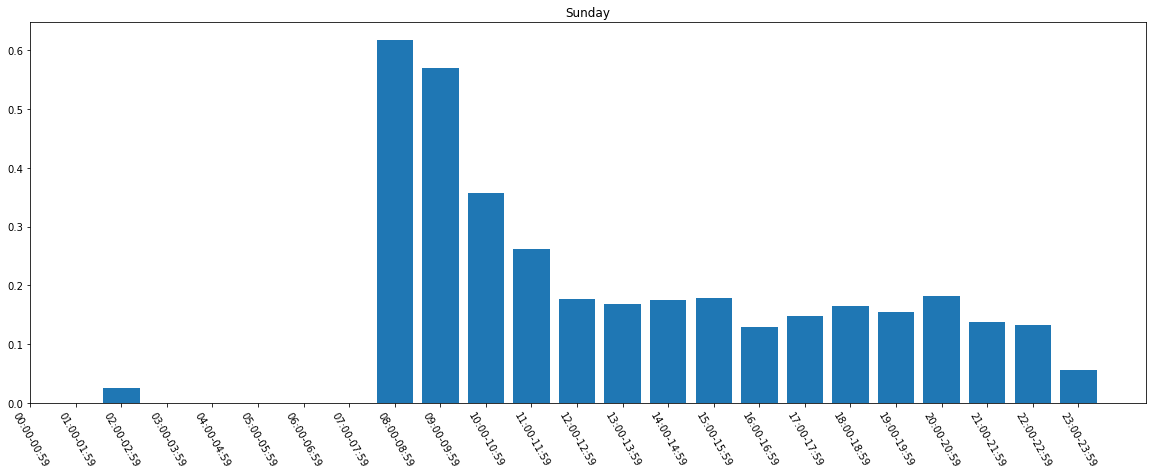

In [181]:
for i in stats_avg:
    f, ax = plt.subplots(figsize=(20,7))
    
    plt.bar(range(len(stats_avg[i])), list(stats_avg[i].values()), align='center')
    plt.xticks(range(len(stats_avg[i])), list(stats_avg[i].keys()), rotation=300)
    plt.title(i)

    plt.show()

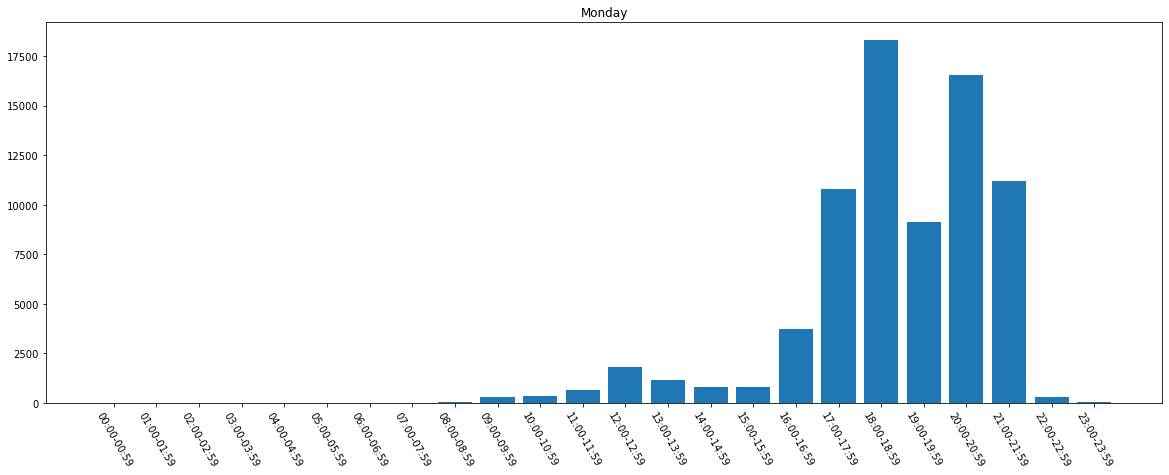

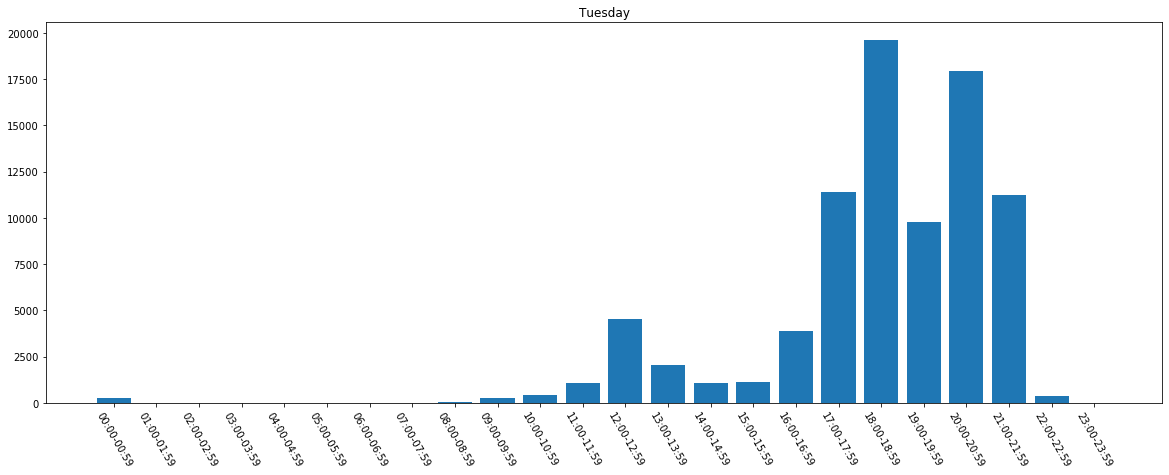

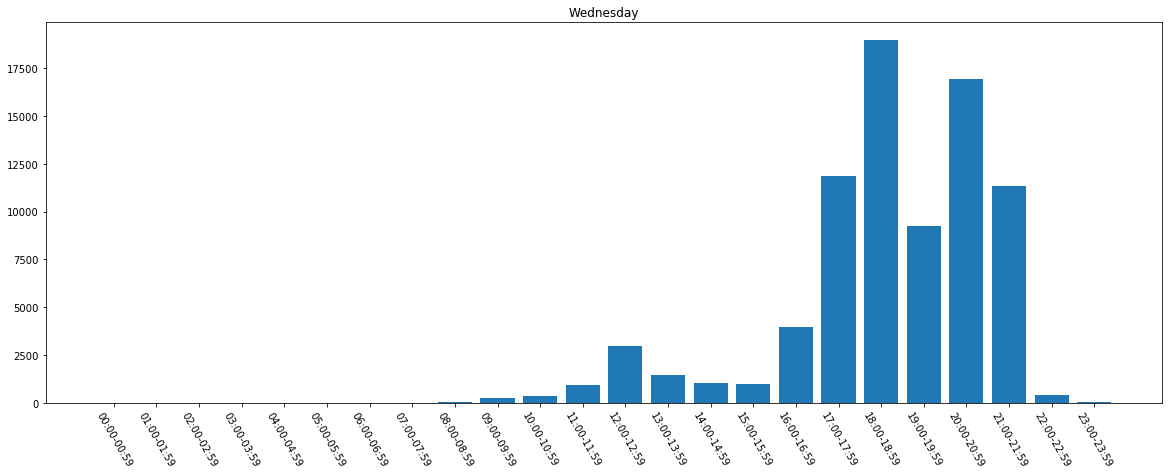

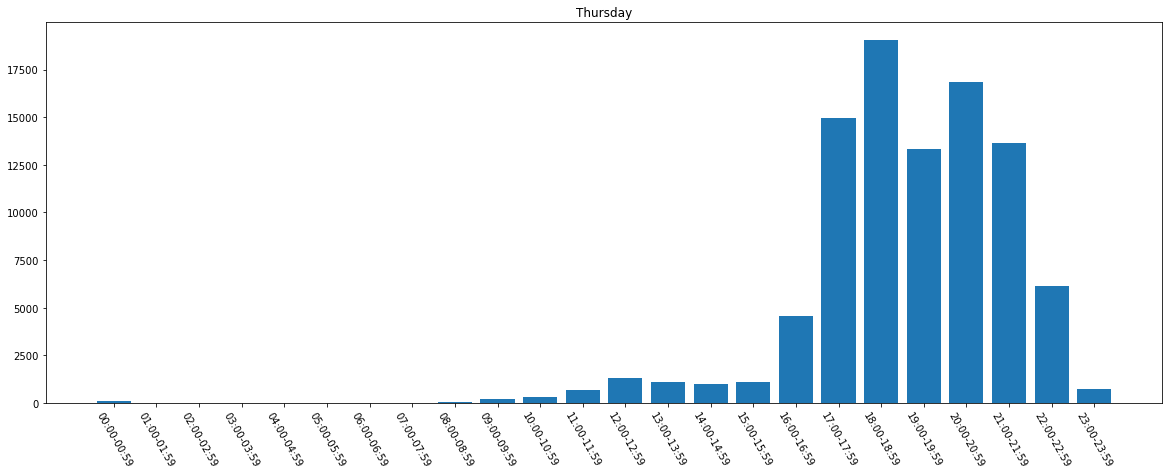

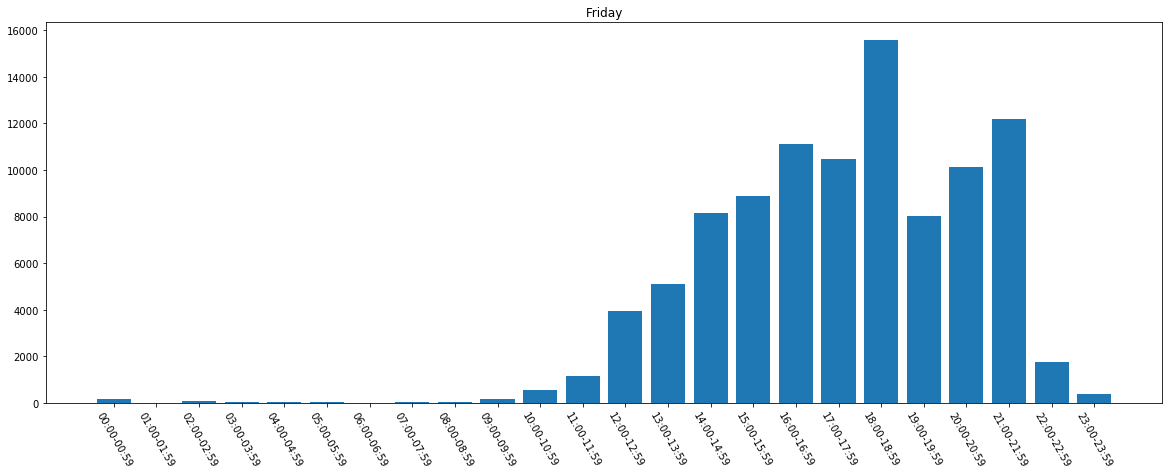

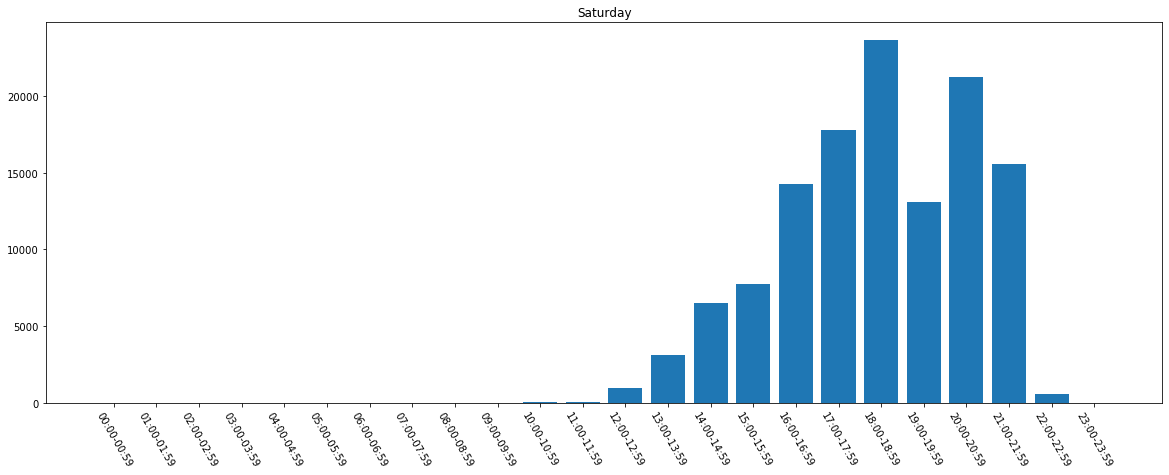

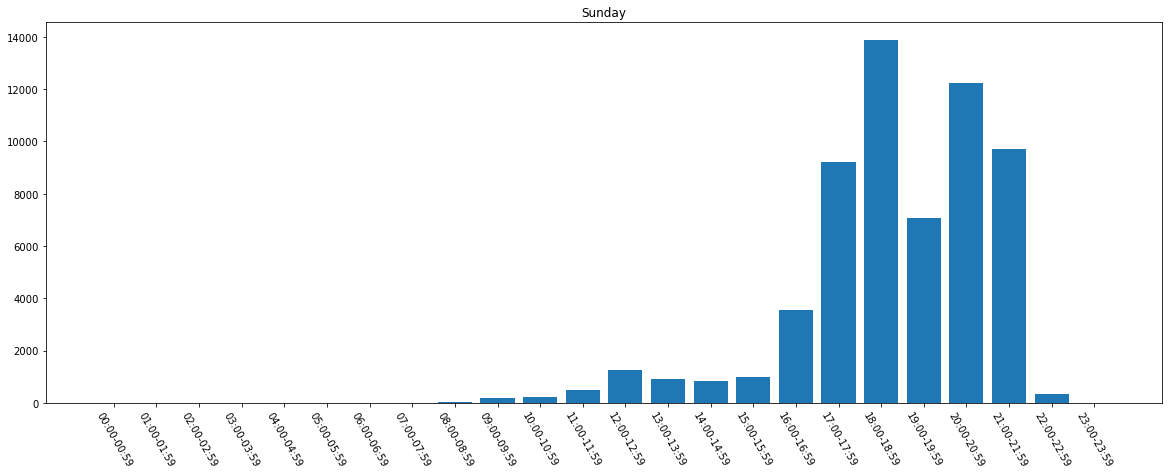

In [183]:
for i in stats_cnt:
    f, ax = plt.subplots(figsize=(20,7))
    
    plt.bar(range(len(stats_cnt[i])), list(stats_cnt[i].values()), align='center')
    plt.xticks(range(len(stats_cnt[i])), list(stats_cnt[i].keys()), rotation=300)
    plt.title(i)

    plt.show()

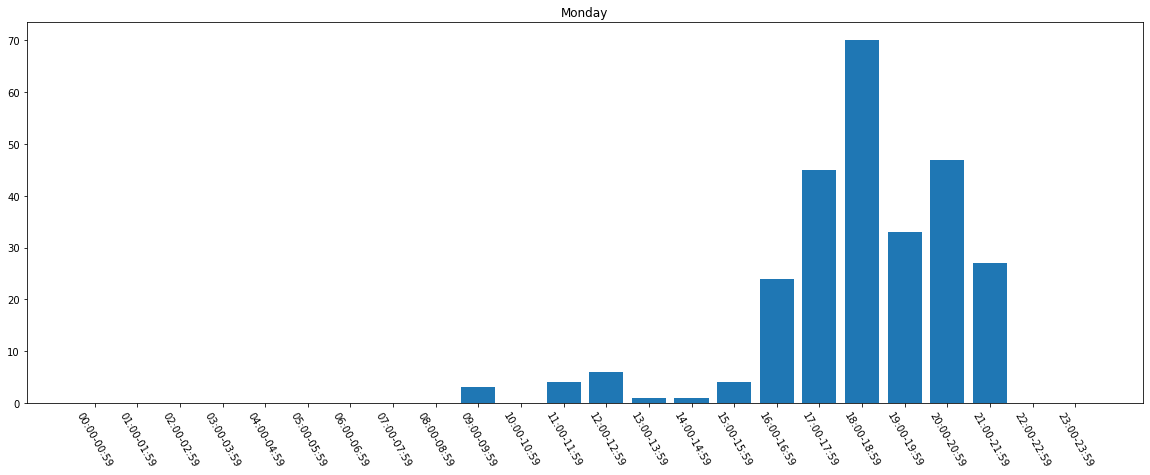

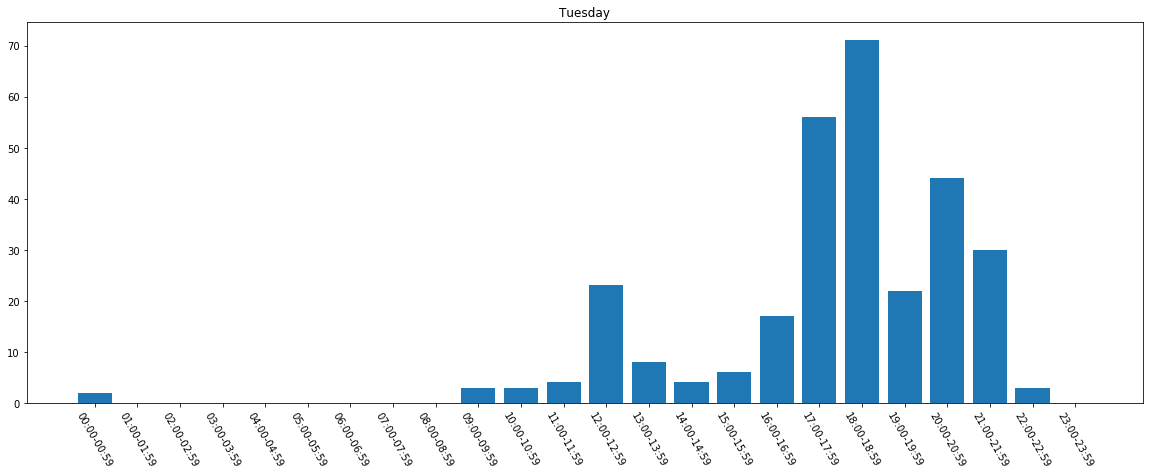

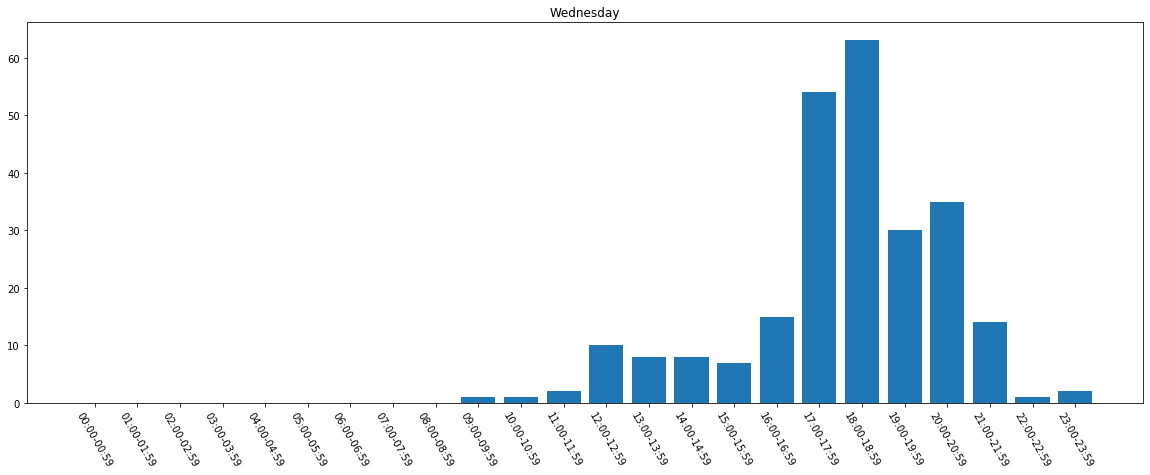

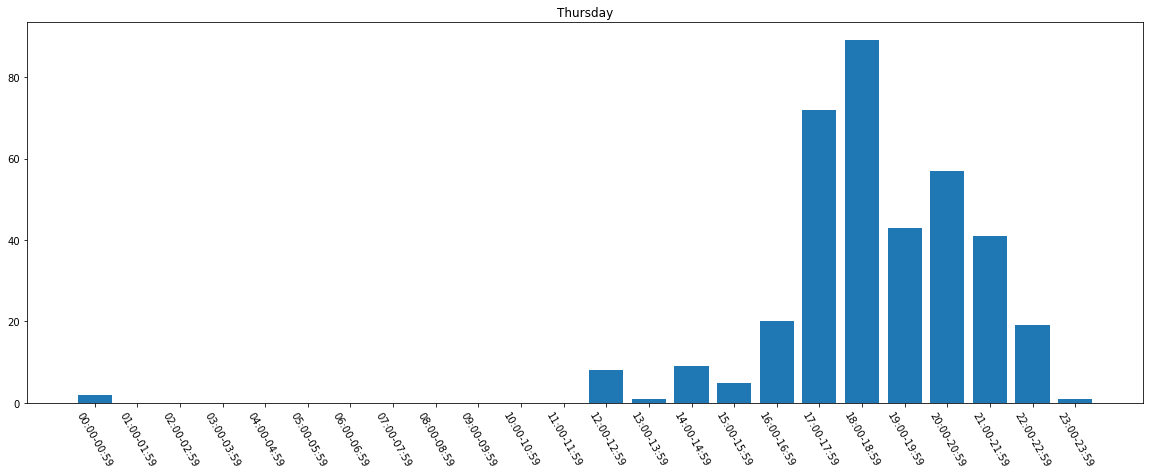

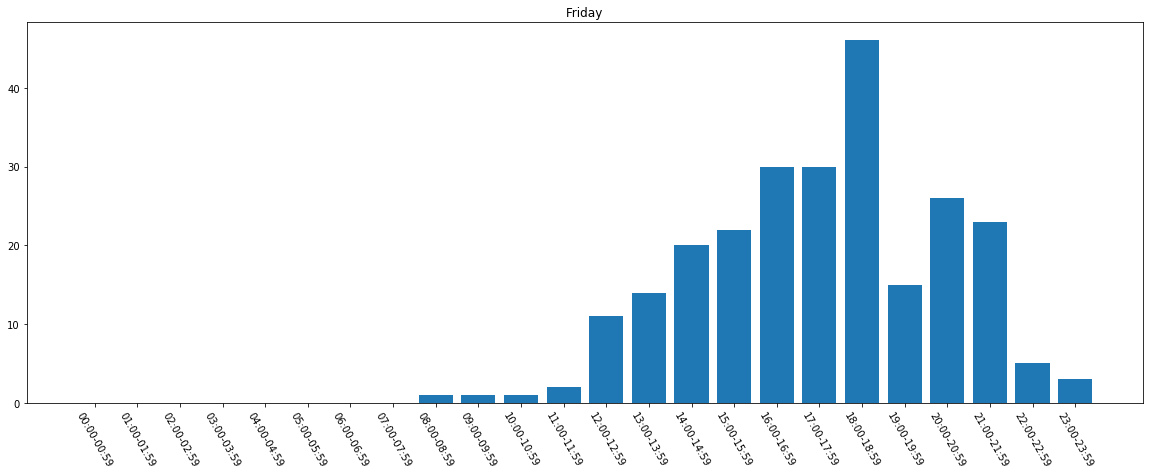

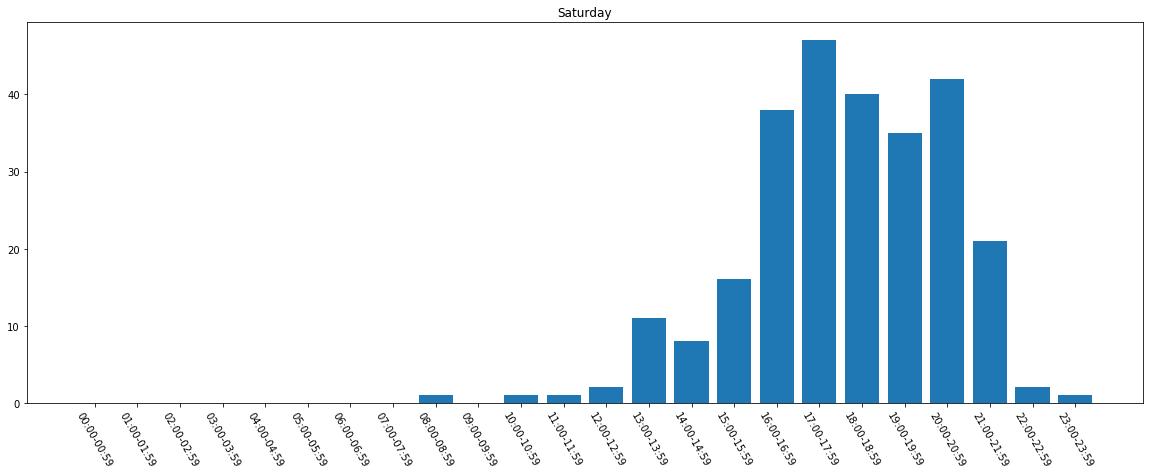

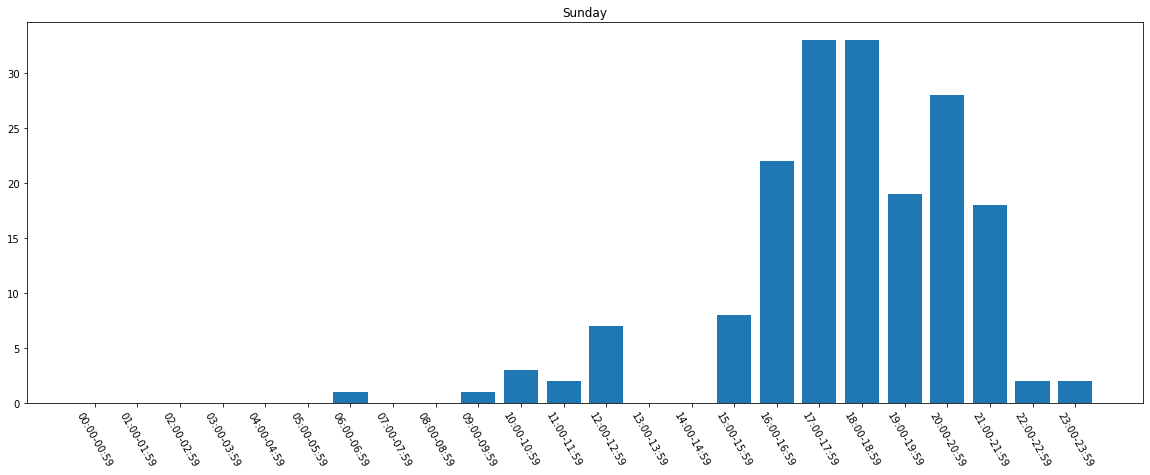

In [200]:
for i in stats_nil:
    f, ax = plt.subplots(figsize=(20,7))
    
    plt.bar(range(len(stats_nil[i])), list(stats_nil[i].values()), align='center')
    plt.xticks(range(len(stats_nil[i])), list(stats_nil[i].keys()), rotation=300)
    plt.title(i)

    plt.show()

# A more logical way of grouping the times

In [302]:
%%time
stats_outlier = dict()
stats_prime = dict()
stats_early = dict()
for i in range(7):
    temp = showings.loc[showings.showtime.dt.dayofweek == i, ('showtime', 'coverage')]
    stats_outlier[calendar.day_name[i]] = dict()
    stats_prime[calendar.day_name[i]] = dict()
    stats_early[calendar.day_name[i]] = dict()
    for j in range(24):
        if j == 0:
            stats_outlier[calendar.day_name[i]]['23:00-08:59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between('23:00:00', '23:59:59')
                | temp.showtime.dt.strftime('%H:%M:%S').between('00:00:00', '08:59:59'),
                'coverage']
        elif j == 23 or j < 9: continue
        elif j < 10:
            stats_early[calendar.day_name[i]]['0' + str(j) + ':00-0' + str(j) + ':59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between('0' + str(j) + ':00:00', '0' + str(j) + ':59:59'),
                'coverage']
        elif j < 16:
            stats_early[calendar.day_name[i]][str(j) + ':00-' + str(j) + ':59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between(str(j) + ':00:00', str(j) + ':59:59'),
                'coverage']
        else:
            stats_prime[calendar.day_name[i]][str(j) + ':00-' + str(j) + ':59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between(str(j) + ':00:00', str(j) + ':59:59'),
                'coverage']

Wall time: 1min 15s


In [305]:
stats_prime_avg = dict()
for i in stats_prime:
    stats_prime_avg[i] = dict()
    for j in stats_prime[i]:
        stats_prime_avg[i][j] = stats_prime[i][j].mean()
        
stats_early_avg = dict()
for i in stats_early:
    stats_early_avg[i] = dict()
    for j in stats_early[i]:
        stats_early_avg[i][j] = stats_early[i][j].mean()

In [306]:
stats_prime_cnt = dict()
for i in stats_prime:
    stats_prime_cnt[i] = dict()
    for j in stats_prime[i]:
        stats_prime_cnt[i][j] = stats_prime[i][j].count()
        
stats_early_cnt = dict()
for i in stats_early:
    stats_early_cnt[i] = dict()
    for j in stats_early[i]:
        stats_early_cnt[i][j] = stats_early[i][j].count()

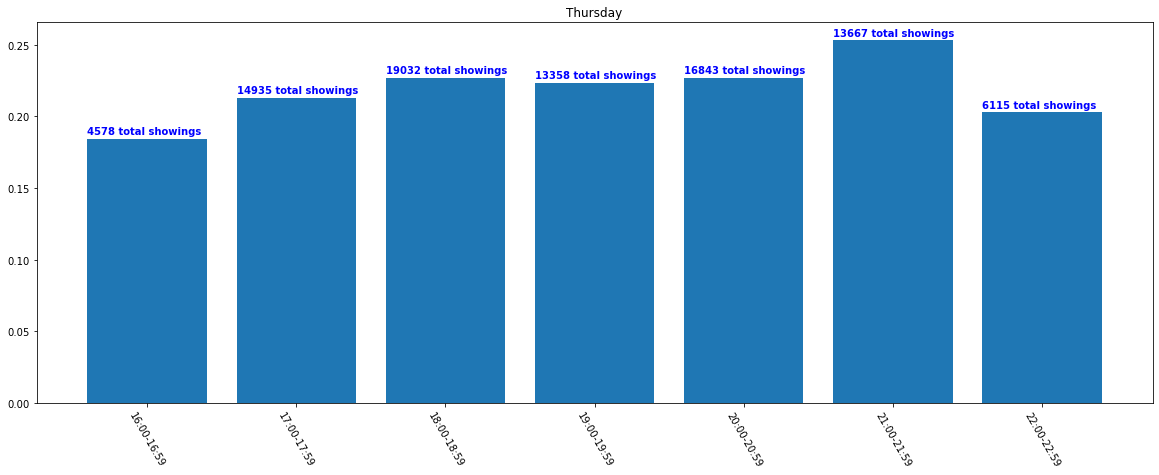

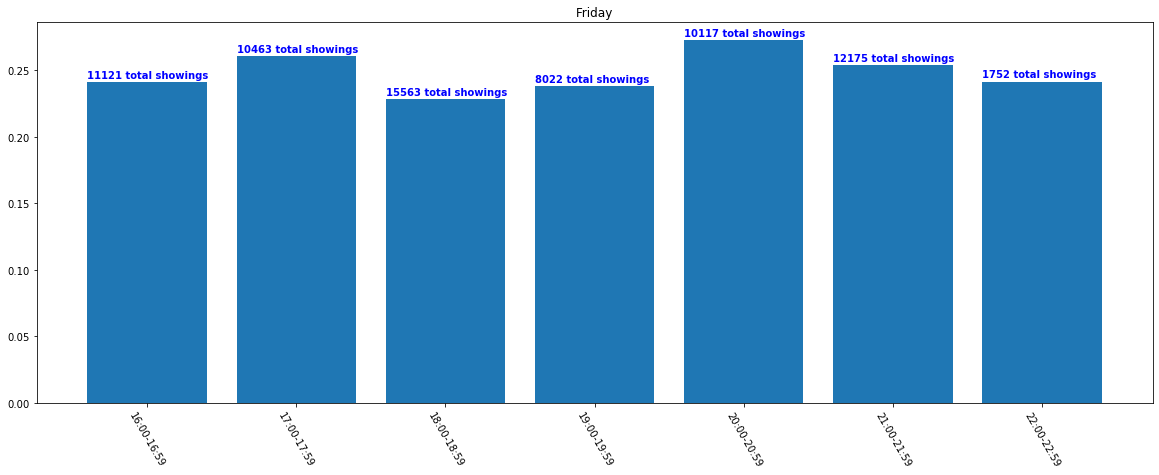

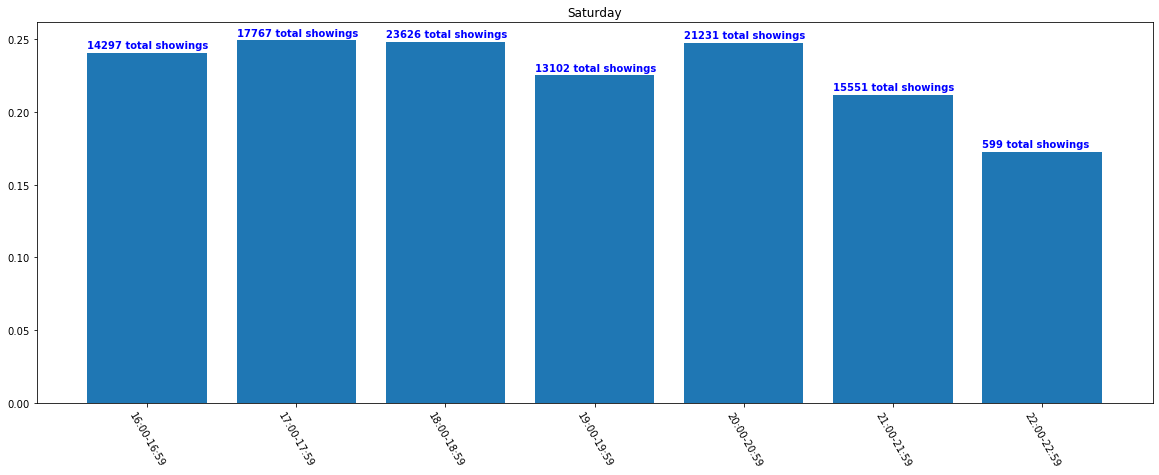

In [307]:
for i in stats_prime_avg:
    f, ax = plt.subplots(figsize=(20,7))
    
    plt.bar(range(len(stats_prime_avg[i])), list(stats_prime_avg[i].values()), align='center')
    plt.xticks(range(len(stats_prime_avg[i])), list(stats_prime_avg[i].keys()), rotation=300)
    plt.title(i)
    
    for j, (k, v) in enumerate(stats_prime_cnt[i].items()):
        ax.text(j - .4, stats_prime_avg[i][k] + 0.003, str(v) + ' total showings', color='blue', fontweight='bold')

    plt.show()

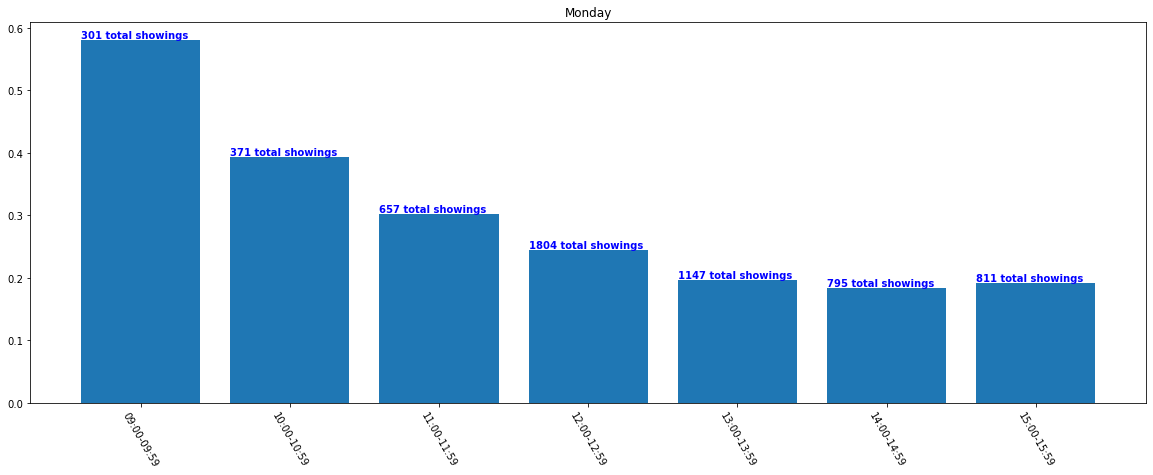

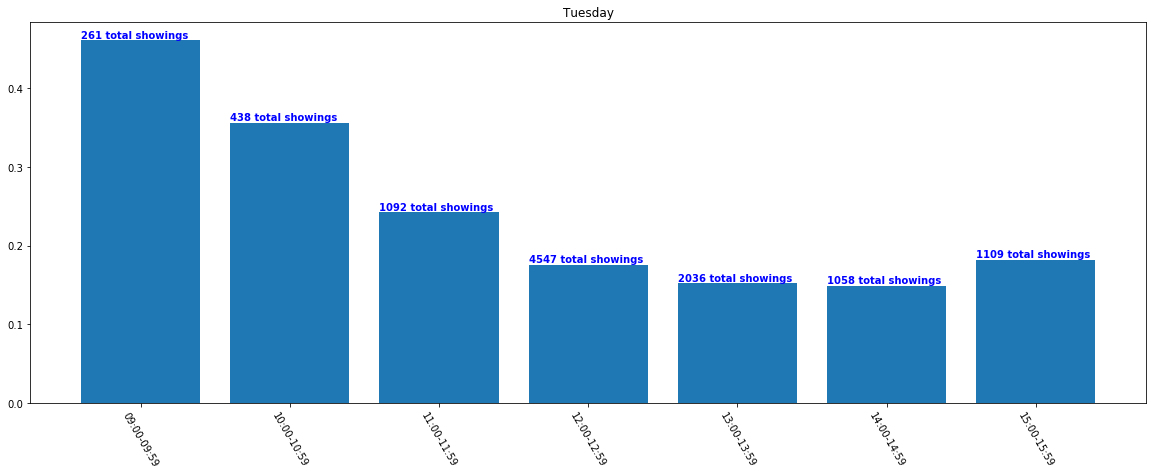

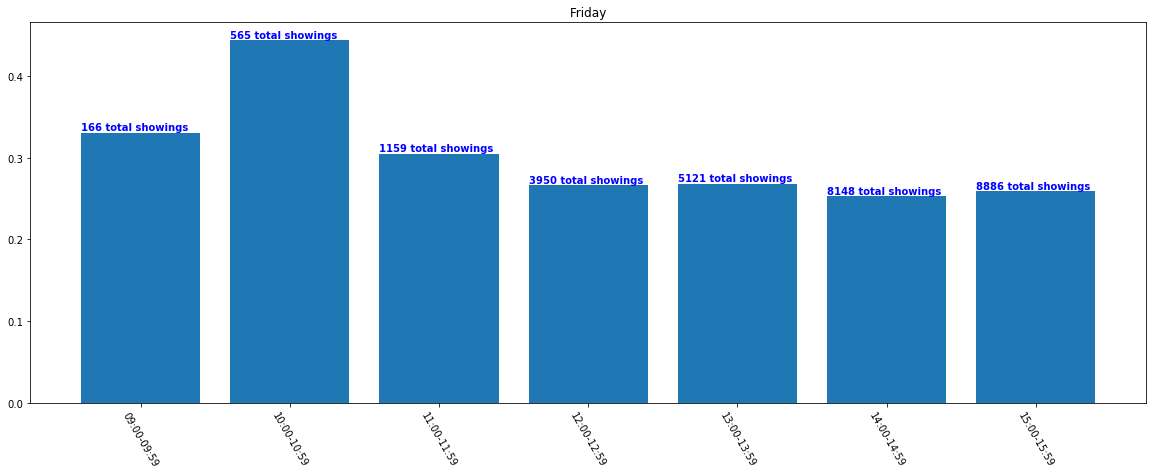

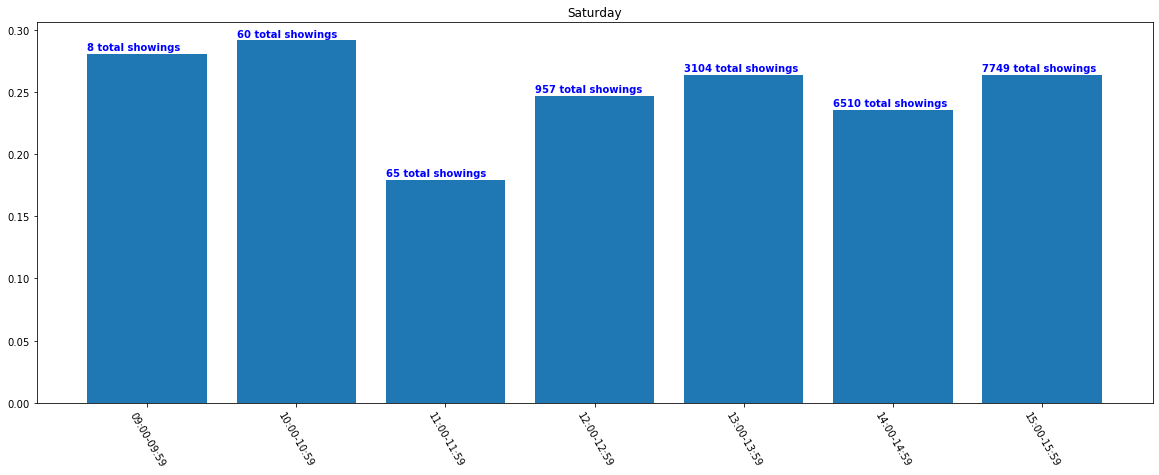

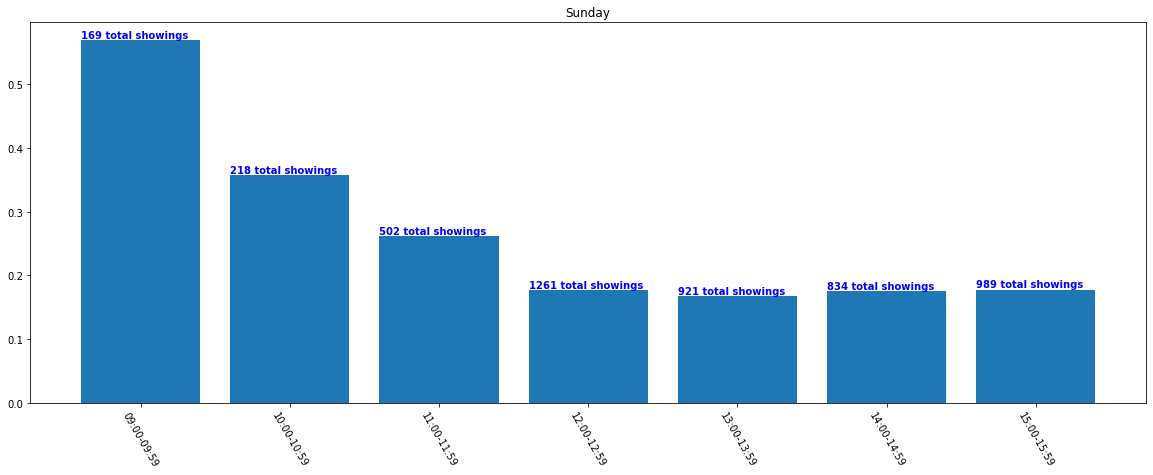

In [308]:
for i in stats_early_avg:
    f, ax = plt.subplots(figsize=(20,7))
    
    plt.bar(range(len(stats_early_avg[i])), list(stats_early_avg[i].values()), align='center')
    plt.xticks(range(len(stats_early_avg[i])), list(stats_early_avg[i].keys()), rotation=300)
    plt.title(i)
    
    for j, (k, v) in enumerate(stats_early_cnt[i].items()):
        ax.text(j - .4, stats_early_avg[i][k] + 0.003, str(v) + ' total showings', color='blue', fontweight='bold')
        

    plt.show()

# Combination of genres

In [28]:
genre_combo = set(tuple(np.sort(i)) for i in all_genres if len(i) > 1)

## Two genre combo

In [34]:
%%time
stats = dict()
for i in genre_combo:
    if len(i) == 2:
        stats[genres[i[0]] + '-' + genres[i[1]]] = showings.loc[
            showings.tmdb_genre_ids.apply(lambda numbers: i[0] in numbers and i[1] in numbers),
            'coverage']

Wall time: 40.9 s


In [35]:
stats_avg = dict()
for i in stats:
    stats_avg[i] = stats[i].mean()

In [36]:
stats_cnt = dict()
for i in stats:
    stats_cnt[i] = stats[i].count()

In [37]:
for i in sorted(stats_cnt.items(), key=lambda kv: kv[1]):
    print(i[1], '\t\t', i[0])

1 		 Documentary-Romance
6 		 Science Fiction-Music
12 		 Adventure-Documentary
97 		 Adventure-TV Movie
103 		 Family-TV Movie
172 		 Action-Documentary
182 		 Western-Crime
212 		 Drama-TV Movie
246 		 Horror-Documentary
259 		 Comedy-Documentary
262 		 Documentary-War
266 		 Animation-Documentary
466 		 Drama-Western
521 		 Comedy-War
776 		 Animation-Western
781 		 Horror-Romance
796 		 Romance-TV Movie
875 		 Documentary-TV Movie
918 		 Science Fiction-TV Movie
950 		 Drama-Documentary
994 		 Comedy-History
1233 		 Comedy-TV Movie
1565 		 Action-Western
1787 		 History-Documentary
2383 		 Horror-Crime
2393 		 Comedy-Mystery
2459 		 Documentary-Music
2752 		 Animation-Drama
3082 		 History-Thriller
3425 		 Action-History
4139 		 Horror-Comedy
4196 		 Animation-Science Fiction
4202 		 Adventure-History
5135 		 Music-Romance
5415 		 Fantasy-Music
5728 		 Fantasy-Horror
7695 		 Animation-Music
8071 		 Comedy-Science Fiction
8182 		 Drama-Family
8643 		 Drama-Music
8868 		 Horror-Scien

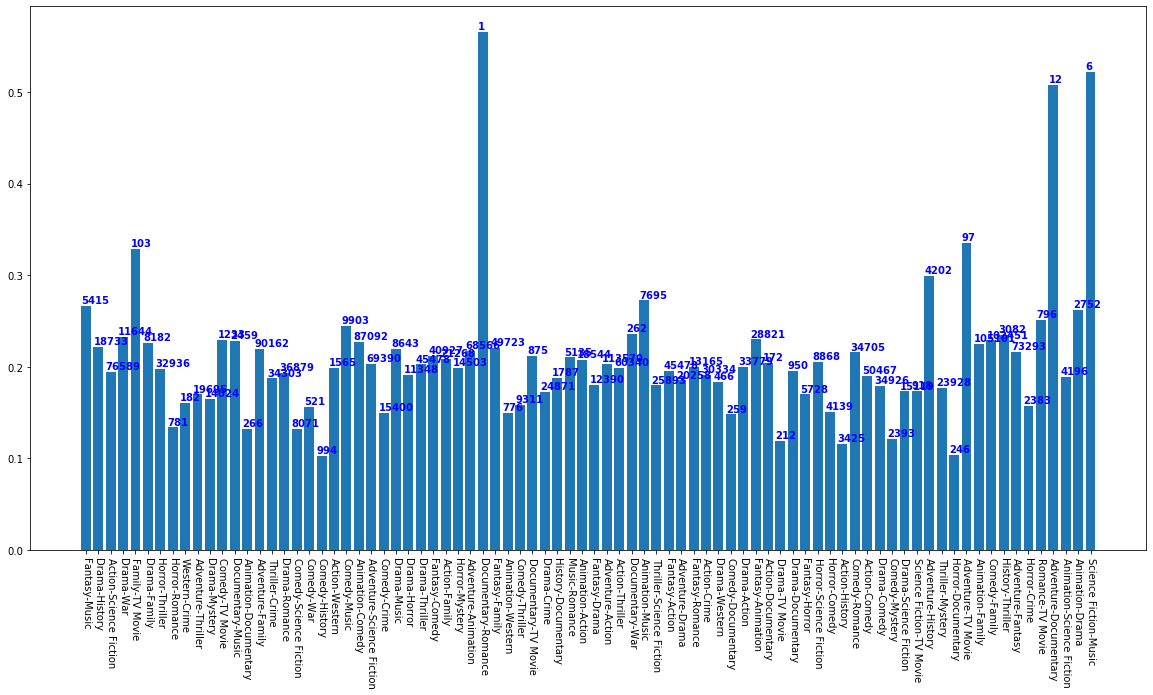

In [38]:
f, ax = plt.subplots(figsize=(20,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=270)

for i, (j, v) in enumerate(stats_cnt.items()):
    ax.text(i - .4, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

## Three genre combo

In [39]:
%%time
stats = dict()
for i in genre_combo:
    if len(i) == 3:
        stats[genres[i[0]] + '-' + genres[i[1]] + '-' + genres[i[2]]] = showings.loc[
            showings.tmdb_genre_ids.apply(lambda numbers: i[0] in numbers and i[1] in numbers and i[2] in numbers),
            'coverage']

Wall time: 1min 23s


In [40]:
stats.keys()

dict_keys(['Adventure-Action-Crime', 'Fantasy-Comedy-Romance', 'Action-Crime-Mystery', 'Drama-Comedy-Crime', 'Fantasy-Action-Thriller', 'Adventure-Action-Thriller', 'Drama-Action-Thriller', 'Fantasy-Music-Romance', 'Comedy-Thriller-Romance', 'Drama-Science Fiction-Romance', 'Drama-Thriller-Romance', 'Drama-Horror-Mystery', 'Fantasy-Animation-Drama', 'Drama-Comedy-Romance', 'Drama-Thriller-War', 'Drama-Science Fiction-War', 'Adventure-Action-Western', 'Drama-Music-Romance', 'Comedy-Crime-Romance', 'Drama-Documentary-Family', 'Drama-Thriller-Crime', 'Action-Science Fiction-Mystery', 'Drama-Action-History', 'Fantasy-Horror-Thriller', 'Drama-Romance-TV Movie', 'Horror-Science Fiction-Mystery', 'Drama-Crime-Documentary', 'Adventure-Comedy-Family', 'Horror-Action-Thriller', 'Comedy-Crime-Mystery', 'Adventure-History-War', 'Drama-Action-Romance', 'Comedy-Romance-Family', 'Horror-Thriller-Crime', 'Animation-Comedy-Science Fiction', 'Comedy-Thriller-Science Fiction', 'Adventure-Horror-Comedy', 

In [51]:
stats_avg = dict()
stats_cnt = dict()
for i in stats:
    if stats[i].count() > 2e+3:
        stats_avg[i] = stats[i].mean()
        stats_cnt[i] = stats[i].count()

In [49]:
for i in sorted(stats_cnt.items(), key=lambda kv: kv[1]):
    print(i[1], '\t\t', i[0])

1035 		 Drama-Crime-Romance
1107 		 Adventure-Horror-Comedy
1156 		 Adventure-Thriller-Romance
1166 		 Adventure-Action-War
1232 		 Adventure-Thriller-Mystery
1243 		 Drama-Romance-Family
1265 		 Comedy-Music-Romance
1276 		 Horror-Comedy-Thriller
1329 		 Drama-Comedy-Music
1352 		 Action-Thriller-Romance
1401 		 Adventure-Drama-Comedy
1406 		 Drama-Science Fiction-Mystery
1407 		 Drama-Comedy-Mystery
1420 		 Animation-Comedy-Science Fiction
1476 		 Horror-Action-Comedy
1543 		 Comedy-Crime-Mystery
1559 		 Adventure-Action-Western
1583 		 Fantasy-Drama-Comedy
1596 		 Fantasy-Drama-Action
1761 		 Action-Science Fiction-Mystery
1896 		 Adventure-Horror-Action
1899 		 Horror-Thriller-Crime
1914 		 Drama-Horror-Science Fiction
2130 		 Adventure-Horror-Thriller
2133 		 Animation-Science Fiction-Family
2207 		 Animation-Drama-Family
2225 		 Adventure-Drama-Romance
2233 		 Fantasy-Horror-Thriller
2275 		 Fantasy-Drama-Horror
2282 		 Fantasy-Action-Thriller
2421 		 Drama-Thriller-Romance
2560 

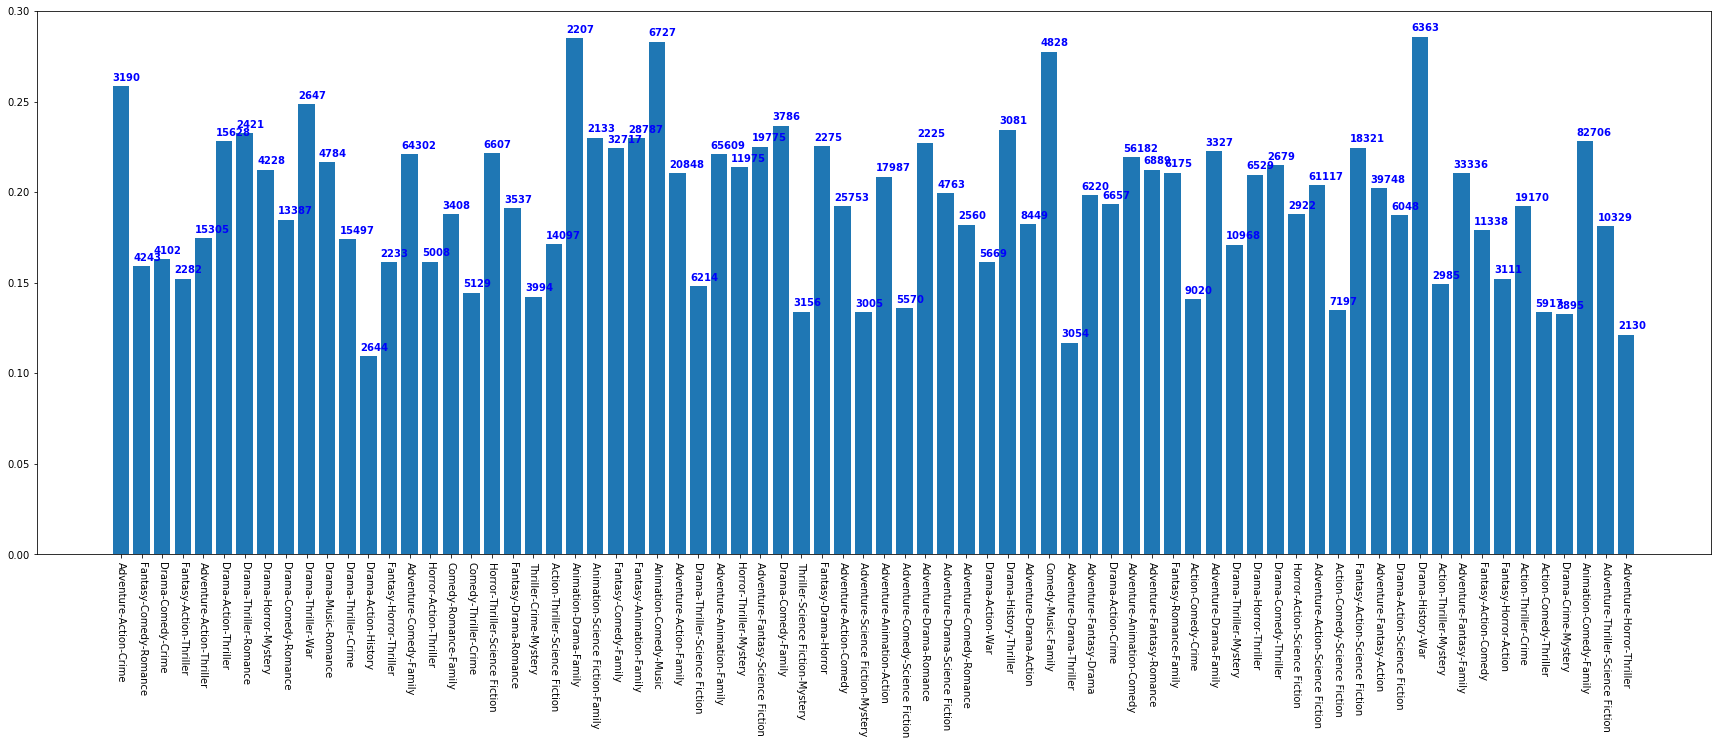

In [52]:
f, ax = plt.subplots(figsize=(30,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=270)

for i, (j, v) in enumerate(stats_cnt.items()):
    ax.text(i - .4, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

## Four genre combo

In [53]:
%%time
stats = dict()
for i in genre_combo:
    if len(i) == 4:
        stats[genres[i[0]] + '-' + genres[i[1]] + '-' + genres[i[2]] + '-' + genres[i[3]]] = showings.loc[
            showings.tmdb_genre_ids.apply(lambda numbers: i[0] in numbers and i[1] in numbers and i[2] in numbers and i[3] in numbers),
            'coverage']

Wall time: 1min 4s


In [58]:
stats_avg = dict()
stats_cnt = dict()
for i in stats:
    if stats[i].count() > 1e+3:
        stats_avg[i] = stats[i].mean()
        stats_cnt[i] = stats[i].count()

In [390]:
for i in sorted(stats_cnt.items(), key=lambda kv: kv[1]):
    print(i[1], '\t\t', i[0])

1 		 Adventure-Action-History-War
4 		 Horror-Action-Thriller-Crime
4 		 Drama-History-Crime-War
12 		 Adventure-Drama-History-War
26 		 Fantasy-Drama-Romance-Family
42 		 Adventure-Comedy-Crime-Family
51 		 Drama-Horror-Crime-Mystery
59 		 Fantasy-Action-Music-Family
78 		 Drama-Horror-Thriller-Crime
79 		 Horror-Comedy-Thriller-Romance
111 		 Adventure-Action-Crime-Mystery
119 		 Adventure-Action-Thriller-Mystery
133 		 Adventure-Action-Comedy-War
192 		 Action-Comedy-Thriller-Romance
275 		 Adventure-Drama-Horror-Thriller
287 		 Drama-History-Romance-War
321 		 Drama-History-Thriller-Crime
329 		 Drama-Action-Comedy-Crime
359 		 Horror-Thriller-Science Fiction-Mystery
378 		 Horror-Thriller-Crime-Mystery
385 		 Drama-Music-Romance-Family
400 		 Horror-Comedy-Thriller-Mystery
401 		 Adventure-Fantasy-Drama-Action
421 		 Drama-Comedy-Romance-Family
425 		 Adventure-Fantasy-Drama-Comedy
428 		 Drama-Action-Thriller-War
478 		 Fantasy-Drama-Comedy-Romance
661 		 Drama-Comedy-Crime-Roman

In [59]:
f, ax = plt.subplots(figsize=(30,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=270)

for i, (j, v) in enumerate(stats_cnt.items()):
    ax.text(i - .4, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

# One year at a time

We choose to ignore showings prior to 2007 due to how few showings in that period

In [10]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [12]:
(
    showings.loc[showings.year==2001, ('location')].value_counts(),
    showings.loc[showings.year==2002, ('location')].value_counts(),
    showings.loc[showings.year==2003, ('location')].value_counts(),
    showings.loc[showings.year==2004, ('location')].value_counts(),
    showings.loc[showings.year==2005, ('location')].value_counts(),
    showings.loc[showings.year==2006, ('location')].value_counts(),
    showings.loc[showings.year==2007, ('location')].value_counts(),
    showings.loc[showings.year==2019, ('location')].value_counts()
)

(110    35
 Name: location, dtype: int64,
 110    117
 113      4
 Name: location, dtype: int64,
 110    998
 193    966
 113    230
 151      4
 119      3
 Name: location, dtype: int64,
 113    1350
 110    1197
 193    1111
 141     399
 151       6
 170       1
 Name: location, dtype: int64,
 113    2526
 110    1063
 193    1046
 141     533
 151       7
 106       4
 170       2
 Name: location, dtype: int64,
 113    2710
 110    1247
 193    1098
 101     331
 141     214
 119     144
 128     129
 205     126
 228     126
 117     116
 121      99
 109      82
 149      40
 103      38
 170       3
 206       2
 105       1
 312       1
 Name: location, dtype: int64,
 228    3738
 205    3738
 113    2547
 117    2351
 101    1903
 116    1822
 110    1094
 193    1051
 147     924
 119     896
 105     886
 312     886
 206     748
 109     740
 121     641
 123     548
 301     524
 118     524
 149     497
 126     414
 133     409
 140     400
 207     325
 182     277
 103

In [17]:
(
    len(showings.loc[showings.year==2001, ('location')].unique()),
    len(showings.loc[showings.year==2002, ('location')].unique()),
    len(showings.loc[showings.year==2003, ('location')].unique()),
    len(showings.loc[showings.year==2004, ('location')].unique()),
    len(showings.loc[showings.year==2005, ('location')].unique()),
    len(showings.loc[showings.year==2006, ('location')].unique()),
    len(showings.loc[showings.year==2007, ('location')].unique())
)

(1, 2, 5, 6, 7, 18, 46)

In [9]:
showings.loc[showings.year==1970, ('showtime', 'stripped_title', 'coverage')]

showtime                   stripped_title  coverage
6016    1970-01-26 17:00:00      rive rolf krasjer internett  0.027027
6763    1970-01-26 19:30:00                bohemian rhapsody  0.000000
6783    1970-01-26 19:30:00                            glass  0.000000
105882  1970-12-20 18:00:00                             zero  0.007380
105917  1970-12-22 18:00:00                             zero  0.000000
360117  1970-01-07 18:00:00  star wars the rise of skywalker  0.000000
1044104 1970-06-12 17:30:06                 ulv i fåreklær 2  0.020325

In [7]:
showings.loc[showings.year==1990, ('showtime', 'stripped_title', 'coverage')]

showtime                 stripped_title  coverage
1082567 1990-06-08 17:25:00  jurassic world fallen kingdom  0.003922
1082655 1990-06-08 20:00:00  jurassic world fallen kingdom  0.000000

In [17]:
showings.loc[(showings.year==2002) & (showings.location==113), ('showtime', 'stripped_title', 'coverage')].sort_values('showtime')

showtime                    stripped_title  coverage
156583 2002-12-31 16:15:00                   pelle politibil  0.452830
152533 2002-12-31 17:00:00  harry potter og mysteriekammeret  0.593220
173098 2002-12-31 18:00:00                  sjørøverplaneten  0.160377
144691 2002-12-31 20:15:00            ringenes herre to tårn  1.000000

In [21]:
showings.loc[(showings.year==2001) & (showings.location==110), ('showtime', 'stripped_title', 'coverage', 'room')].sort_values('showtime').room.unique()

array([11002, 11001], dtype=int64)

In [8]:
%time showings.year.value_counts()

Wall time: 16 ms


2018    132778
2019    132328
2017    125162
2016    121255
2014     89165
2015     88764
2013     87530
2012     79776
2011     72285
2010     60905
2009     48902
2008     39804
2007     29585
2020      7843
2006      6507
2005      5181
2004      4064
2003      2201
2002       121
2001        35
1970         7
1990         2
2200         2
Name: year, dtype: int64

## Coverage per hour per year

In [63]:
%%time
stats_outlier = dict()
stats_prime = dict()
stats_early = dict()
for i in range(2007, 2021):
    stats_outlier[i] = dict()
    stats_prime[i] = dict()
    stats_early[i] = dict()
    temp = showings.loc[showings.showtime.dt.strftime('%Y').between(str(i), str(i))]
    for j in range(24):
        if j == 0:
            stats_outlier[i]['23:00-08:59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between('23:00:00', '23:59:59')
                | temp.showtime.dt.strftime('%H:%M:%S').between('00:00:00', '08:59:59'),
                'coverage']
        elif j == 23 or j < 9: continue
        elif j < 10:
            stats_early[i]['0' + str(j) + ':00-0' + str(j) + ':59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between('0' + str(j) + ':00:00', '0' + str(j) + ':59:59'),
                'coverage']
        elif j < 16:
            stats_early[i][str(j) + ':00-' + str(j) + ':59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between(str(j) + ':00:00', str(j) + ':59:59'),
                'coverage']
        else:
            stats_prime[i][str(j) + ':00-' + str(j) + ':59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between(str(j) + ':00:00', str(j) + ':59:59'),
                'coverage']

Wall time: 2min 7s


In [64]:
stats_prime_avg = dict()
for i in stats_prime:
    stats_prime_avg[i] = dict()
    for j in stats_prime[i]:
        stats_prime_avg[i][j] = stats_prime[i][j].mean()

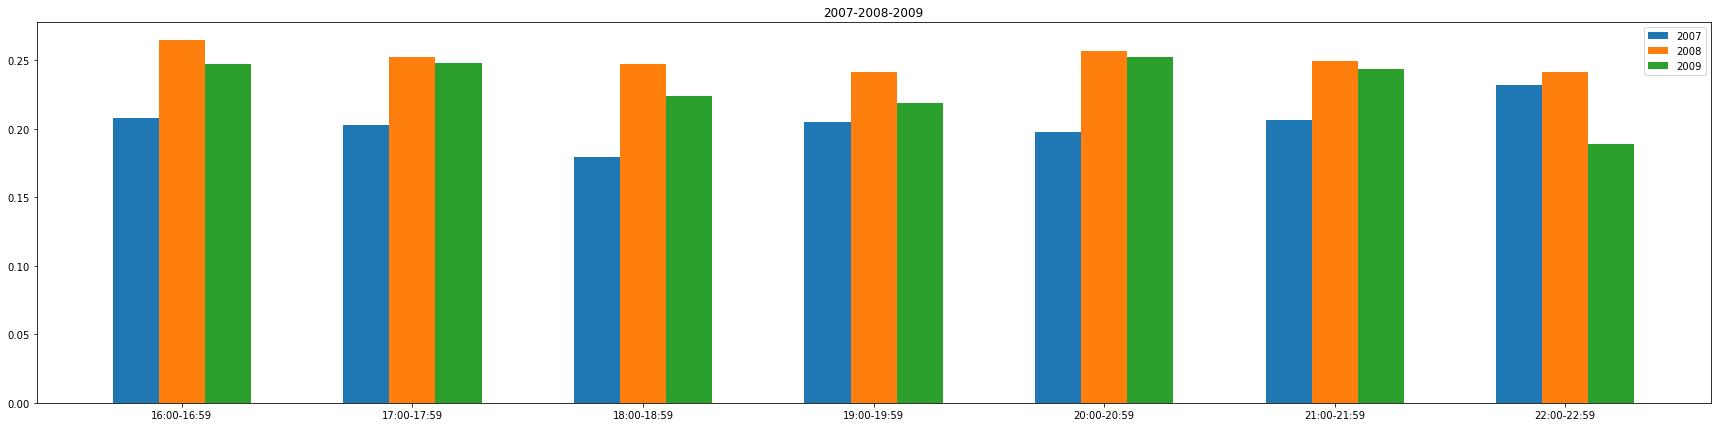

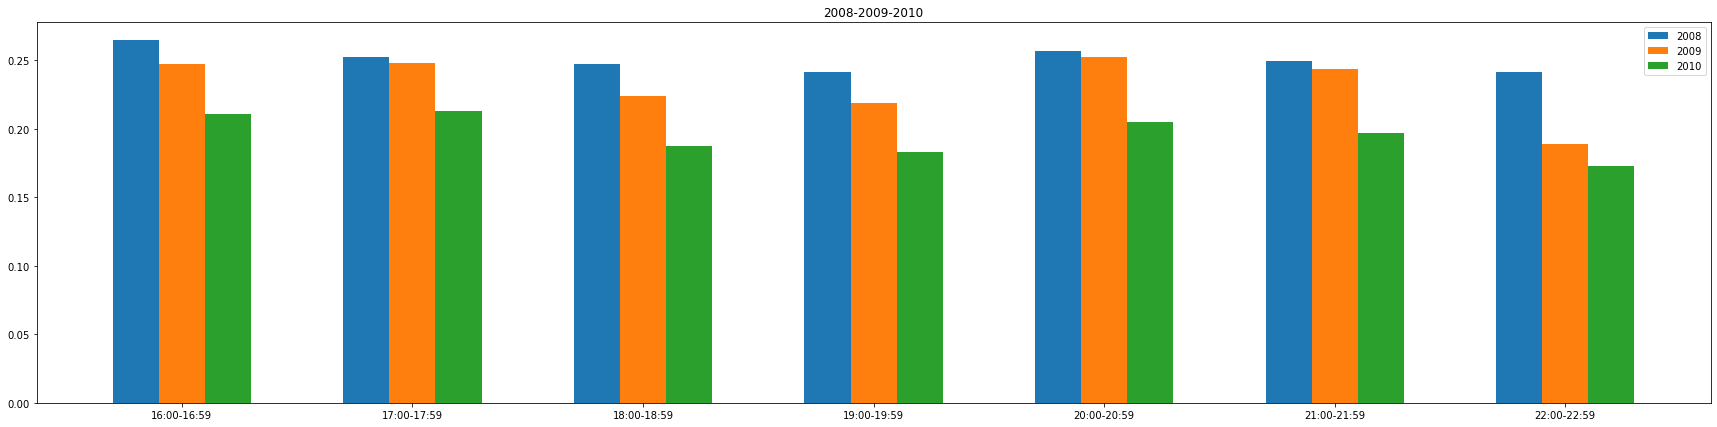

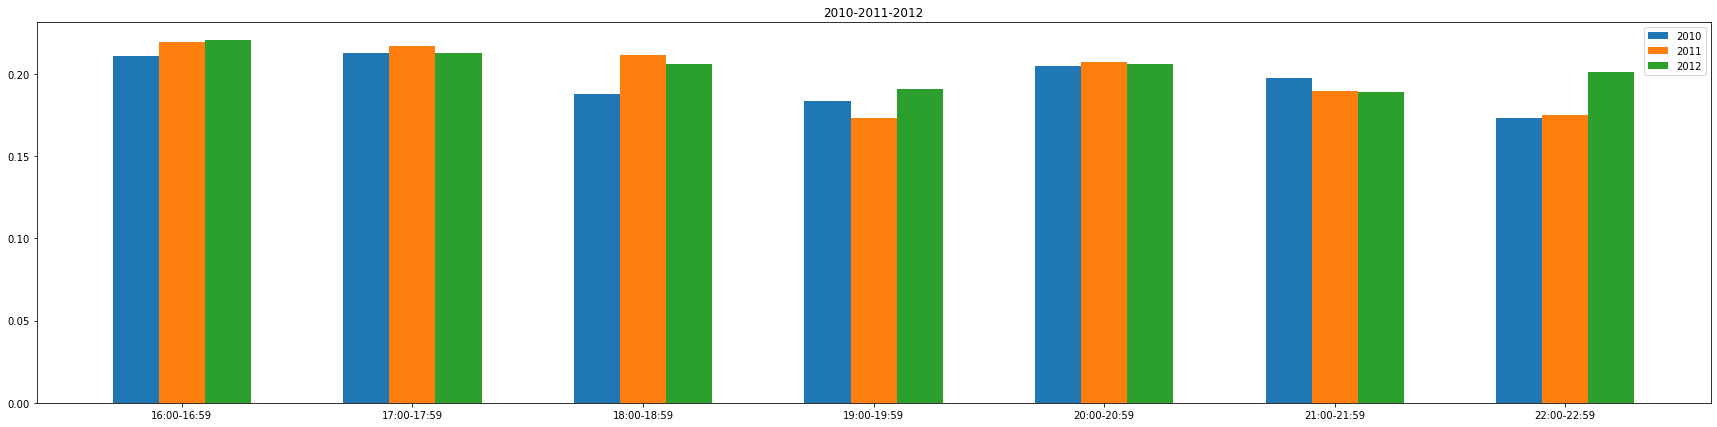

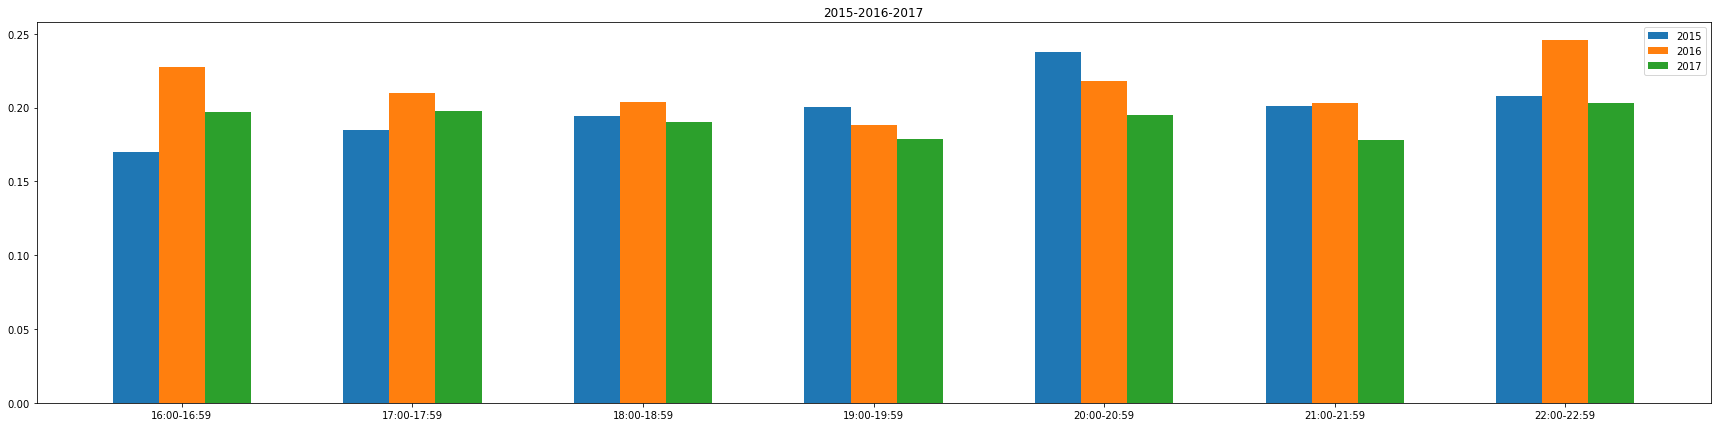

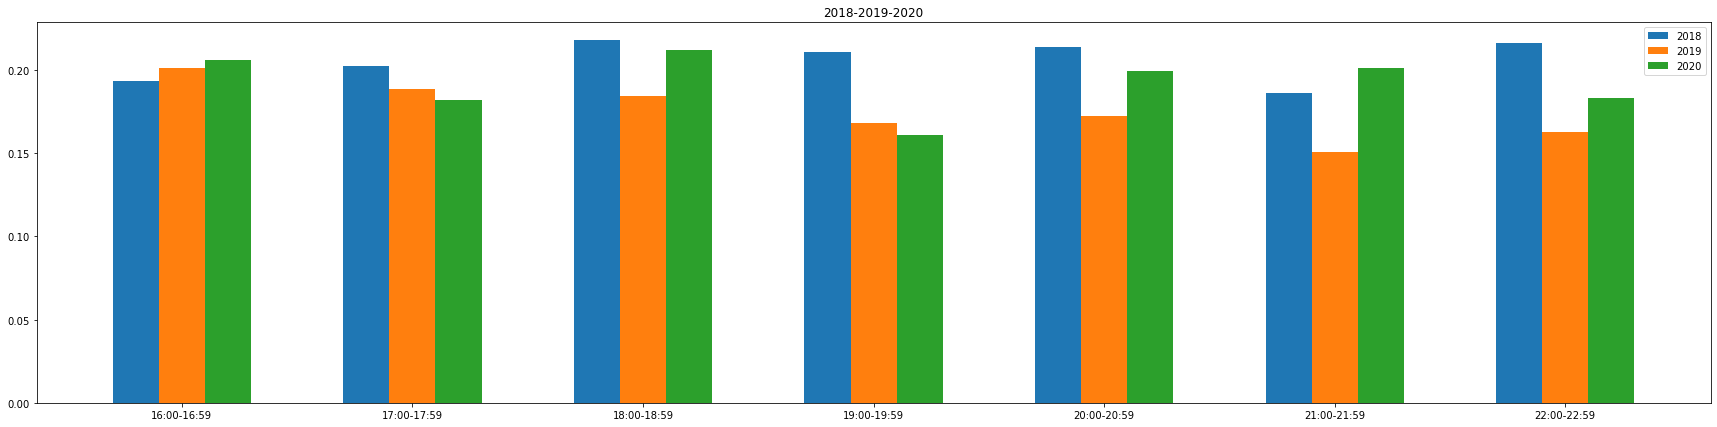

In [65]:
for i in stats_prime_avg:
    if i+2 == 2021: break
    f, ax = plt.subplots(figsize=(30,7))

    plt.bar(np.arange(len(stats_prime_avg[i]))-.2, list(stats_prime_avg[i].values()), width=.2, align='center')
    plt.bar(np.arange(len(stats_prime_avg[i])), list(stats_prime_avg[i+1].values()), width=.2, align='center')
    plt.bar(np.arange(len(stats_prime_avg[i]))+.2, list(stats_prime_avg[i+2].values()), width=.2, align='center')
    plt.xticks(range(len(stats_prime_avg[i])), list(stats_prime_avg[i].keys()), rotation=0)
    plt.title(str(i)+'-'+str(i+1)+'-'+str(i+2))

    plt.legend((str(i), str(i+1), str(i+2)))
    
    plt.show()

## Coverage per hour per day per year

In [464]:
%%time
stats_outlier = dict()
stats_prime = dict()
stats_early = dict()
for i in range(2007, 2021):
    stats_outlier[i] = dict()
    stats_prime[i] = dict()
    stats_early[i] = dict()
    temp_year = showings.loc[showings.showtime.dt.strftime('%Y').between(str(i), str(i))]
    for j in range(7):
        temp_day = temp_year.loc[temp_year.showtime.dt.dayofweek == j, ('showtime', 'coverage')]
        stats_outlier[i][calendar.day_name[j]] = dict()
        stats_prime[i][calendar.day_name[j]] = dict()
        stats_early[i][calendar.day_name[j]] = dict()
        for k in range(24):
            if k == 0:
                stats_outlier[i][calendar.day_name[j]]['23:00-08:59'] = temp_day.loc[
                    temp_day.showtime.dt.strftime('%H:%M:%S').between('23:00:00', '23:59:59')
                    | temp_day.showtime.dt.strftime('%H:%M:%S').between('00:00:00', '08:59:59'),
                    'coverage']
            elif k == 23 or k < 9: continue
            elif k < 10:
                stats_early[i][calendar.day_name[j]]['0' + str(k) + ':00-0' + str(k) + ':59'] = temp_day.loc[
                    temp_day.showtime.dt.strftime('%H:%M:%S').between('0' + str(k) + ':00:00', '0' + str(k) + ':59:59'),
                    'coverage']
            elif k < 16:
                stats_early[i][calendar.day_name[j]][str(k) + ':00-' + str(k) + ':59'] = temp_day.loc[
                    temp_day.showtime.dt.strftime('%H:%M:%S').between(str(k) + ':00:00', str(k) + ':59:59'),
                    'coverage']
            else:
                stats_prime[i][calendar.day_name[j]][str(k) + ':00-' + str(k) + ':59'] = temp_day.loc[
                    temp_day.showtime.dt.strftime('%H:%M:%S').between(str(k) + ':00:00', str(k) + ':59:59'),
                    'coverage']

Wall time: 2min 9s


In [465]:
stats_prime_avg = dict()
for i in stats_prime:
    stats_prime_avg[i] = dict()
    for j in stats_prime[i]:
        stats_prime_avg[i][j] = dict()
        for k in stats_prime[i][j]:
            stats_prime_avg[i][j][k] = stats_prime[i][j][k].mean()

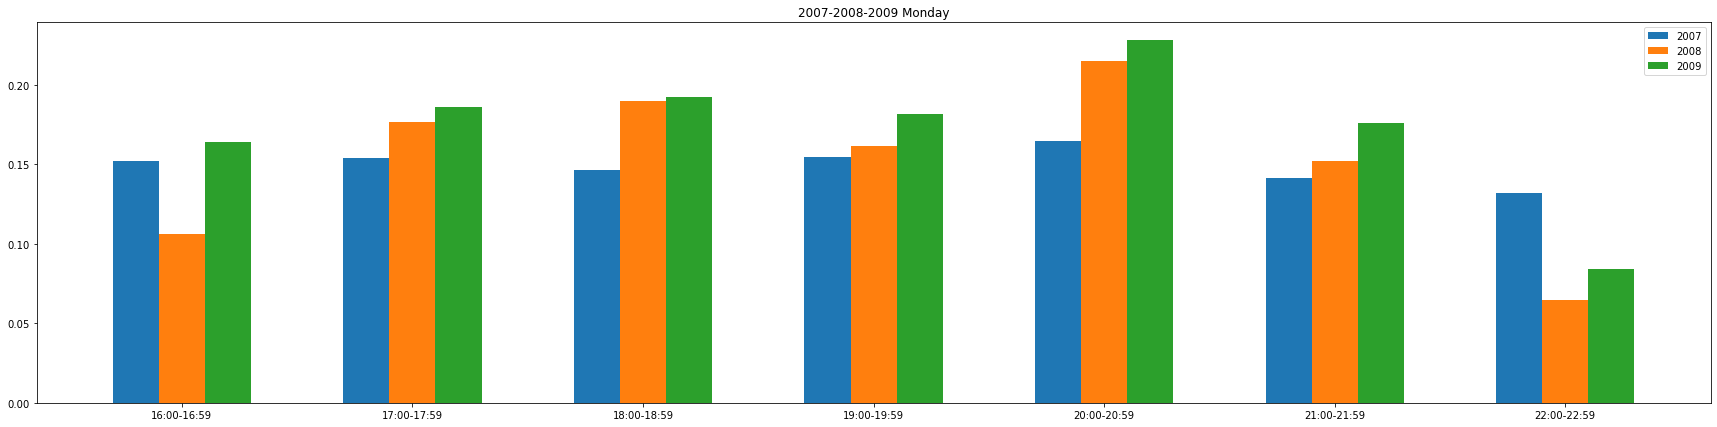

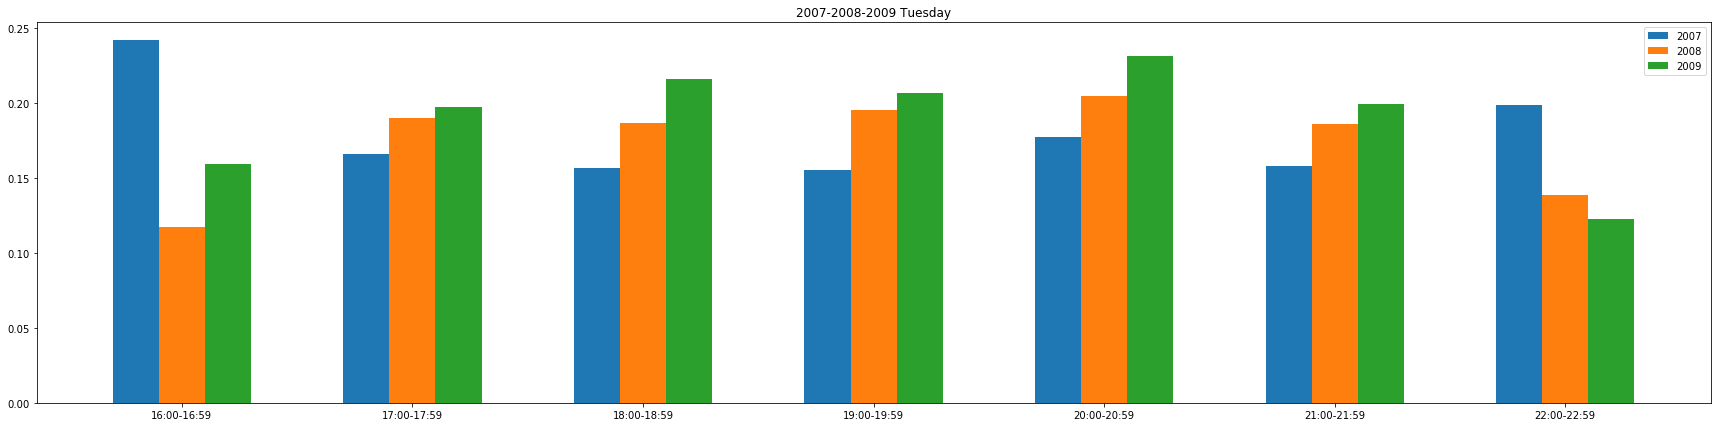

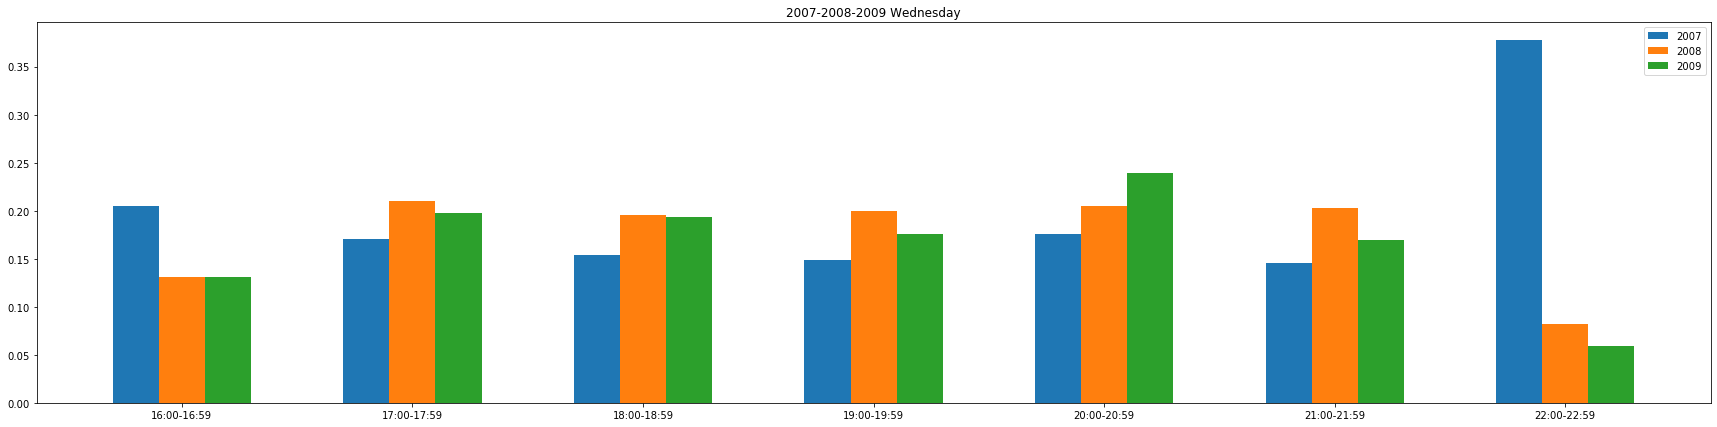

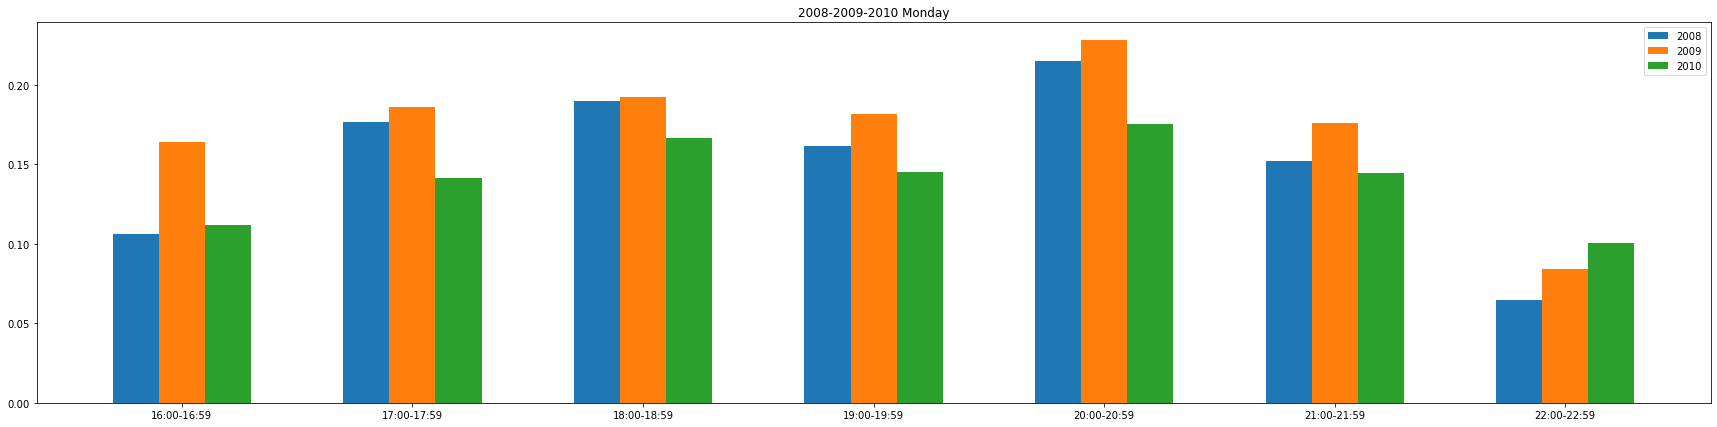

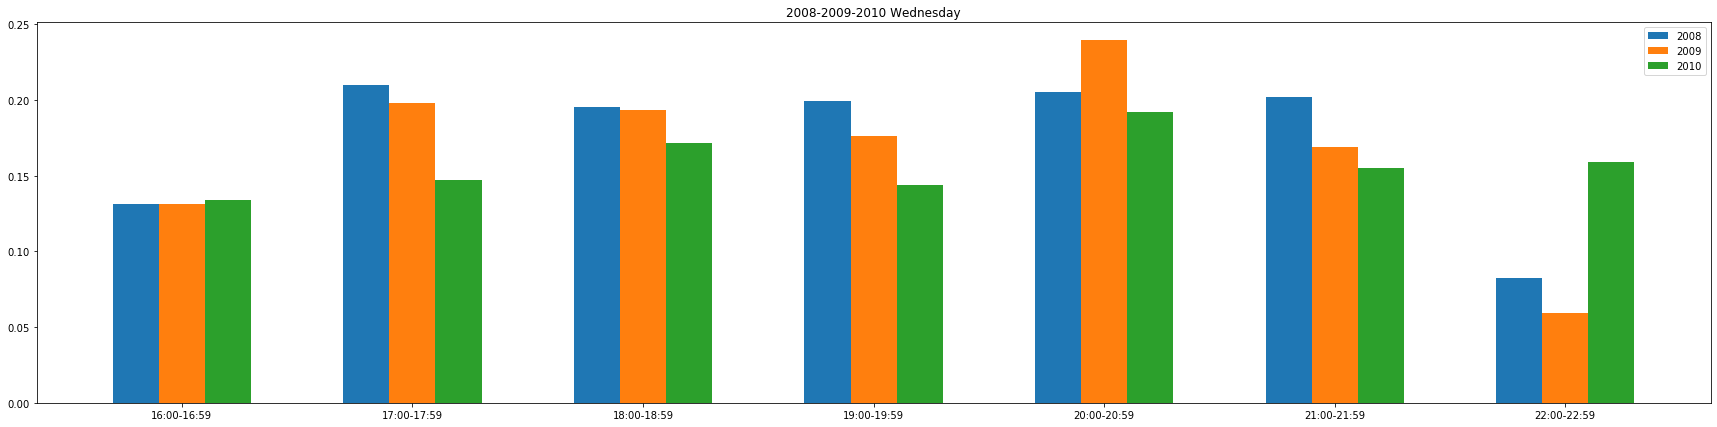

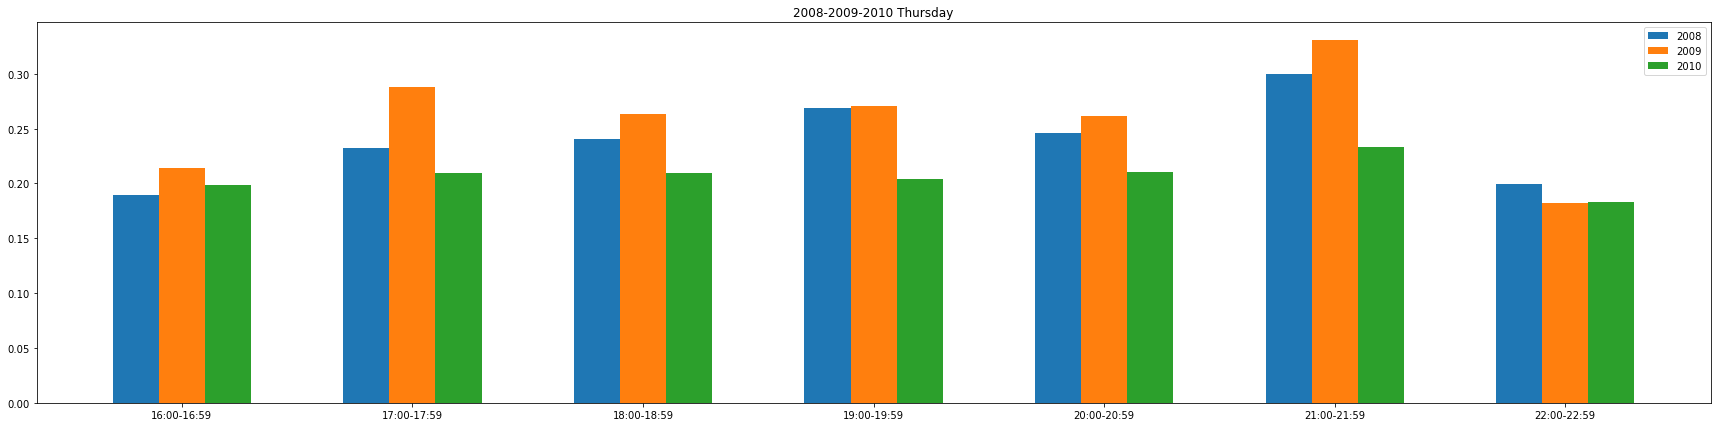

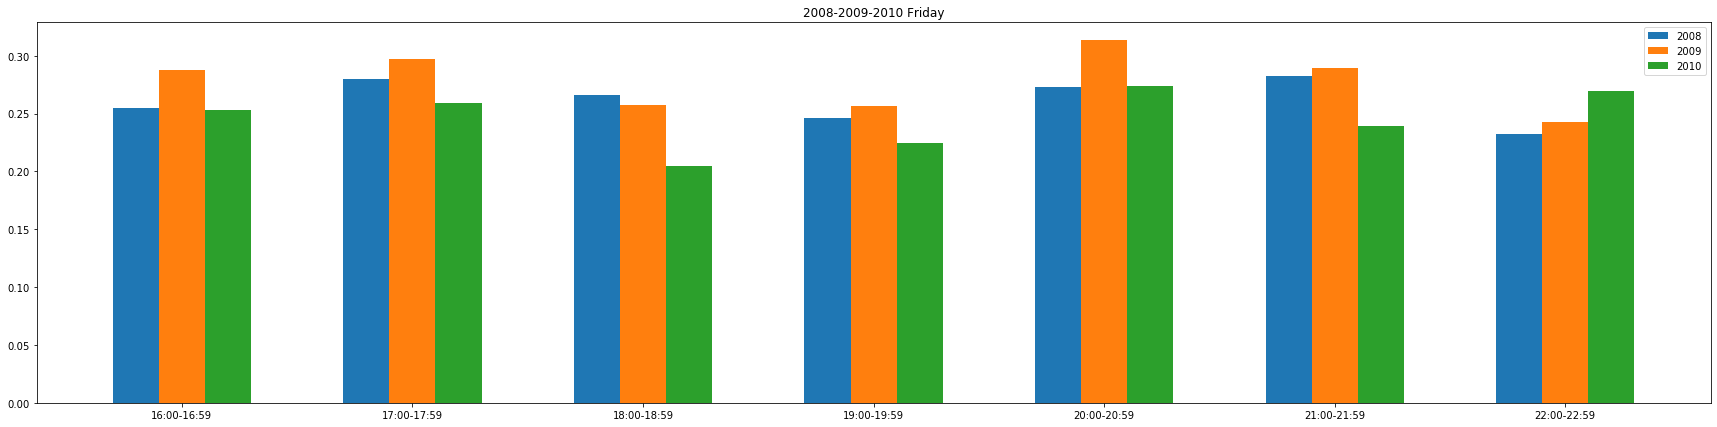

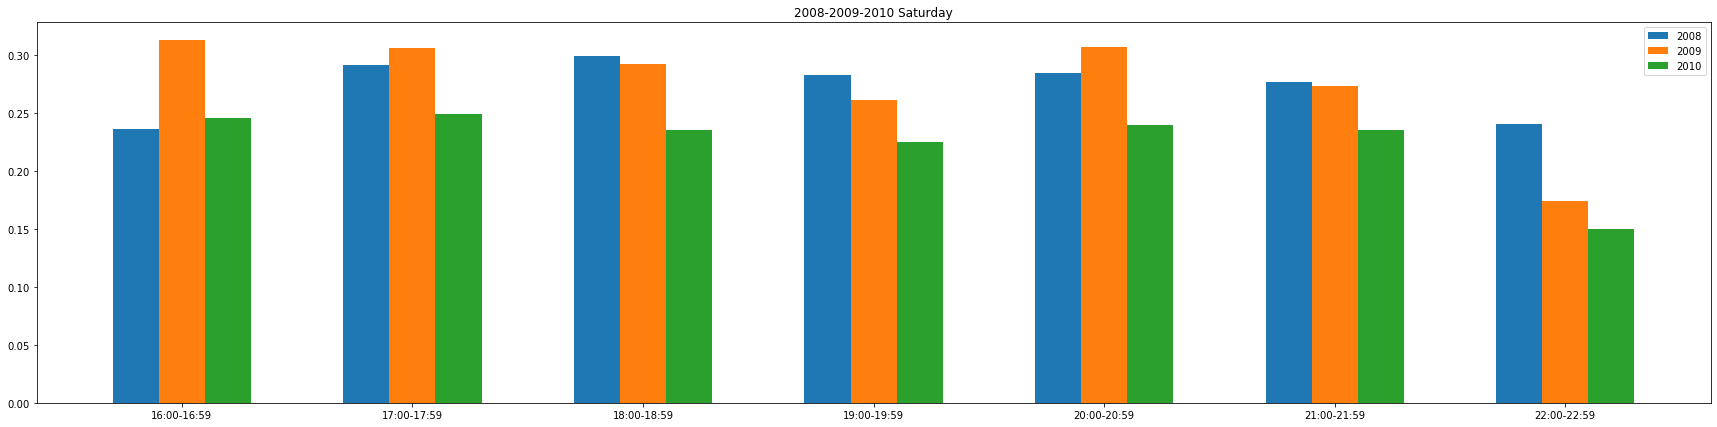

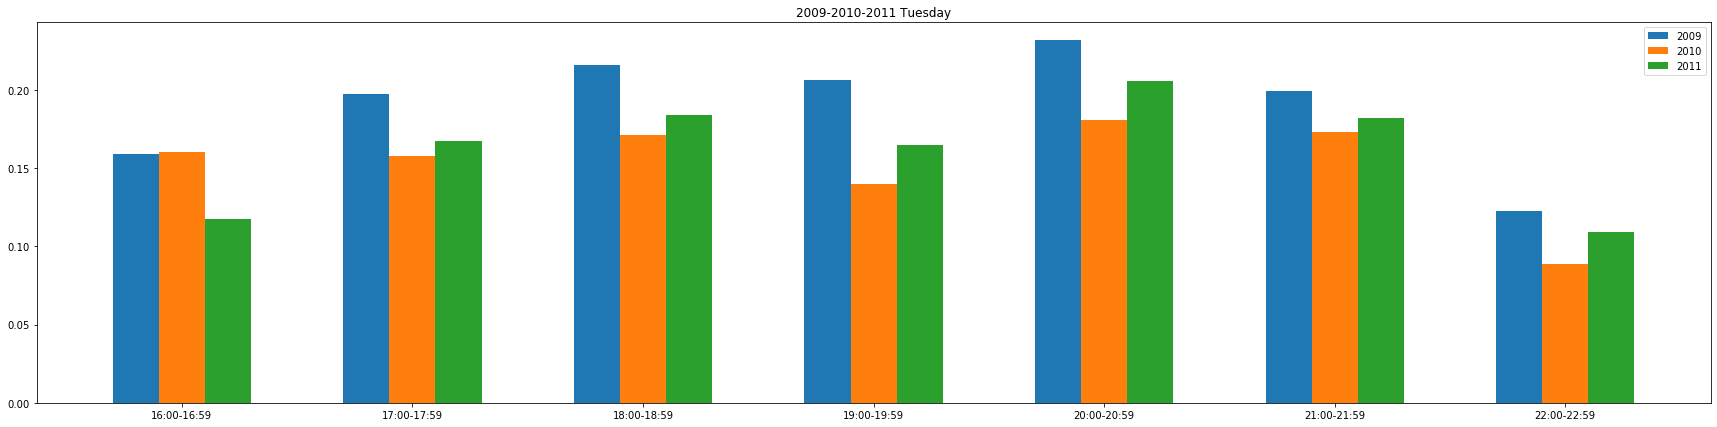

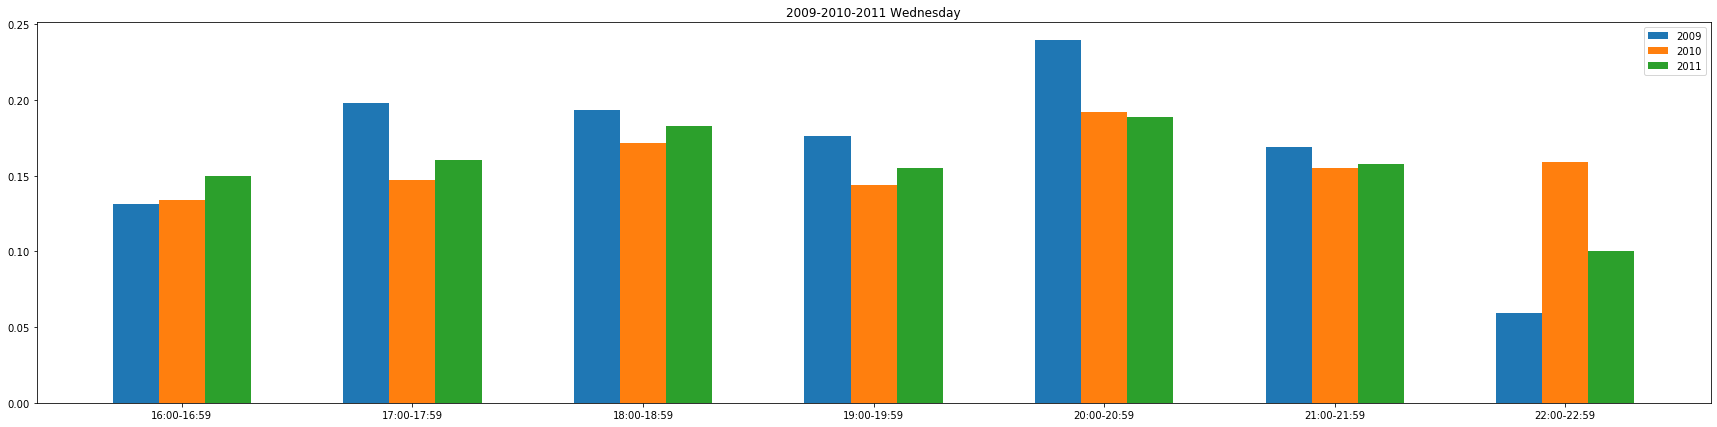

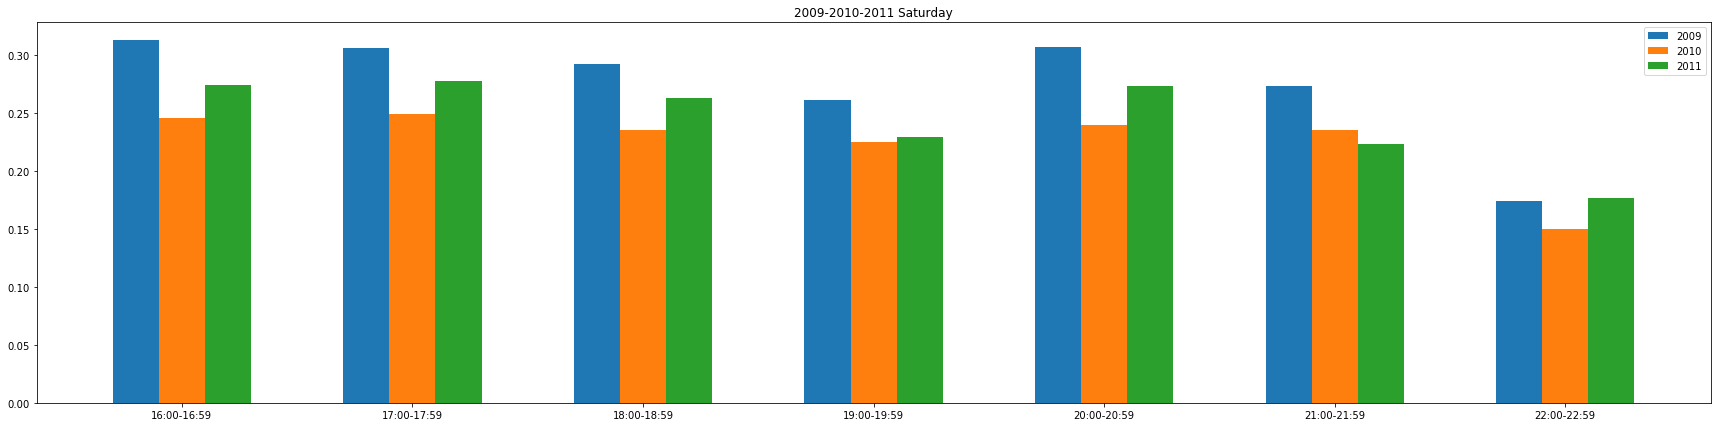

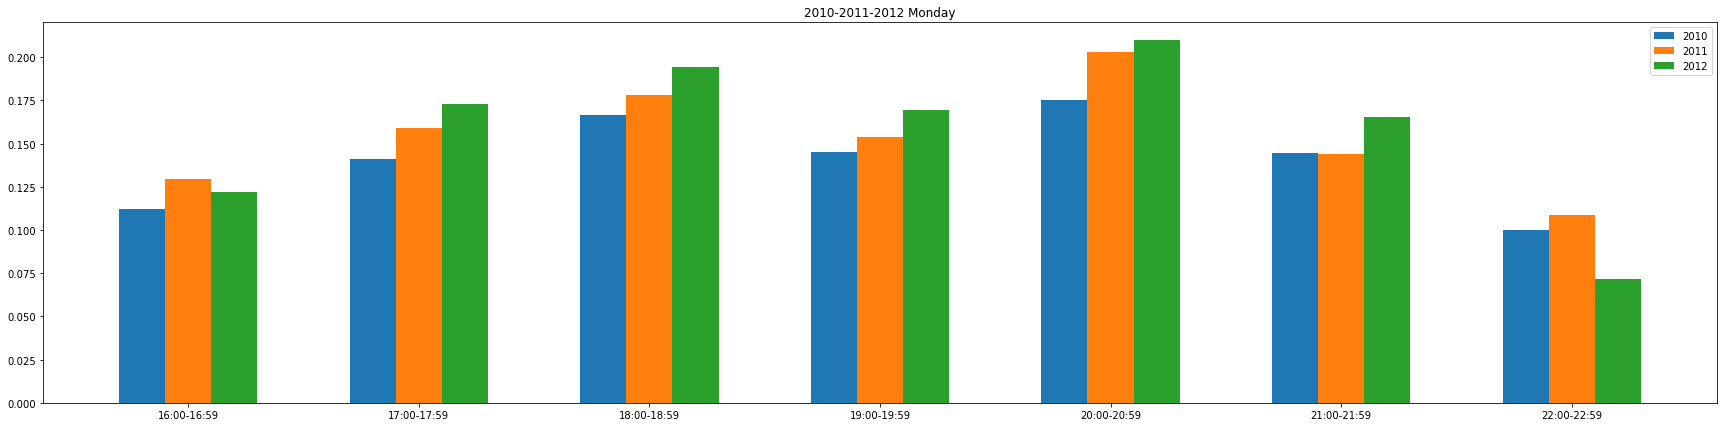

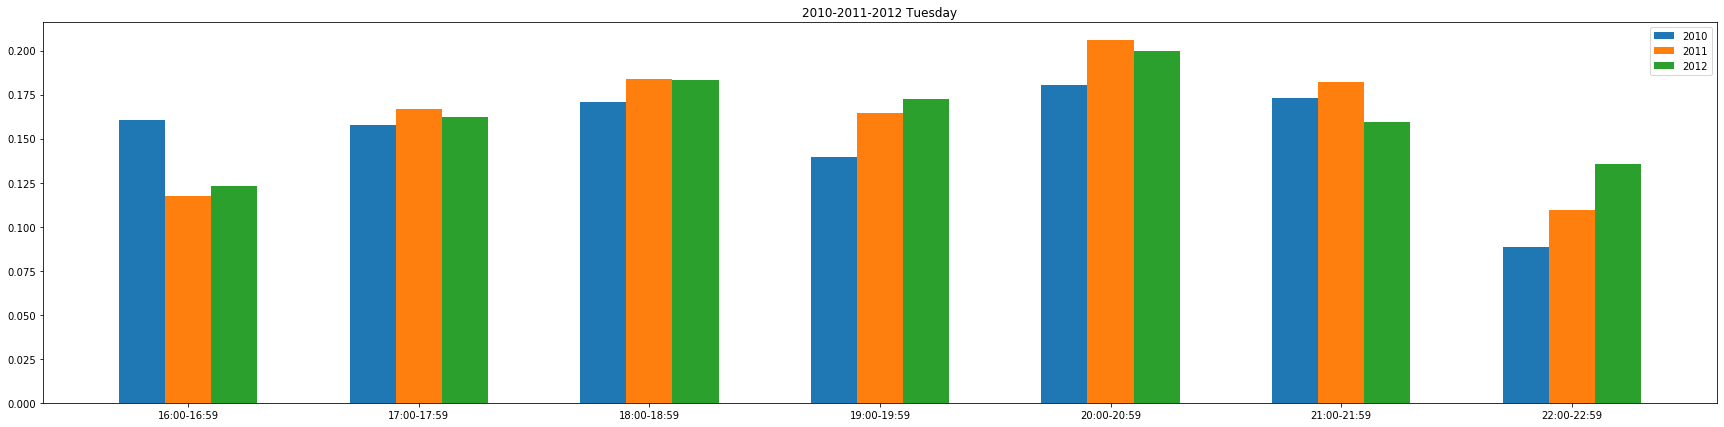

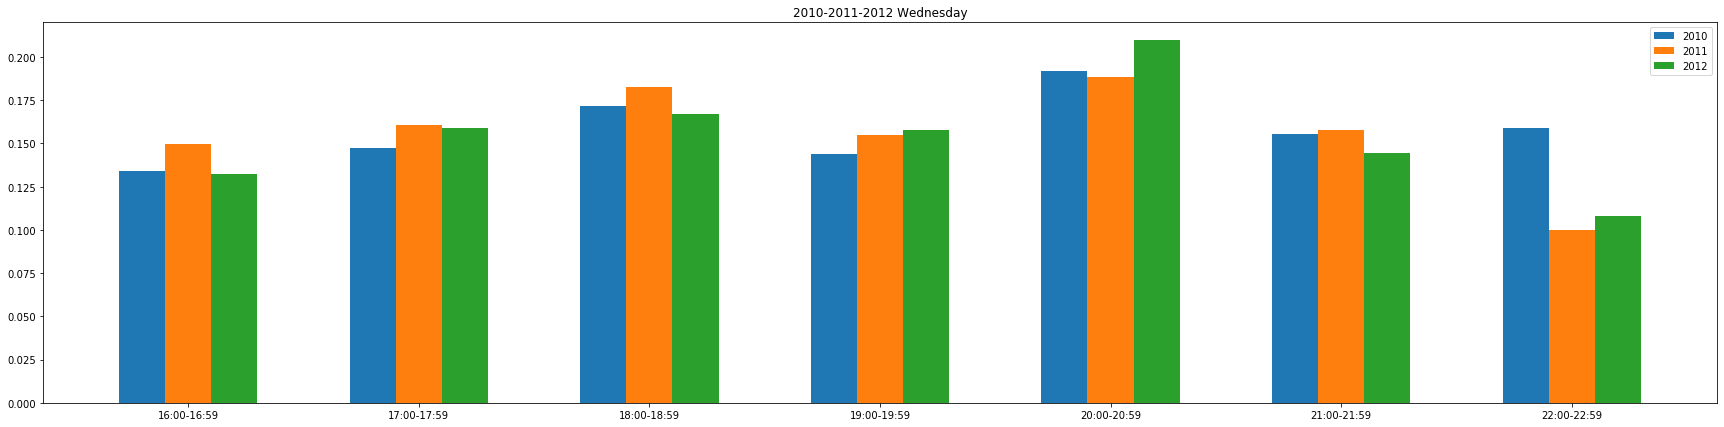

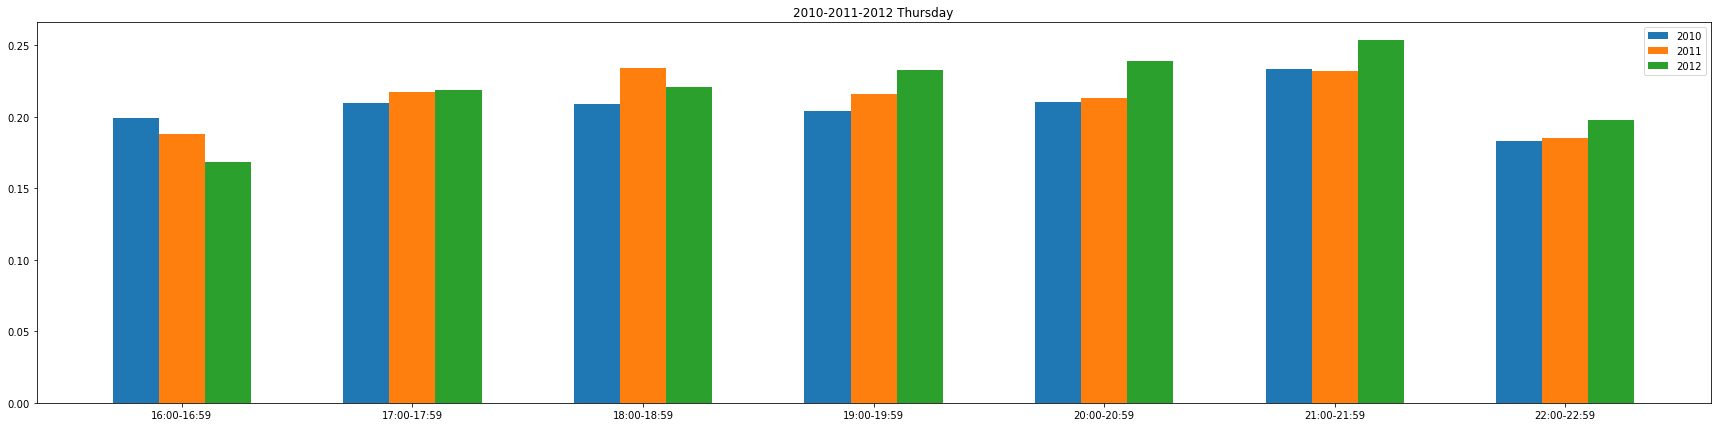

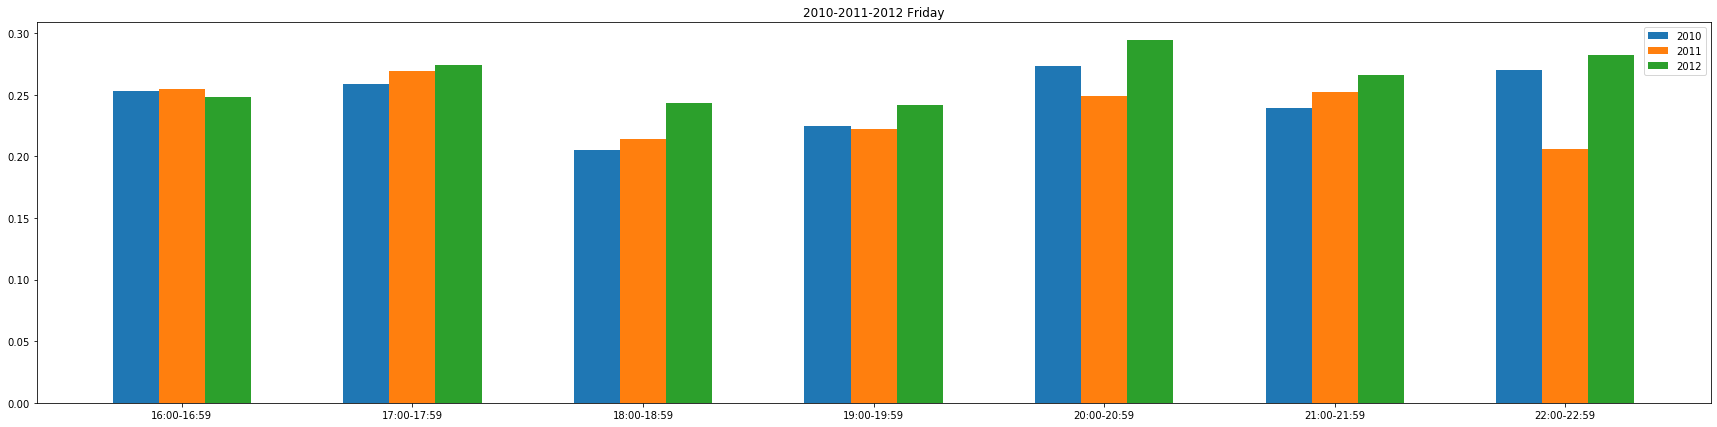

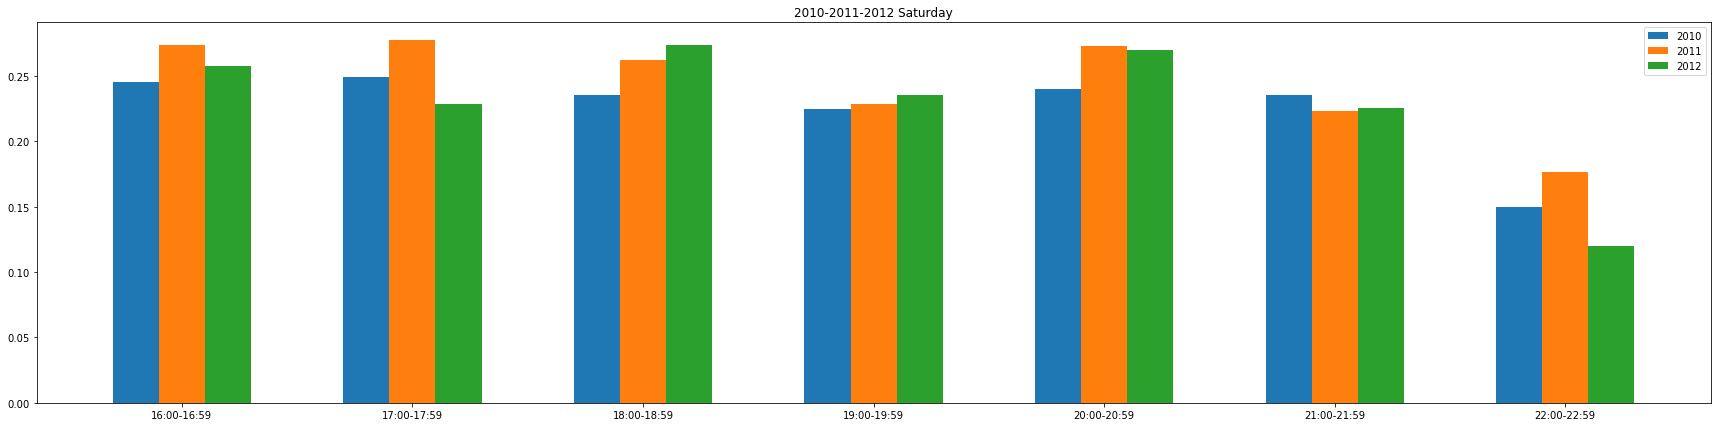

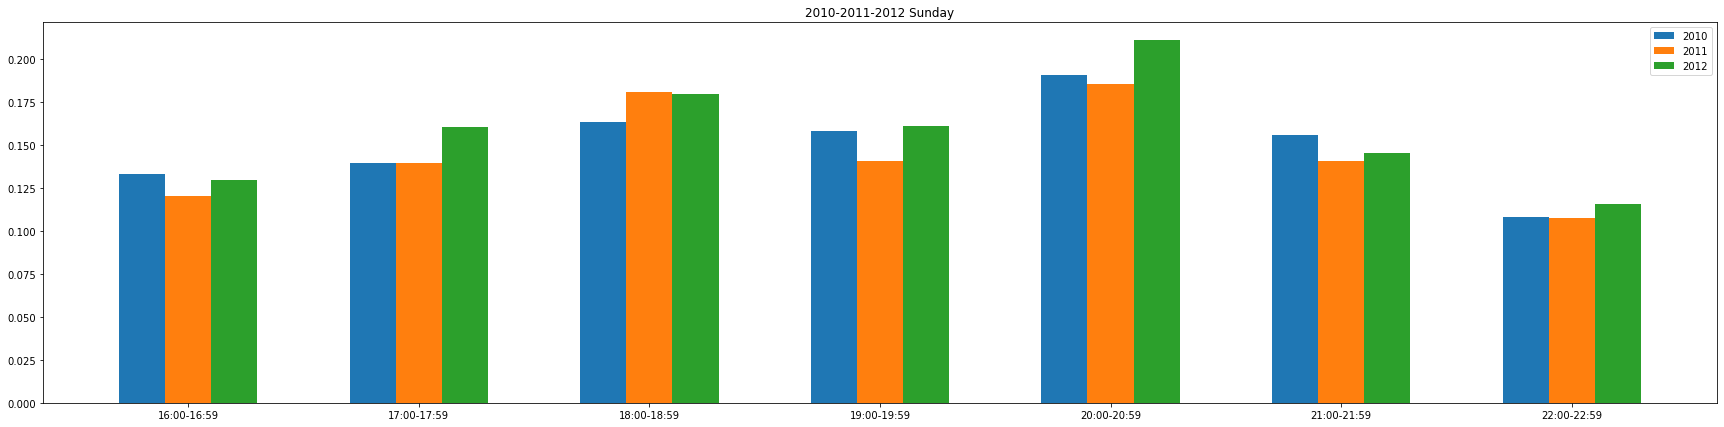

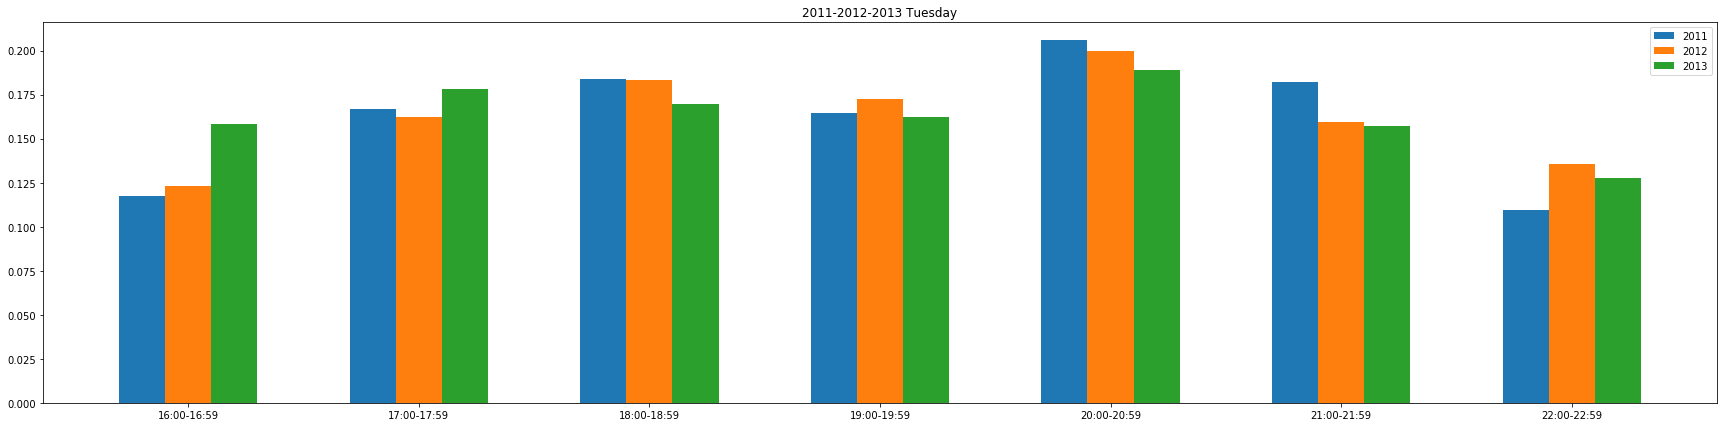

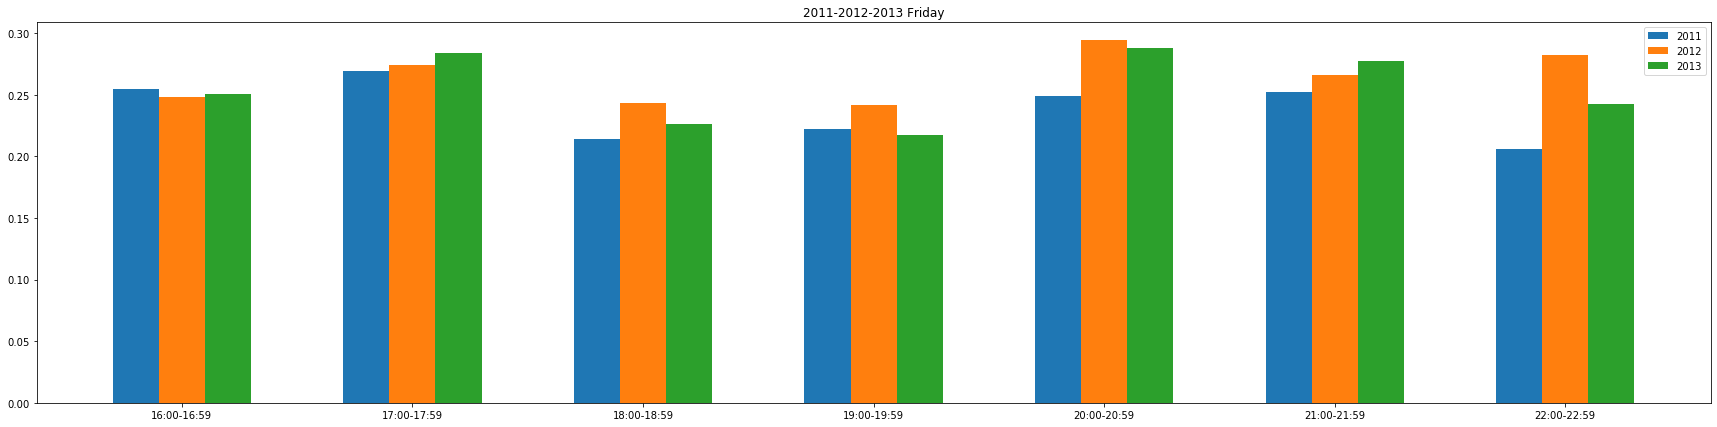

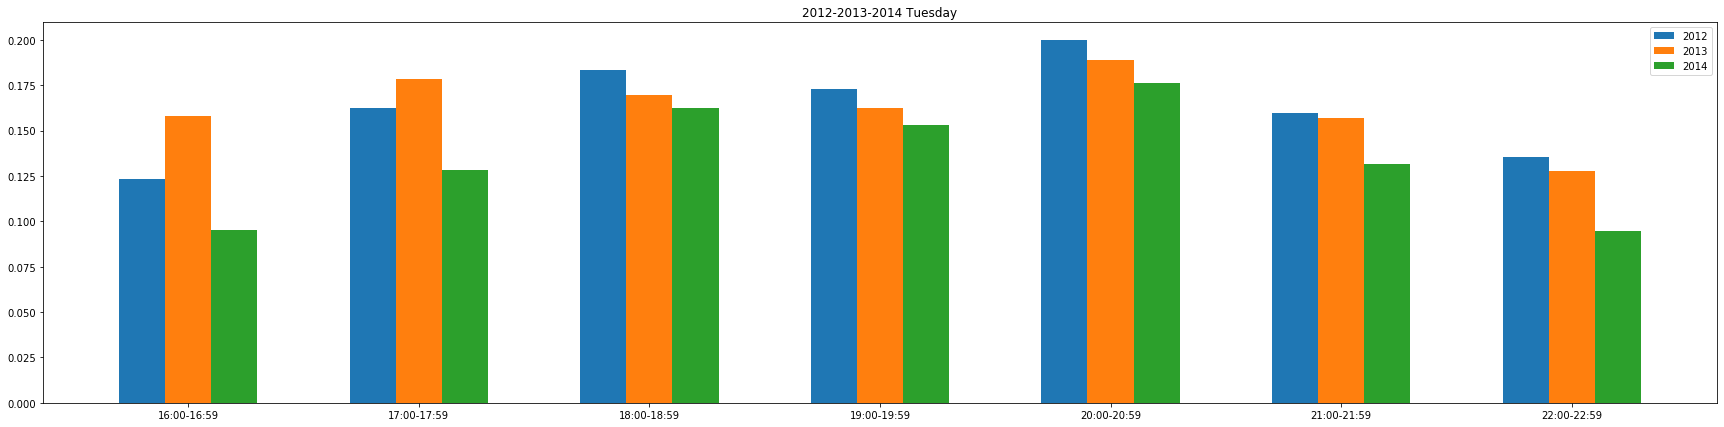

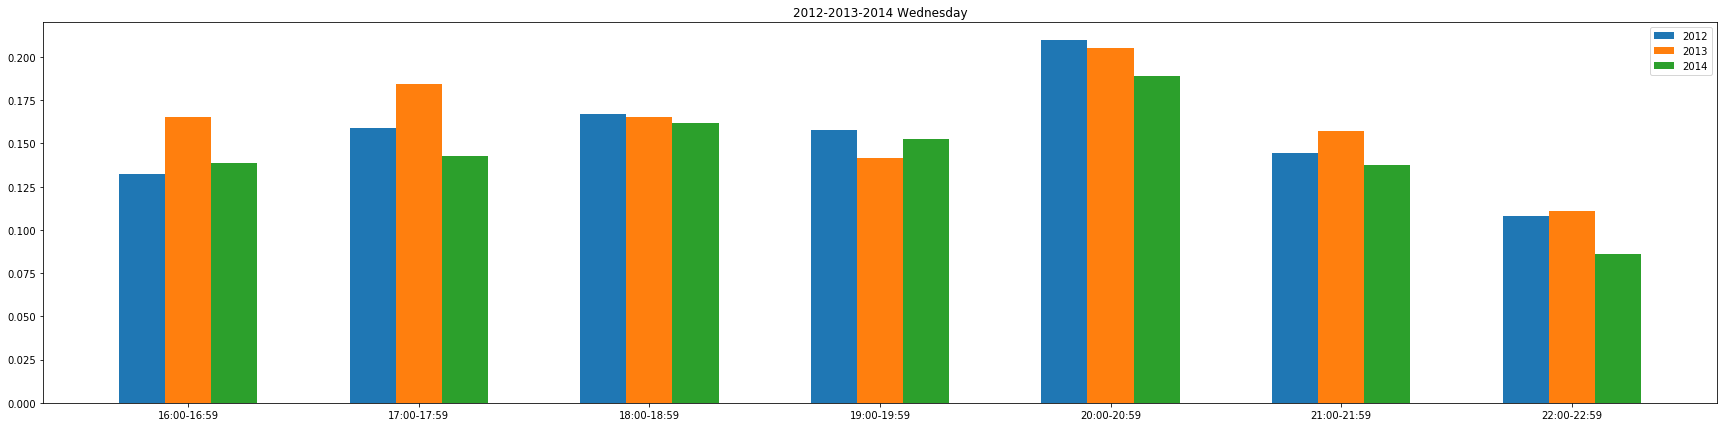

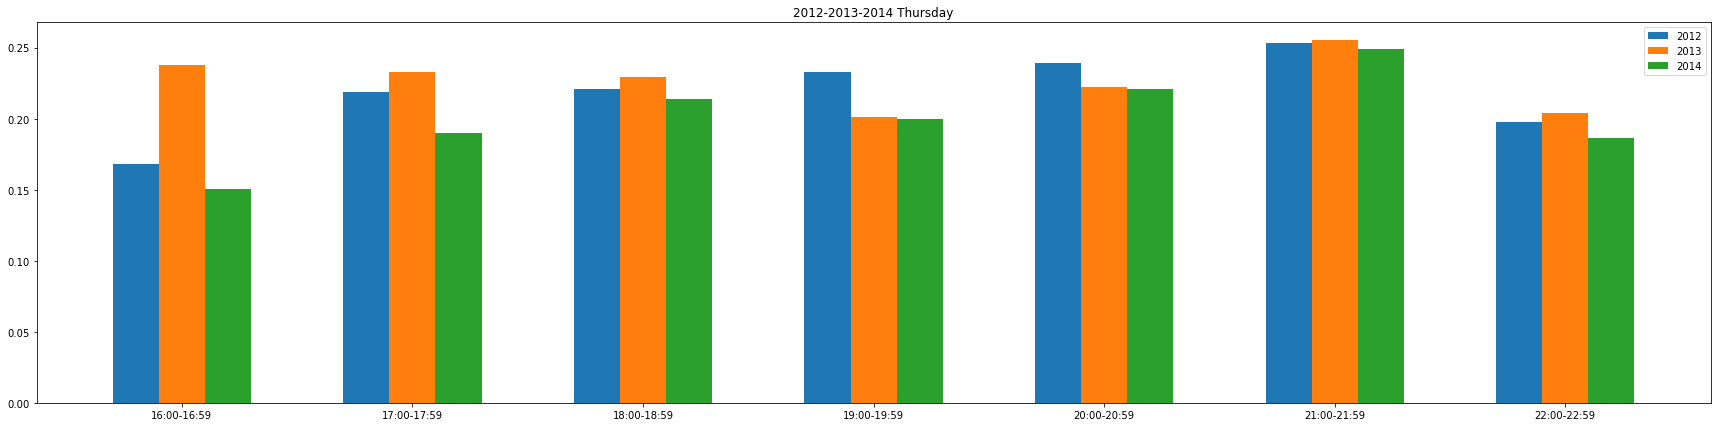

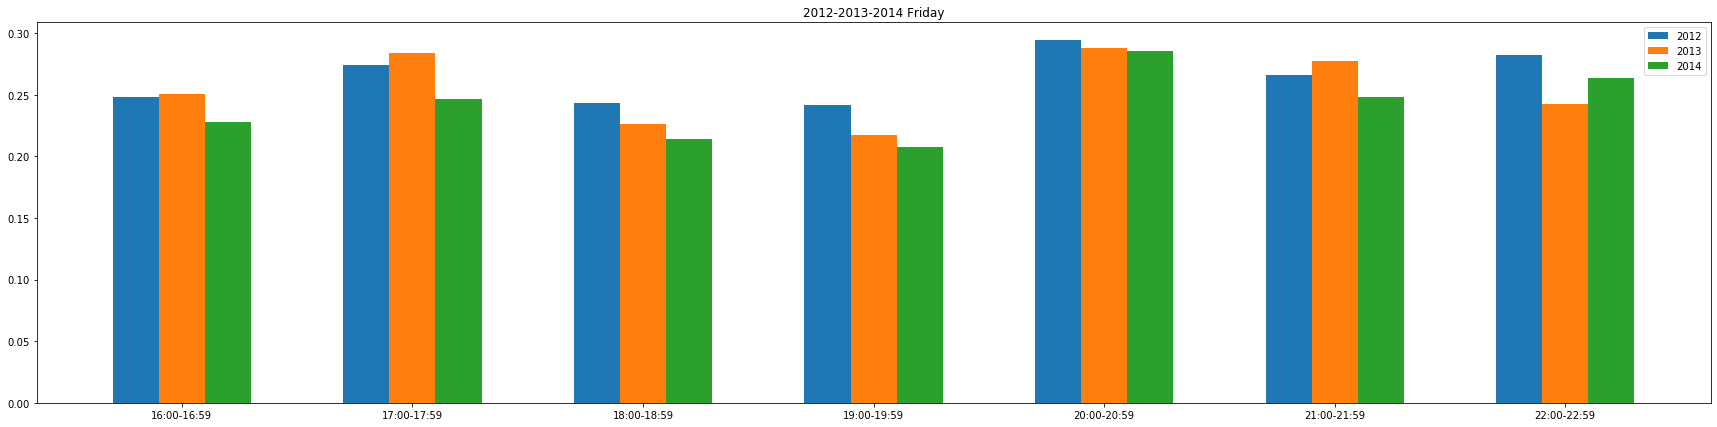

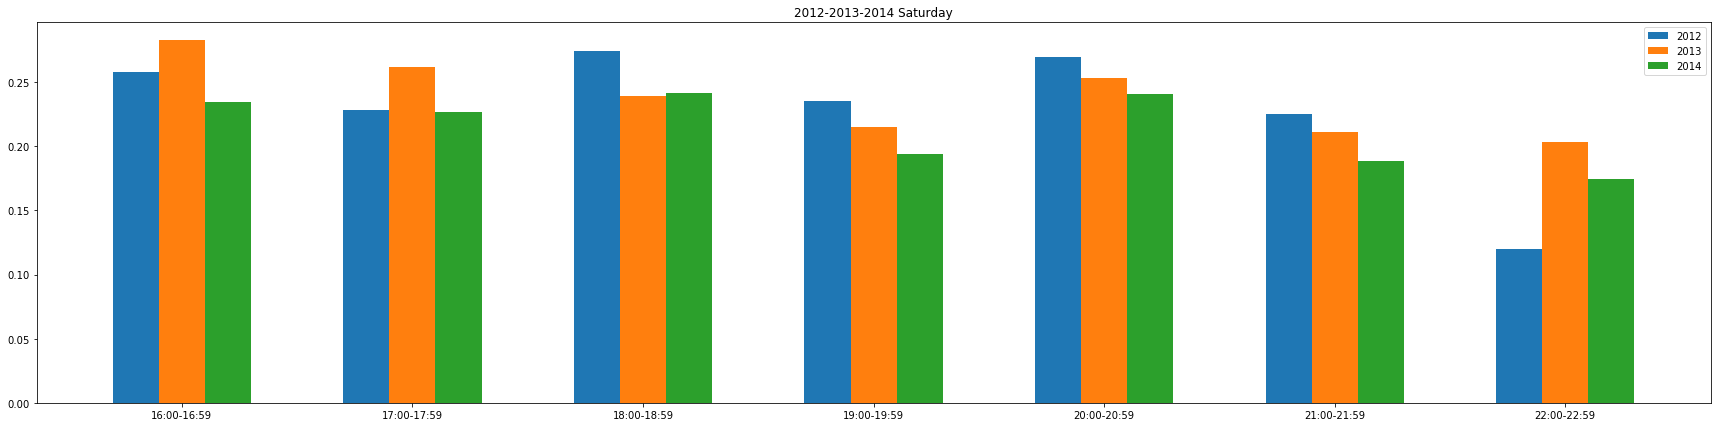

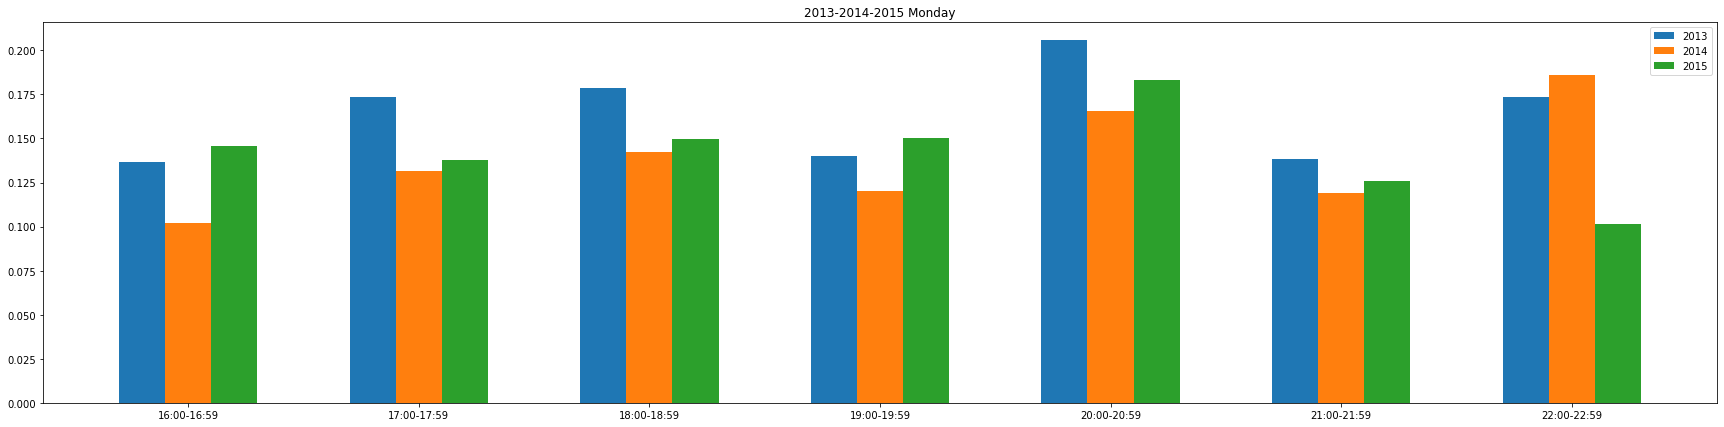

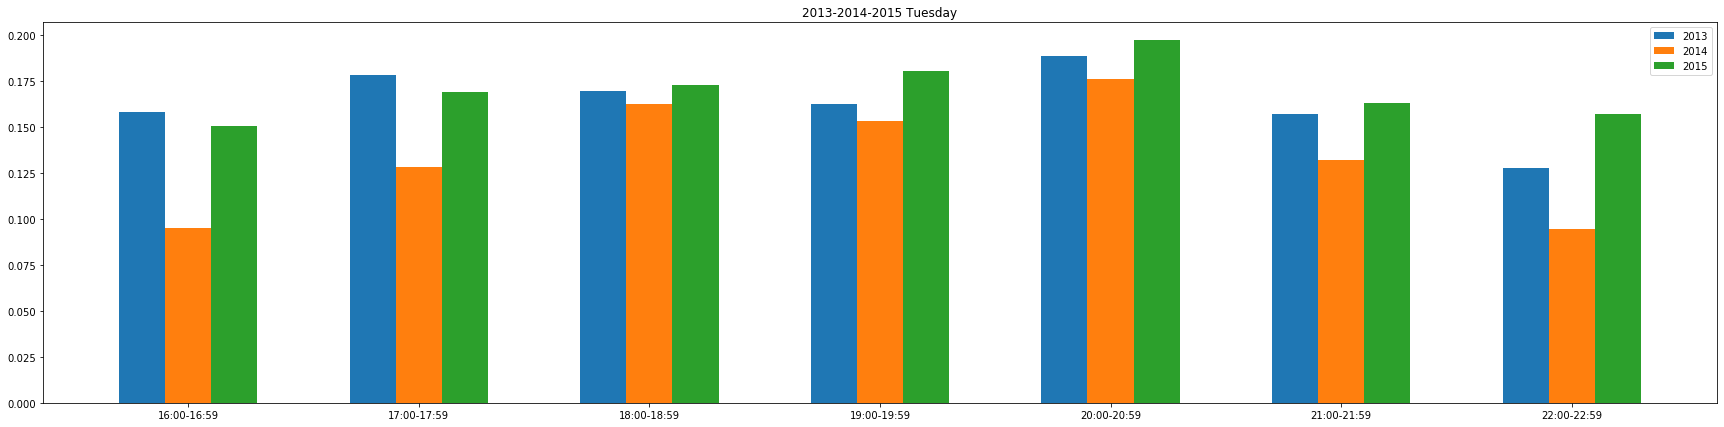

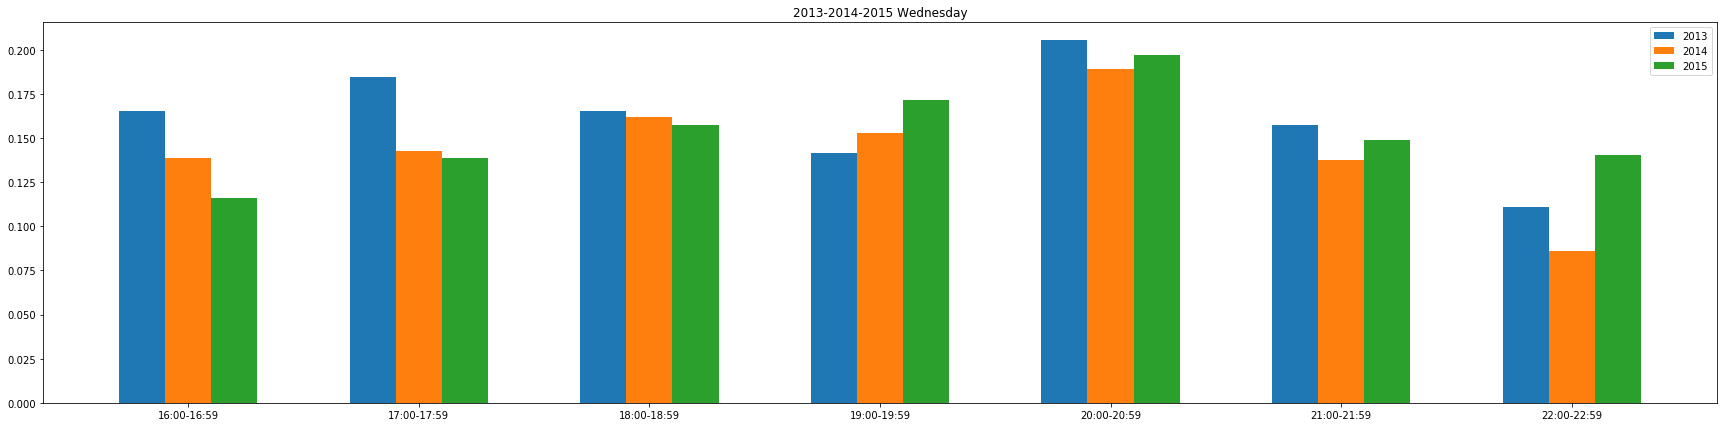

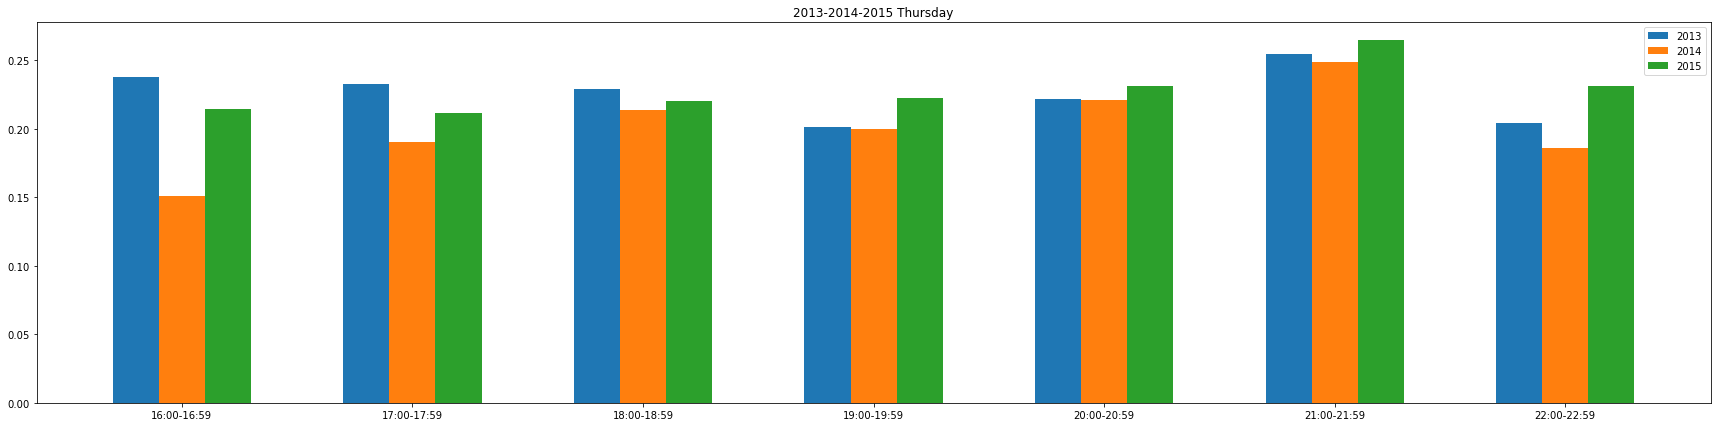

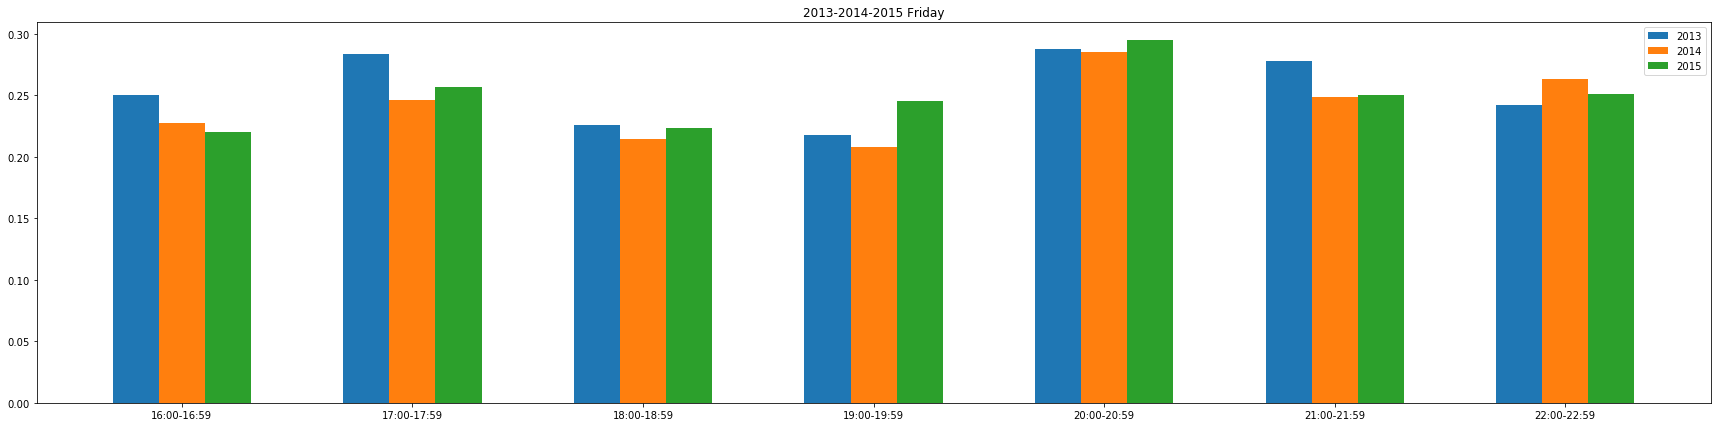

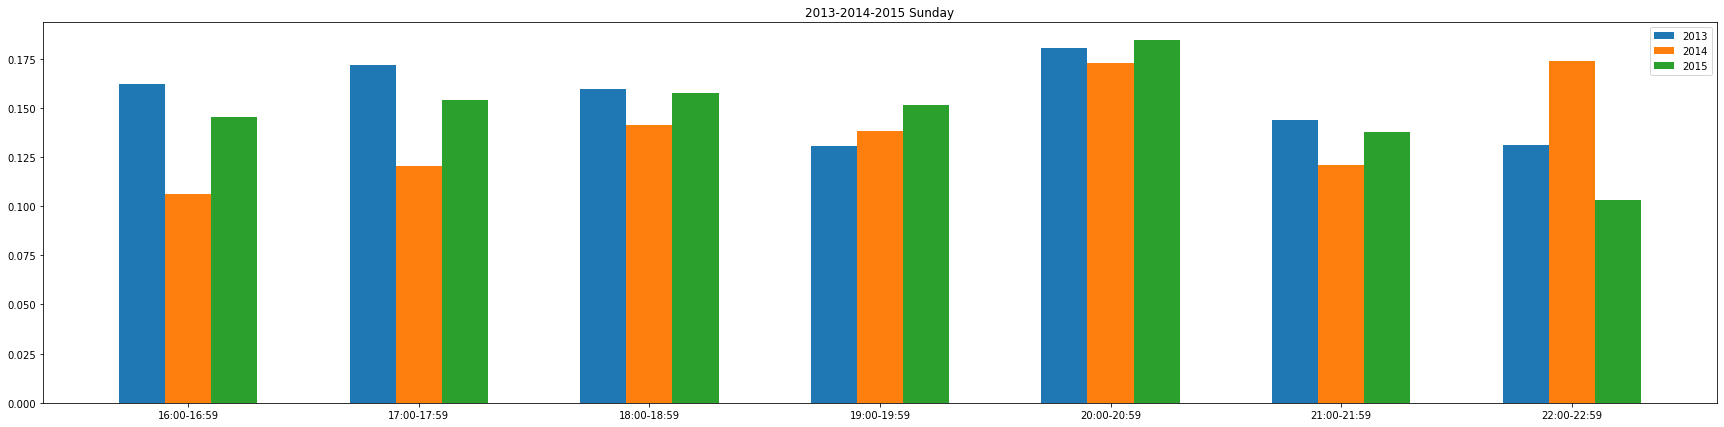

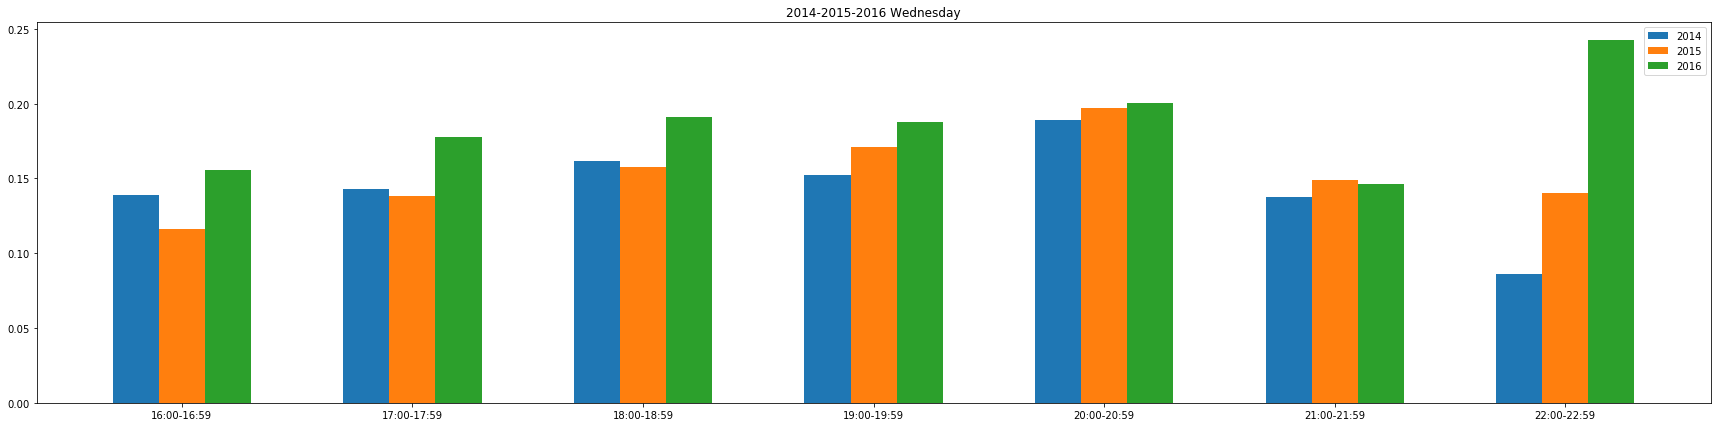

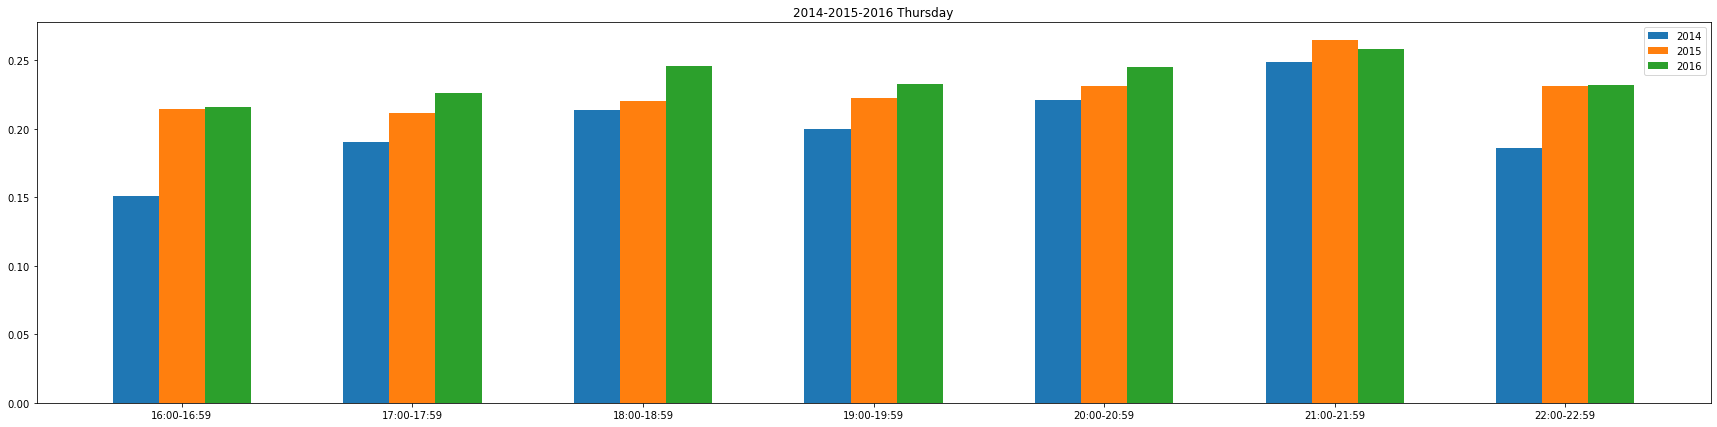

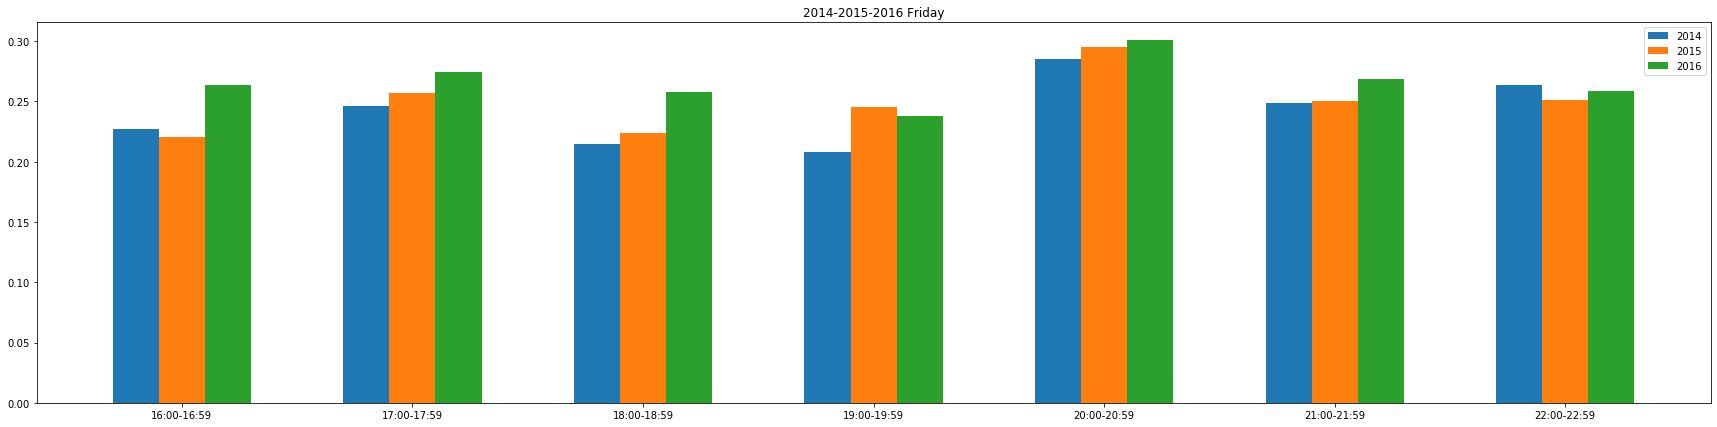

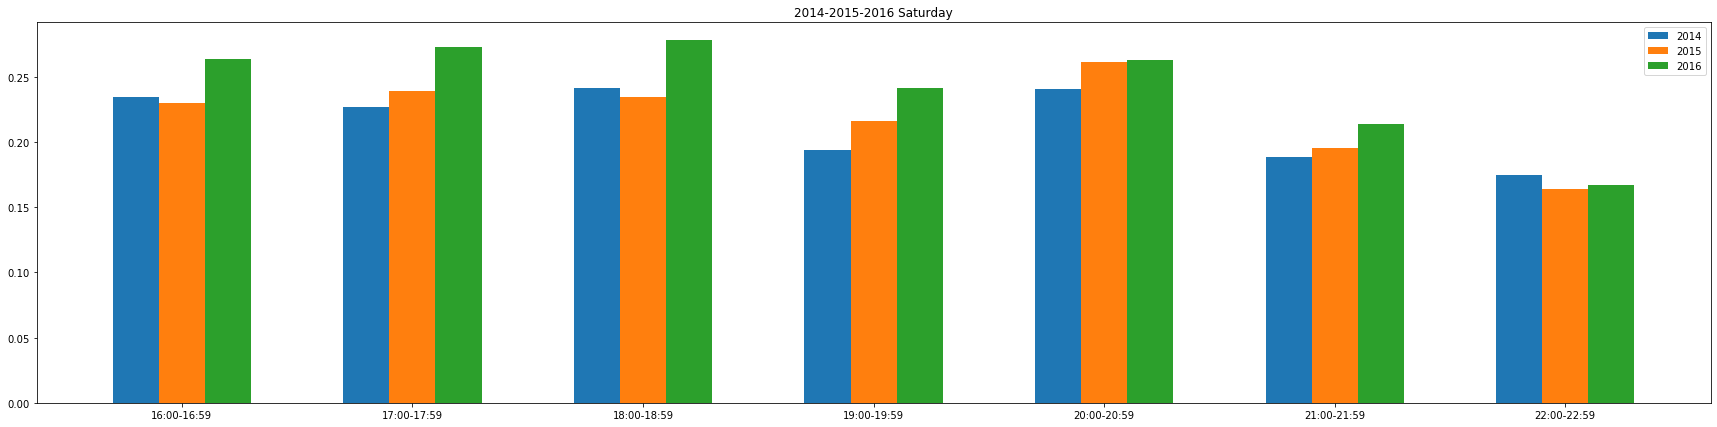

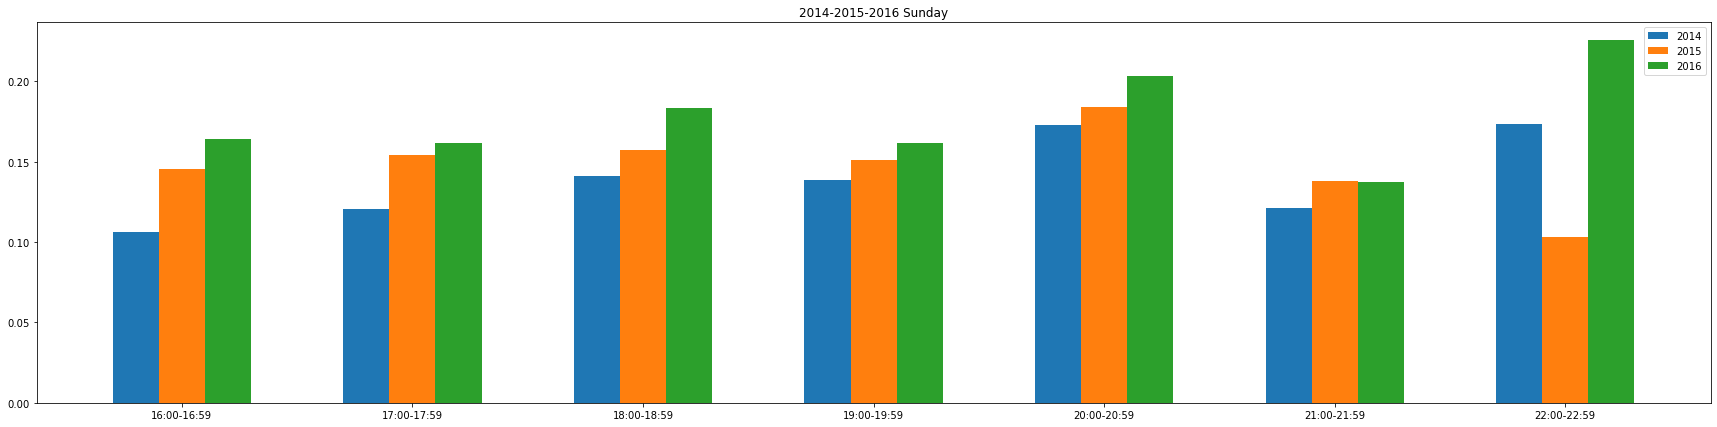

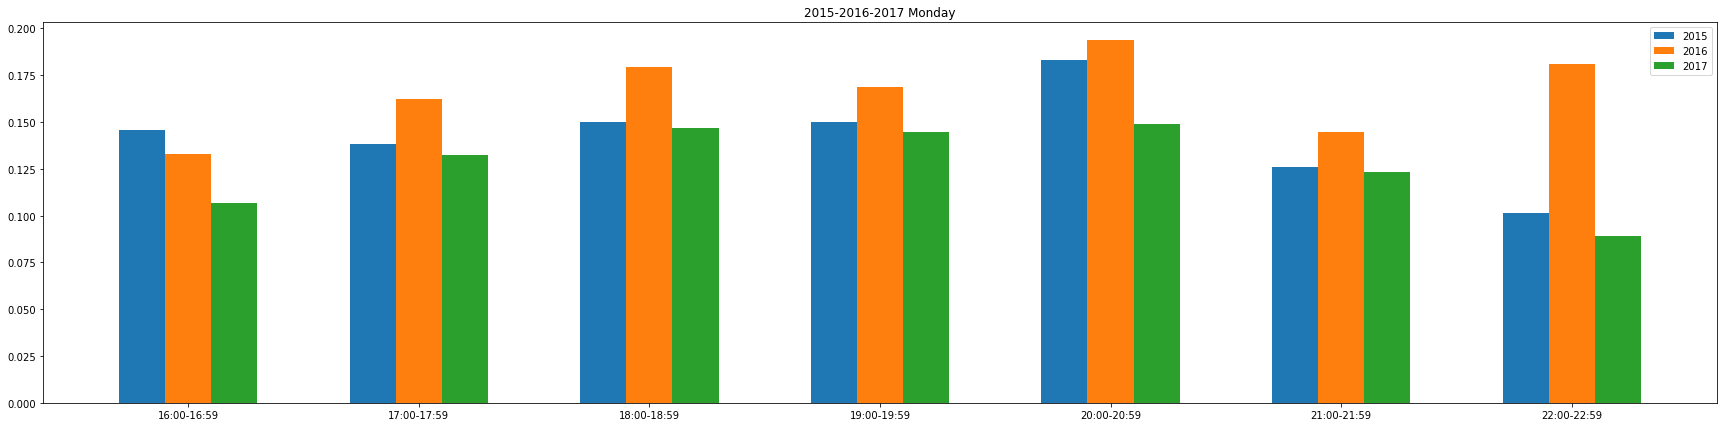

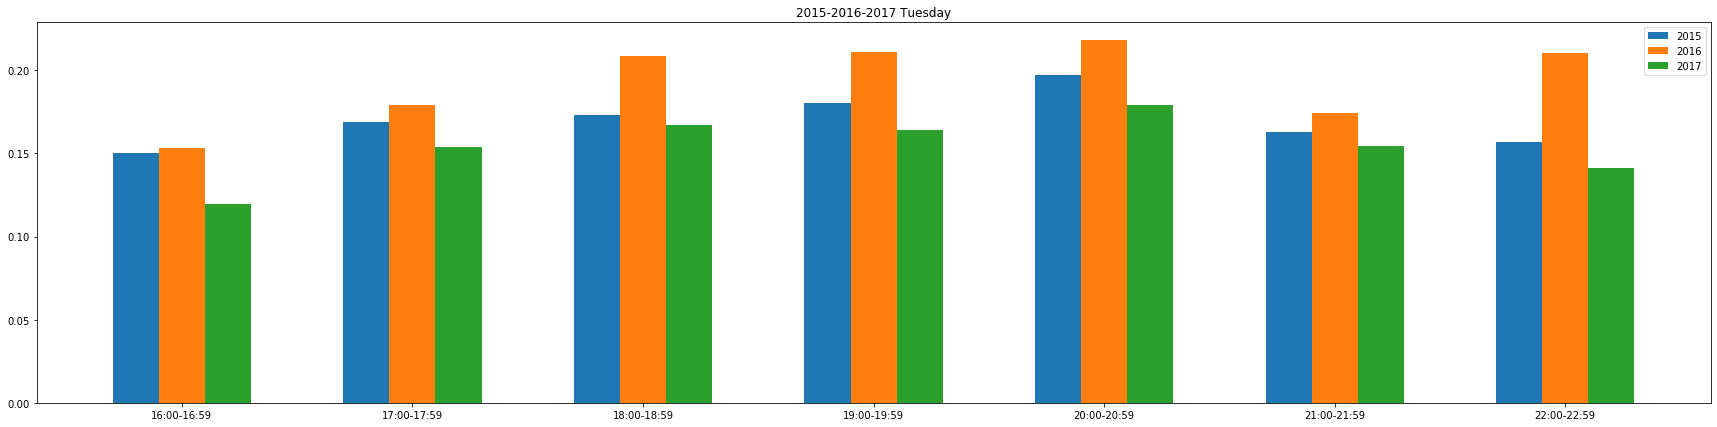

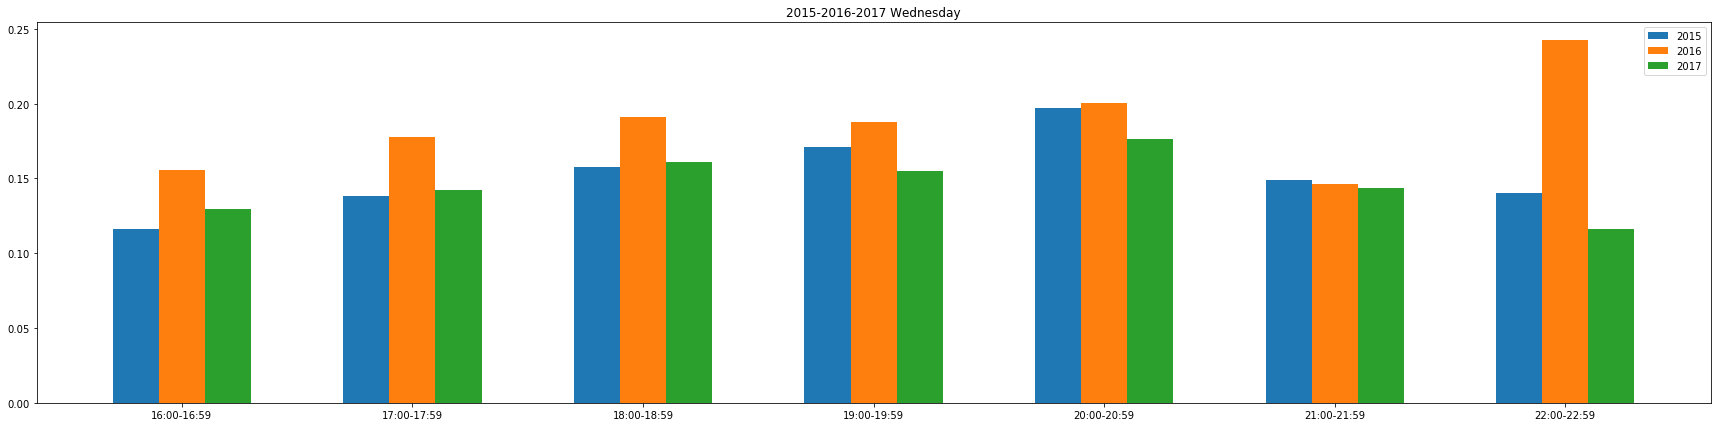

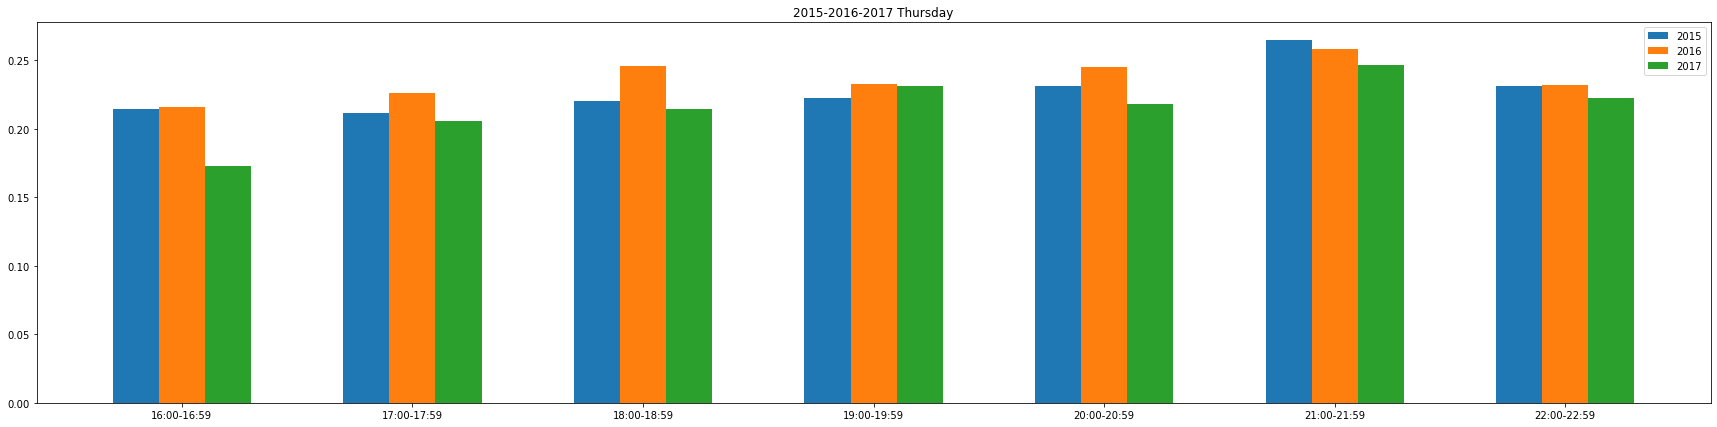

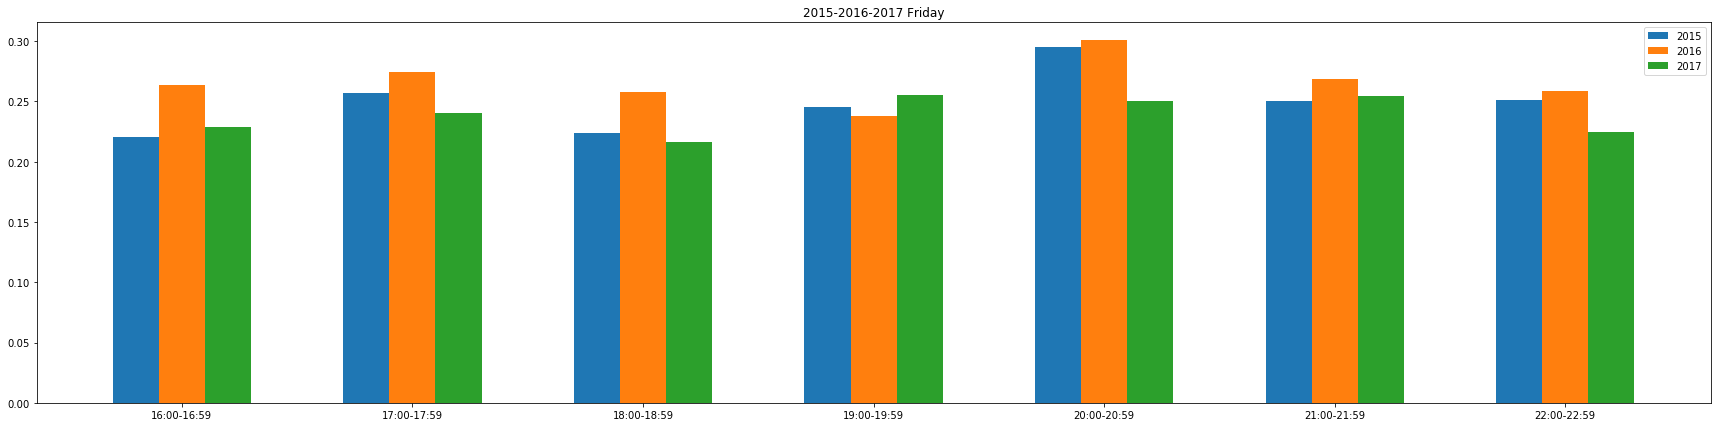

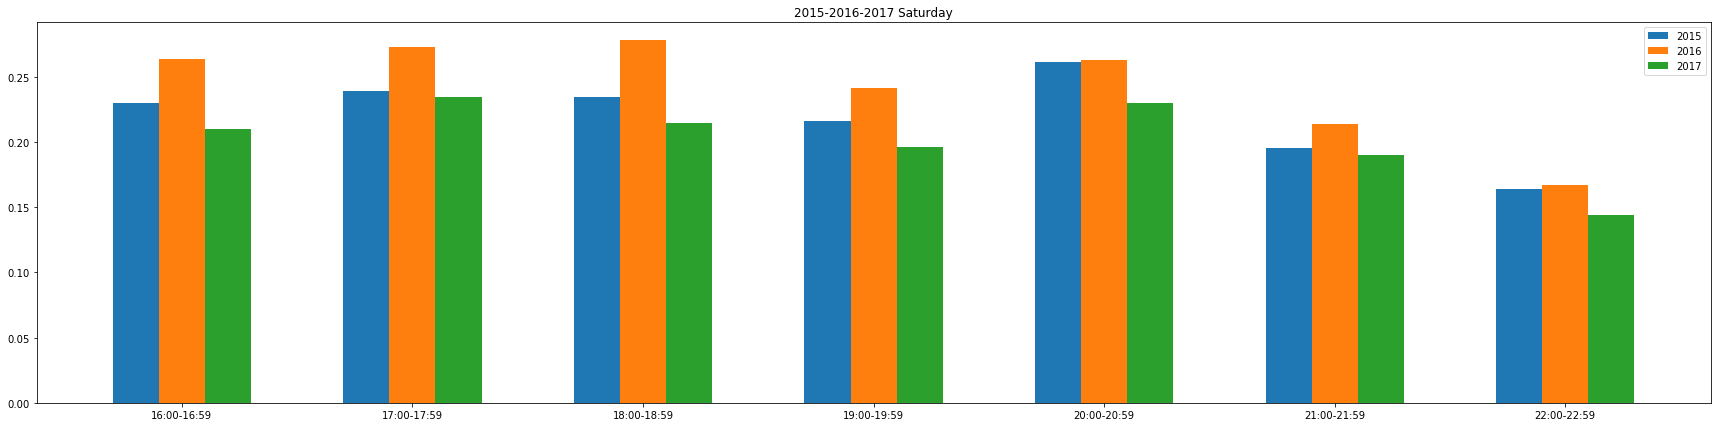

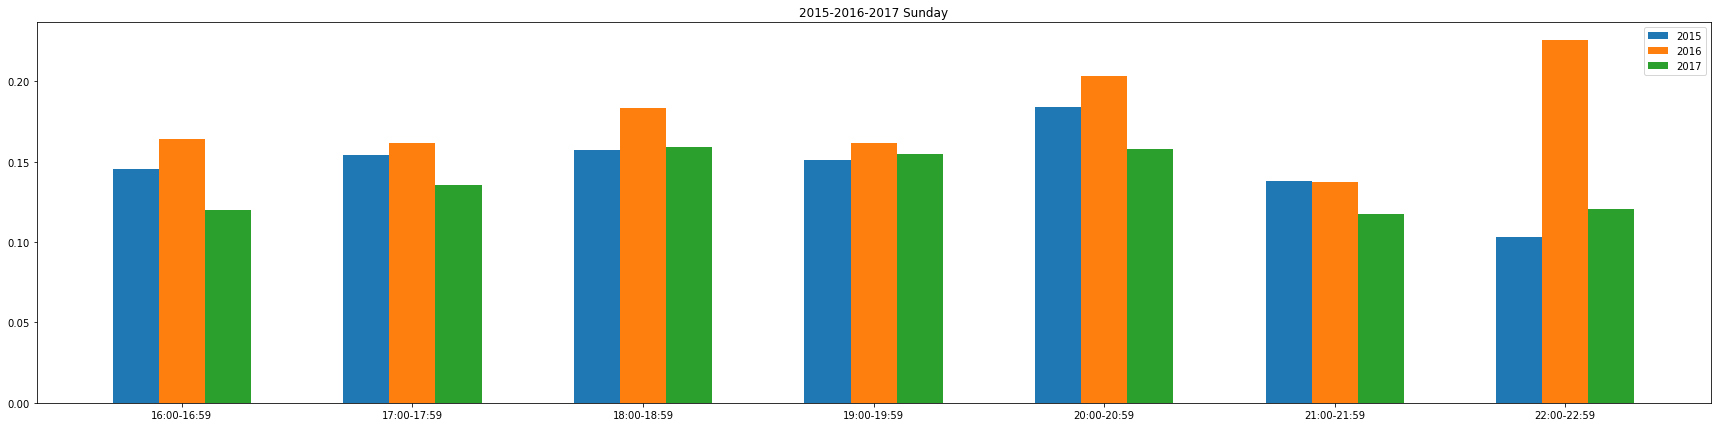

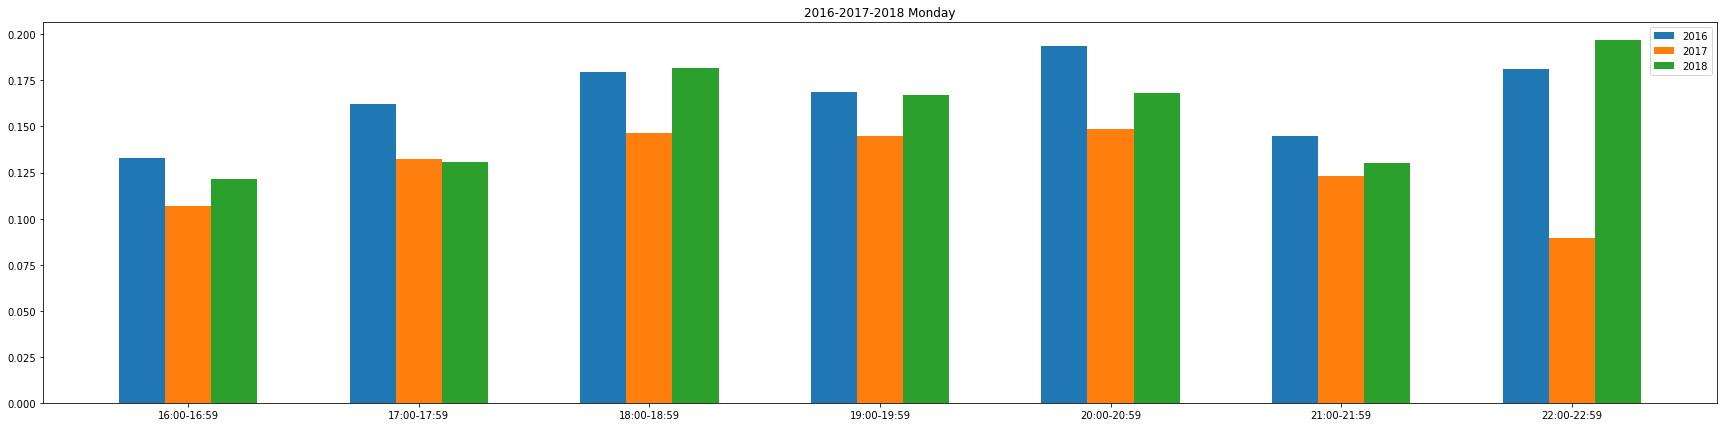

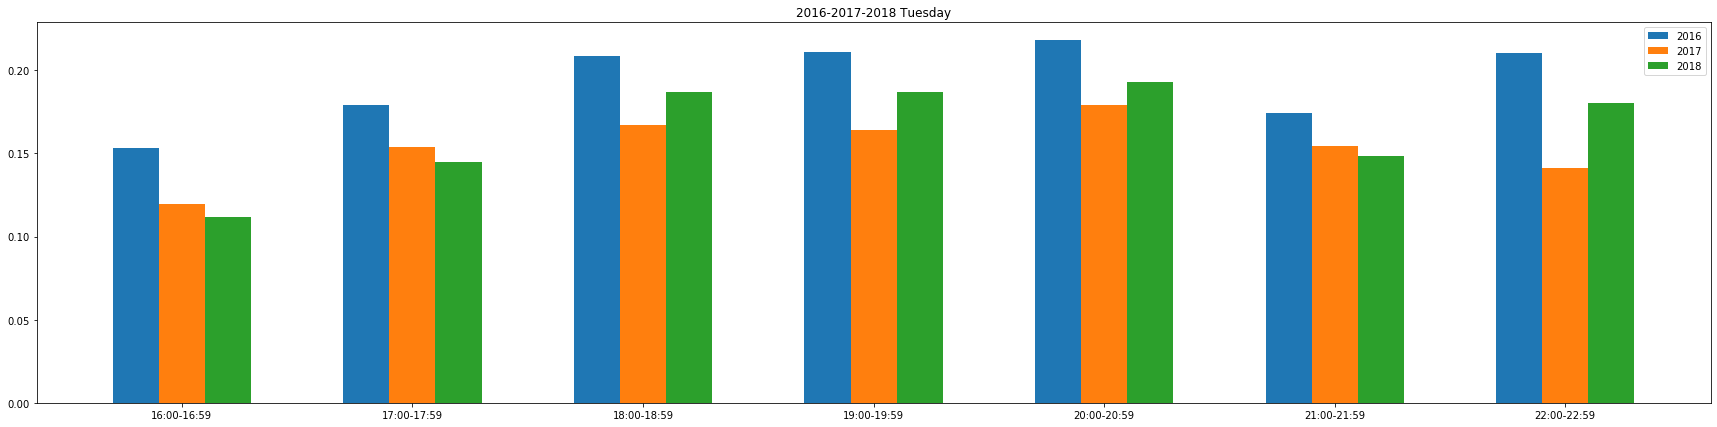

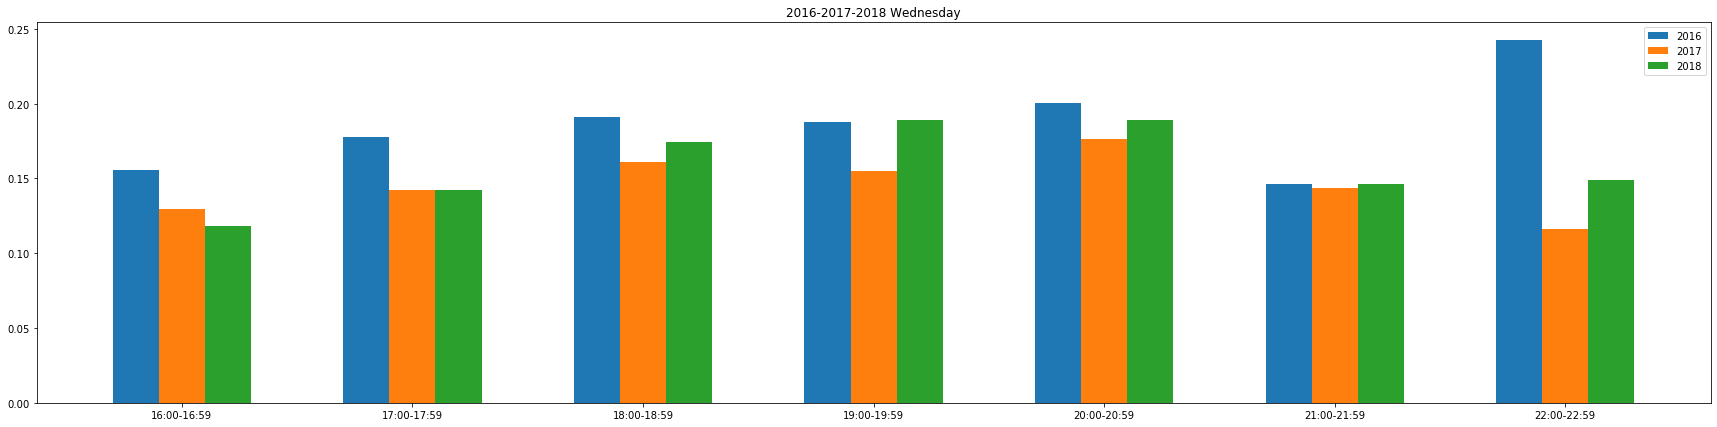

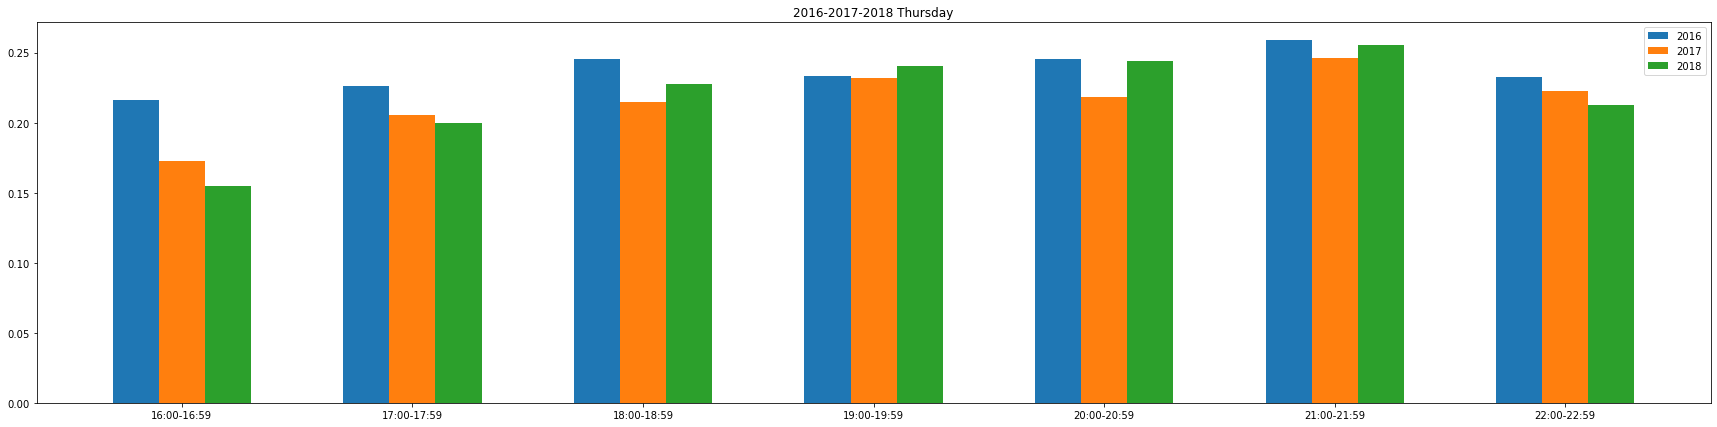

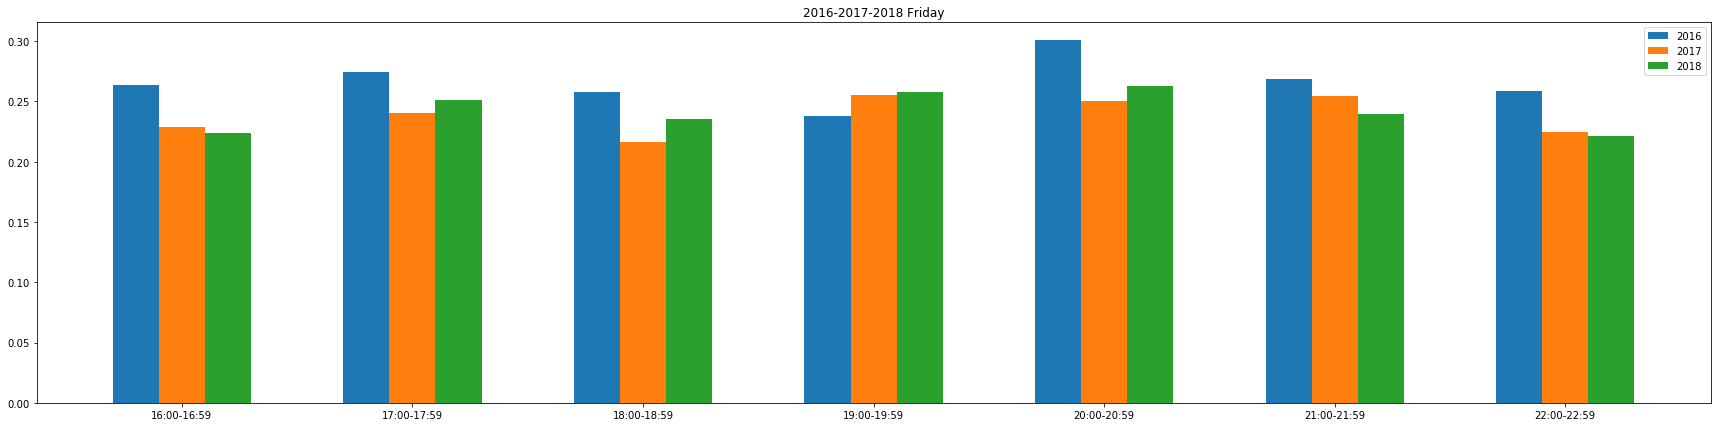

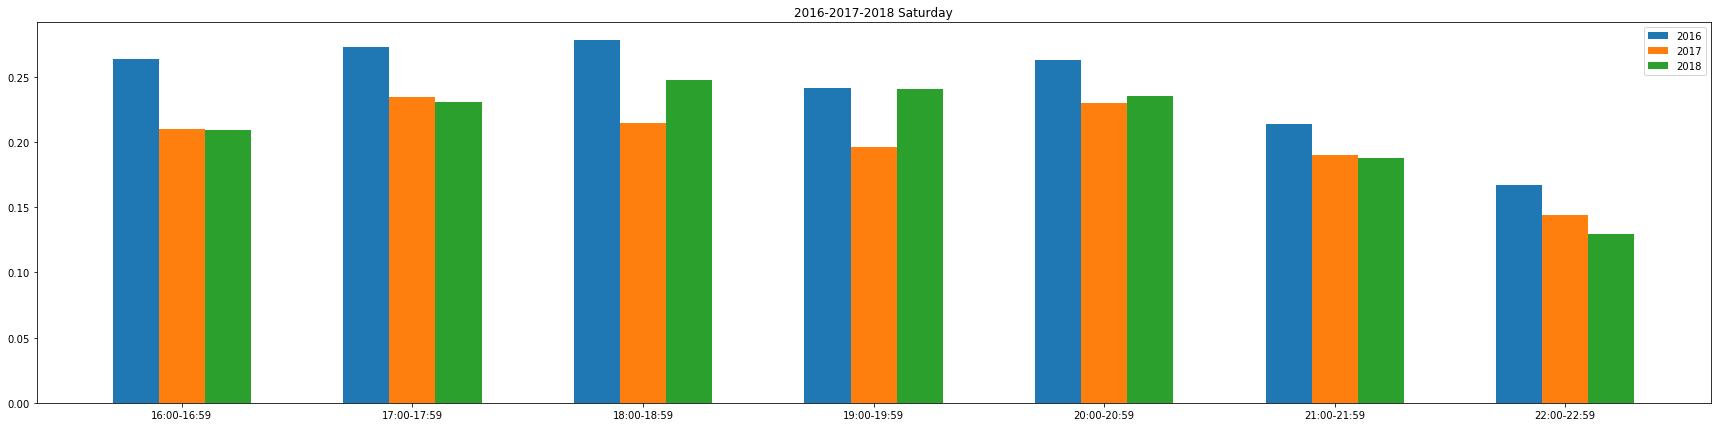

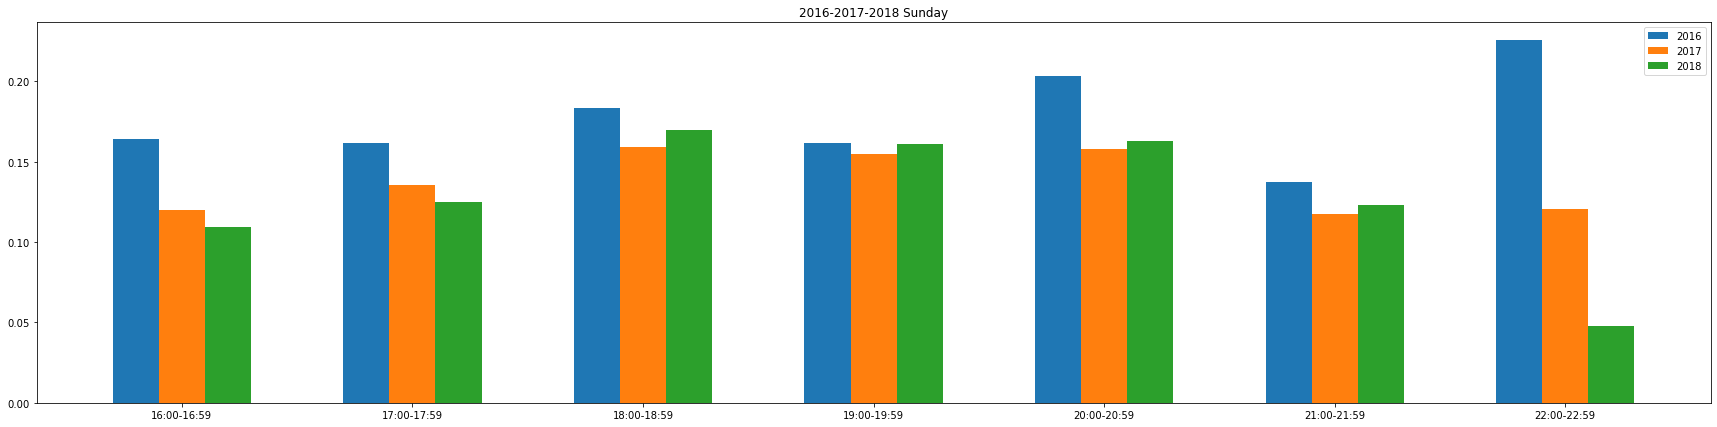

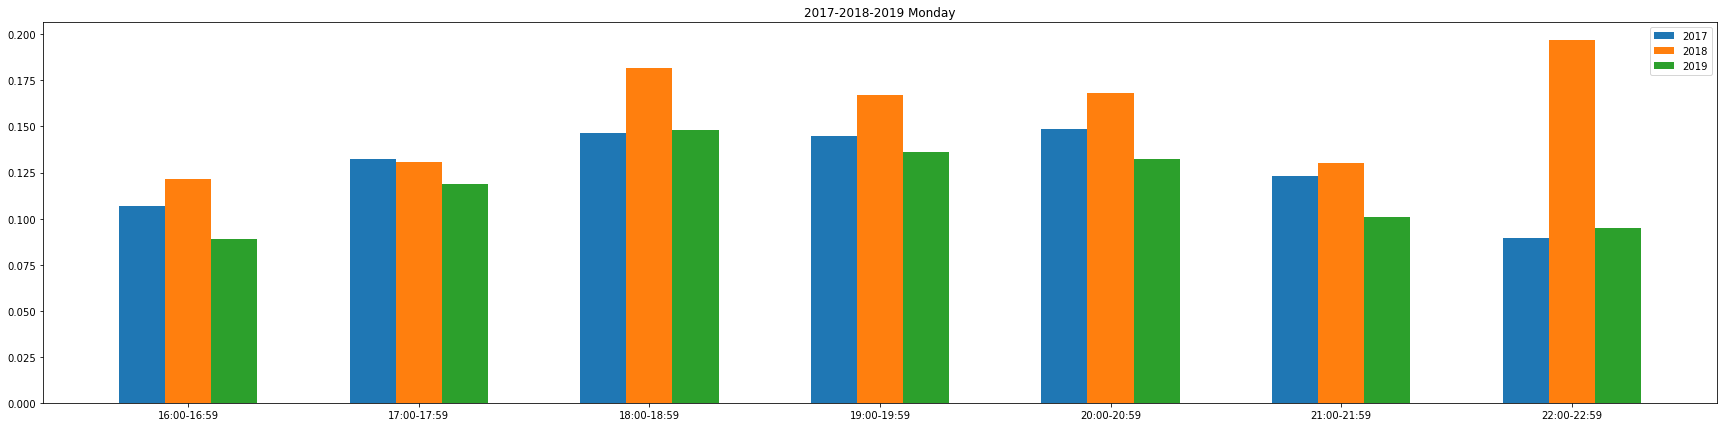

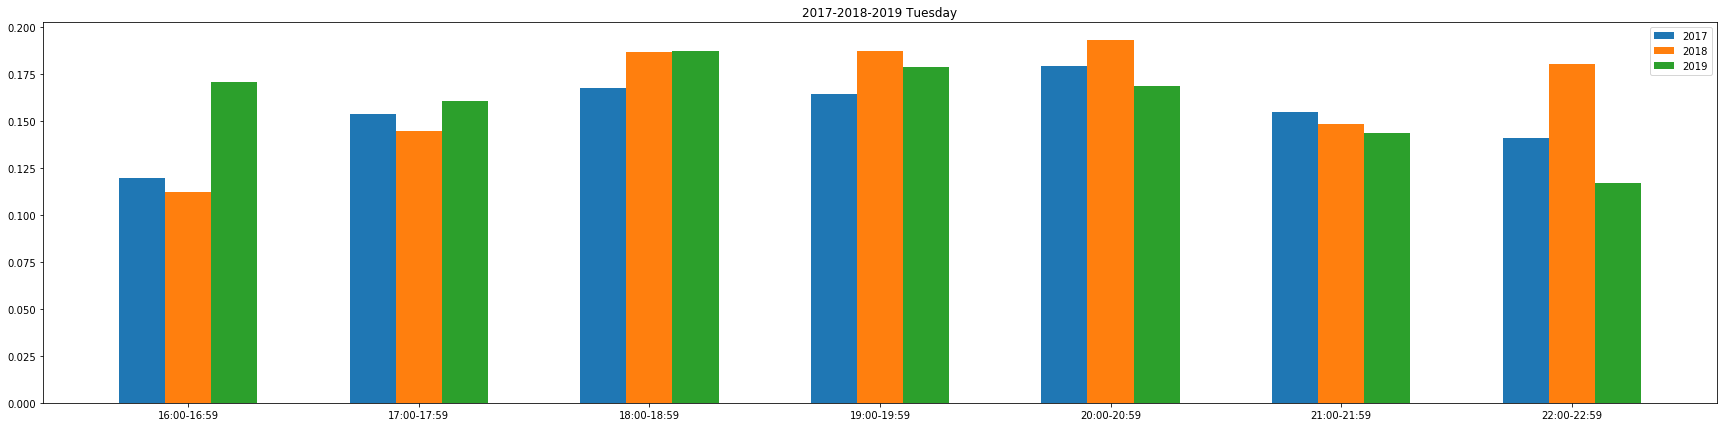

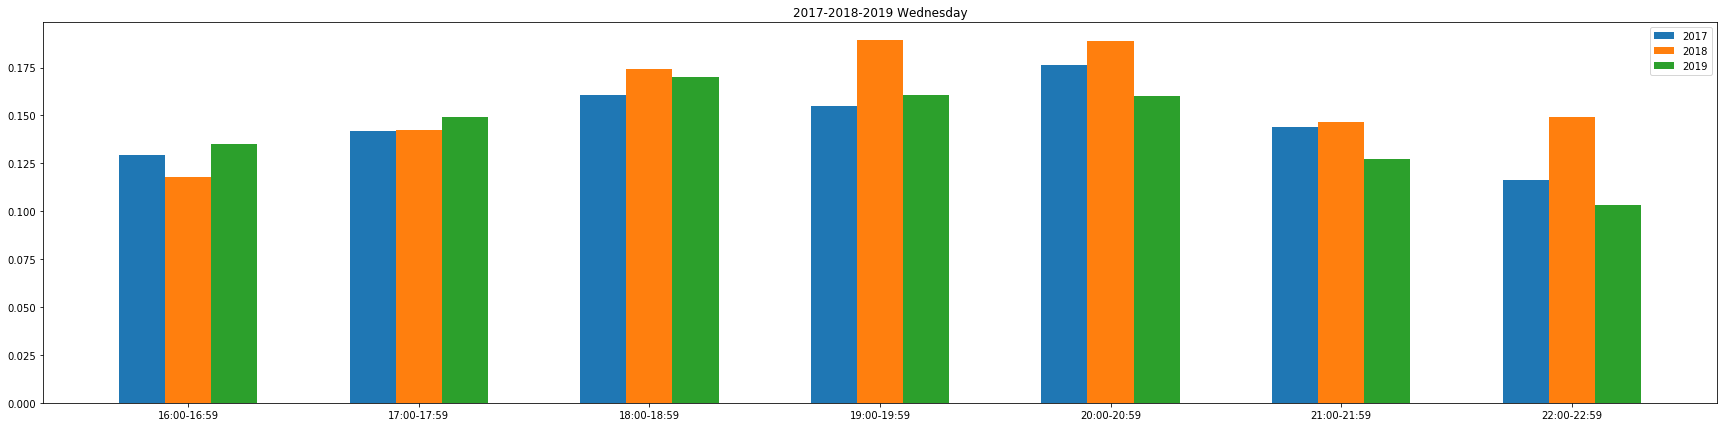

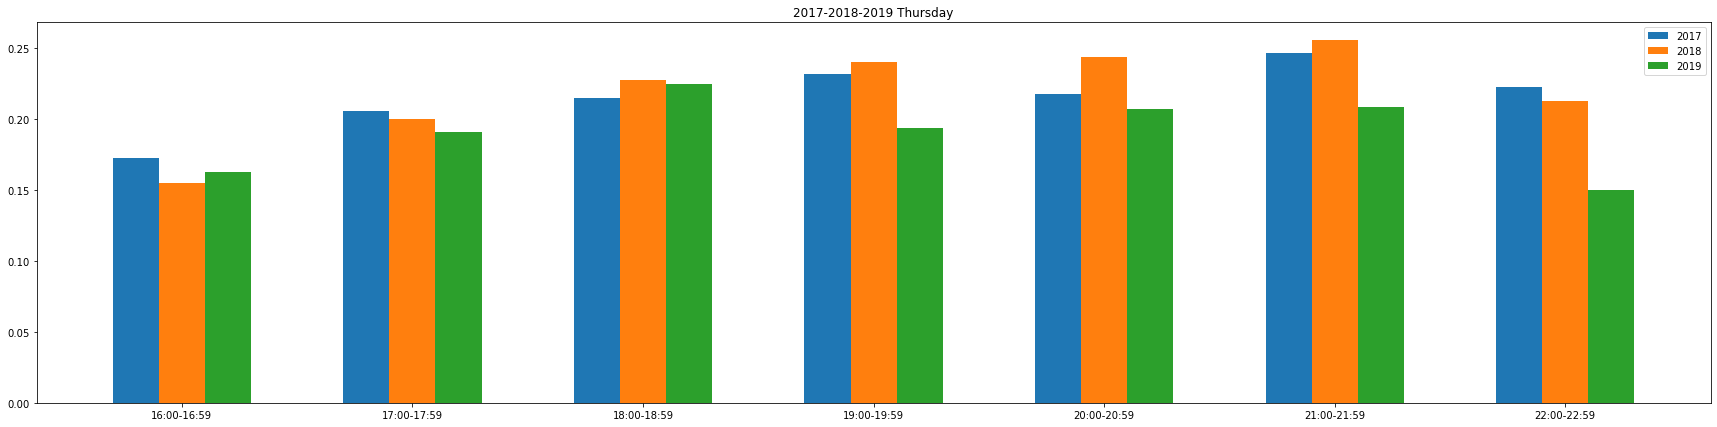

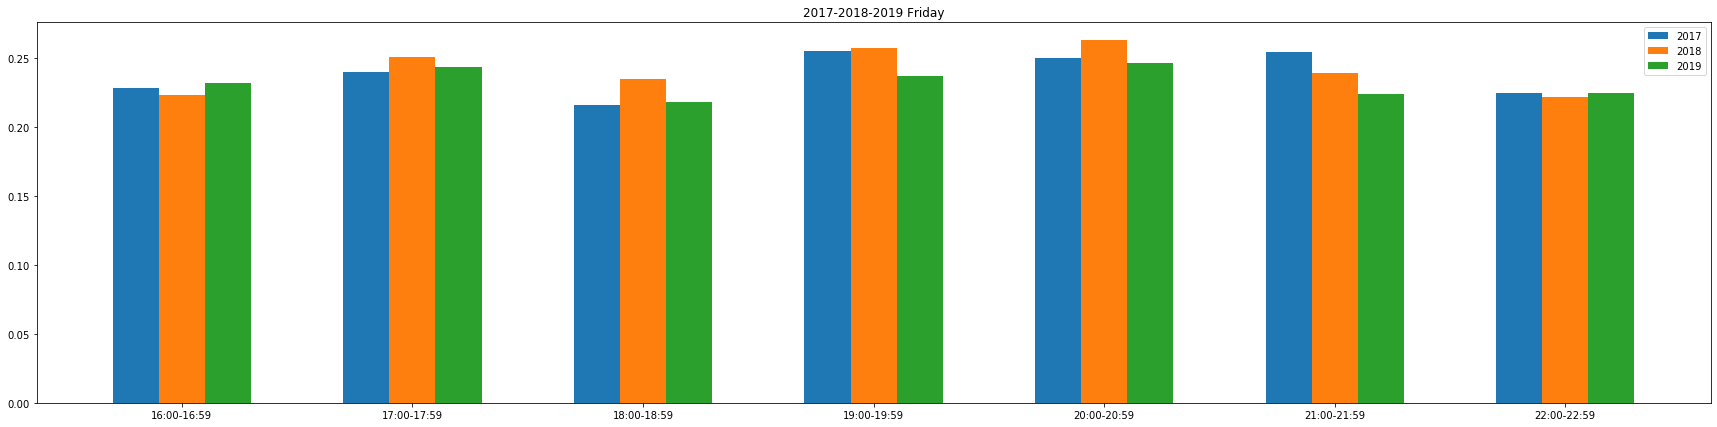

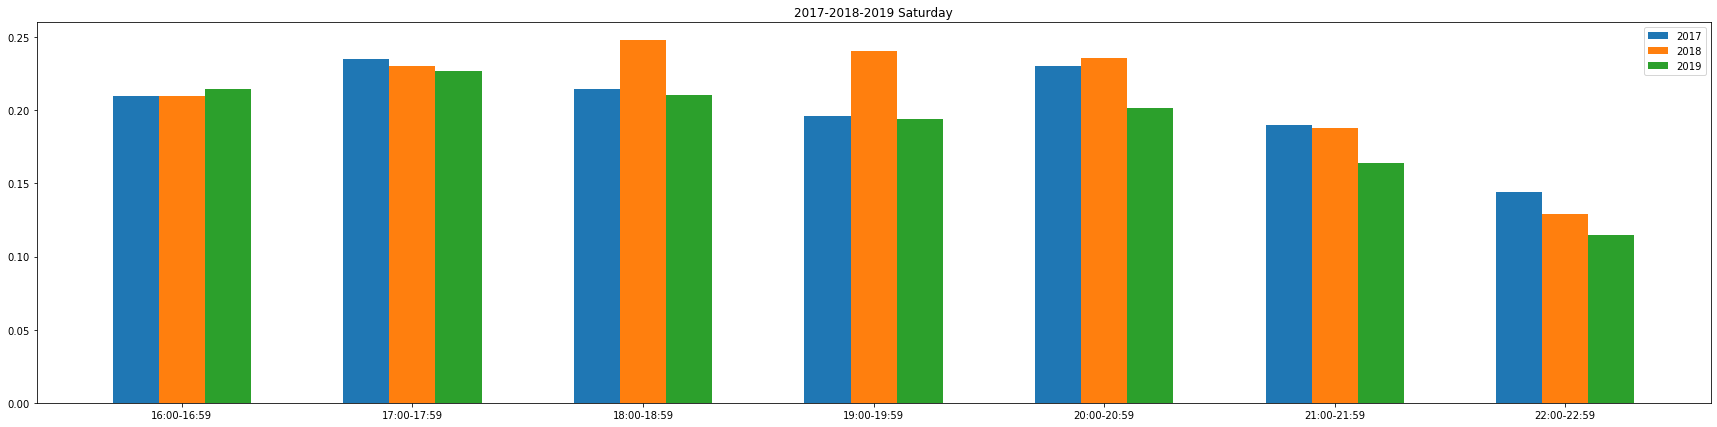

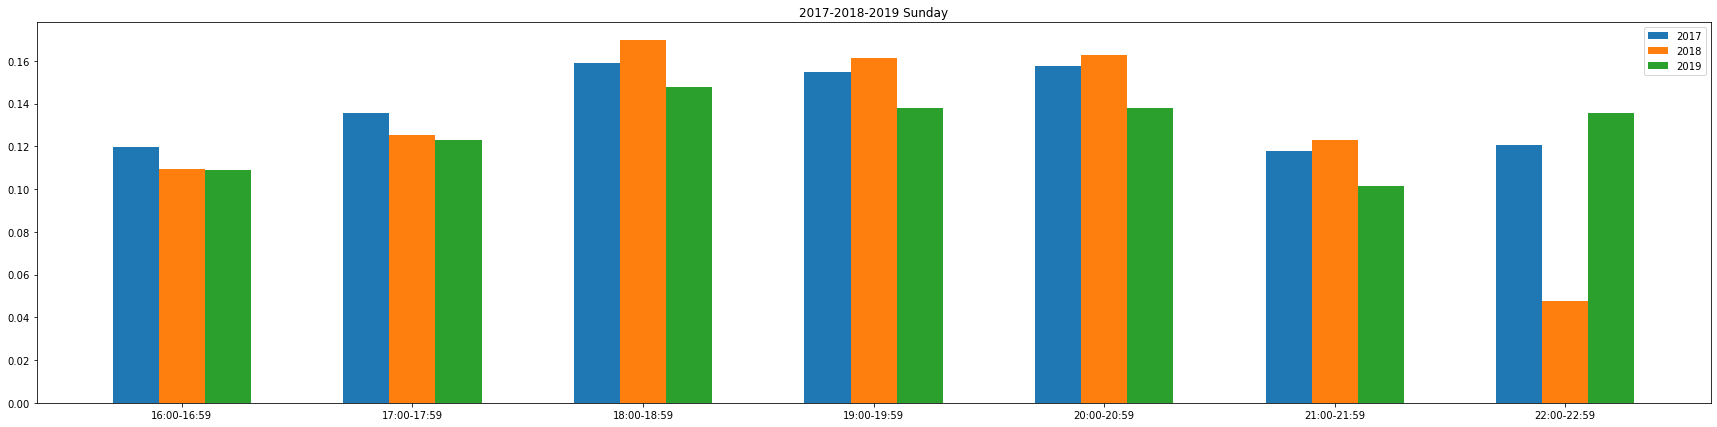

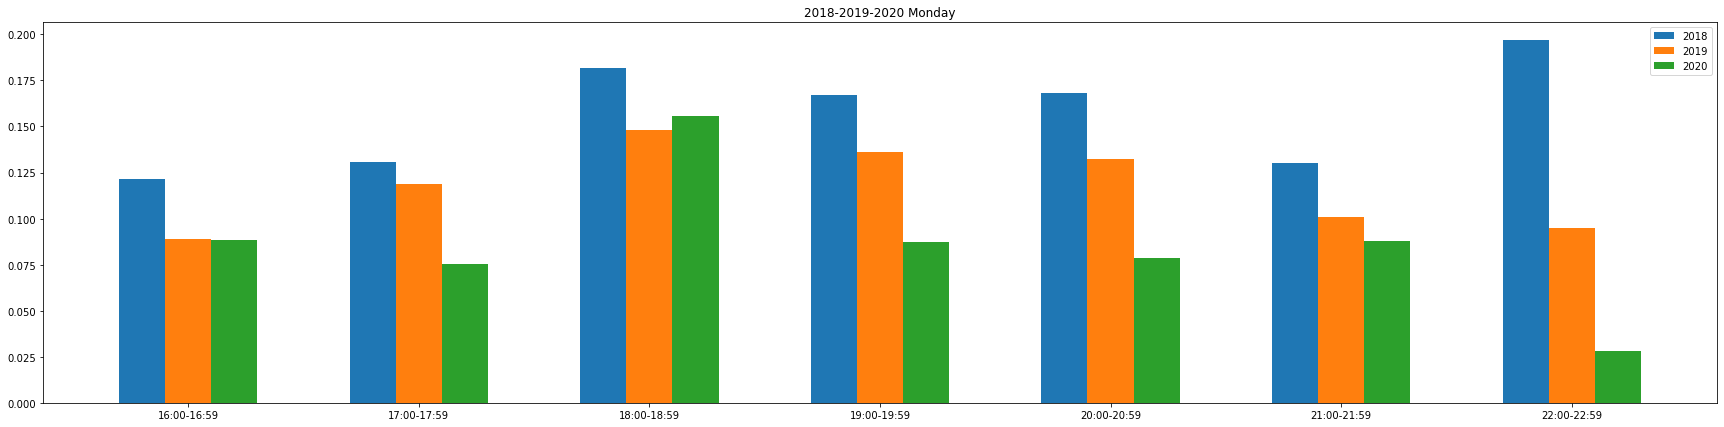

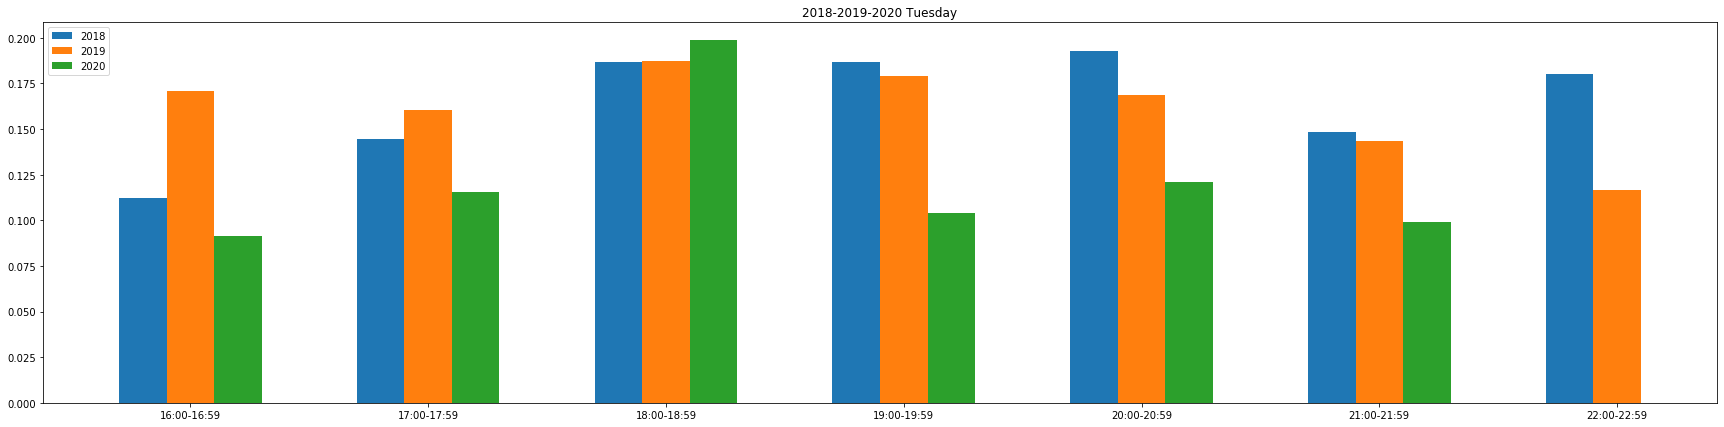

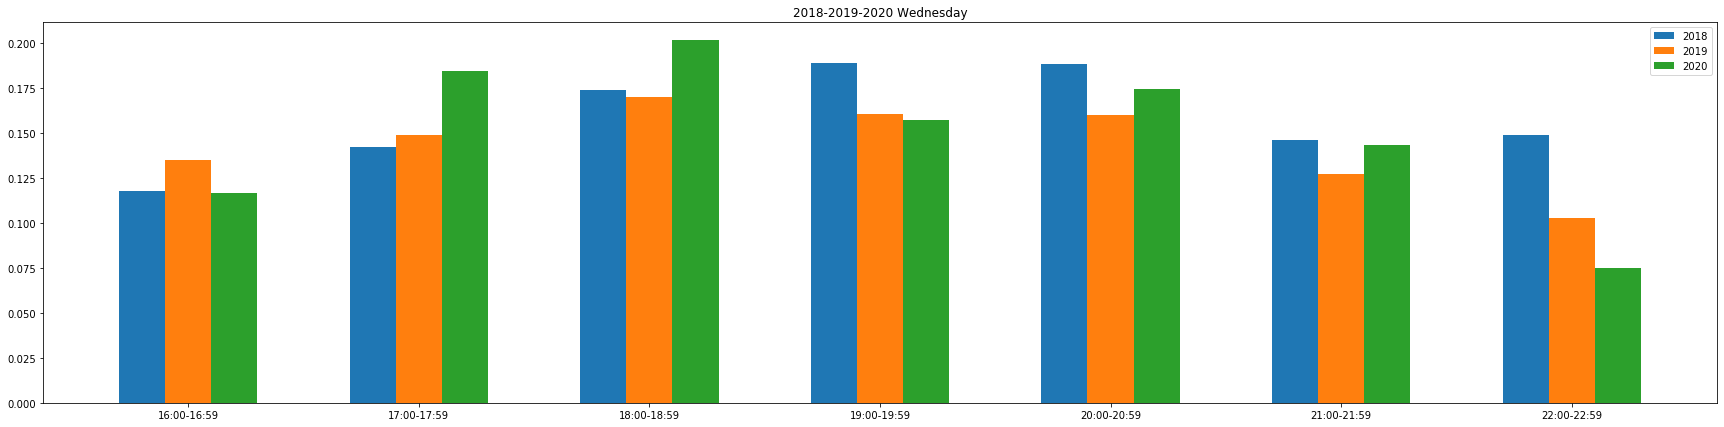

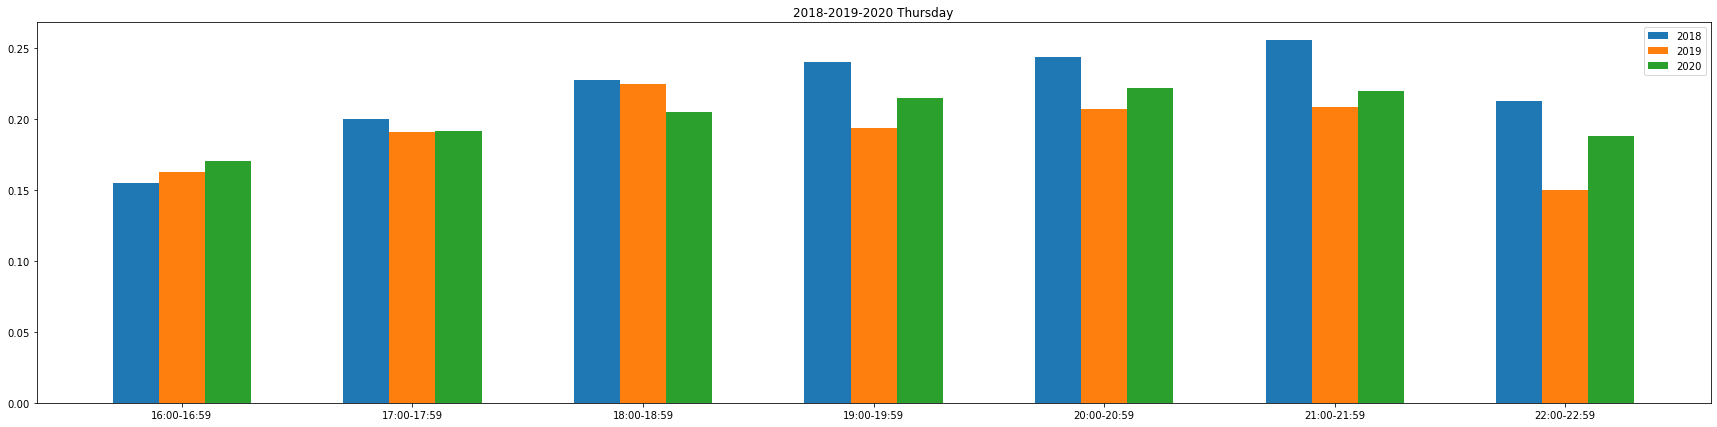

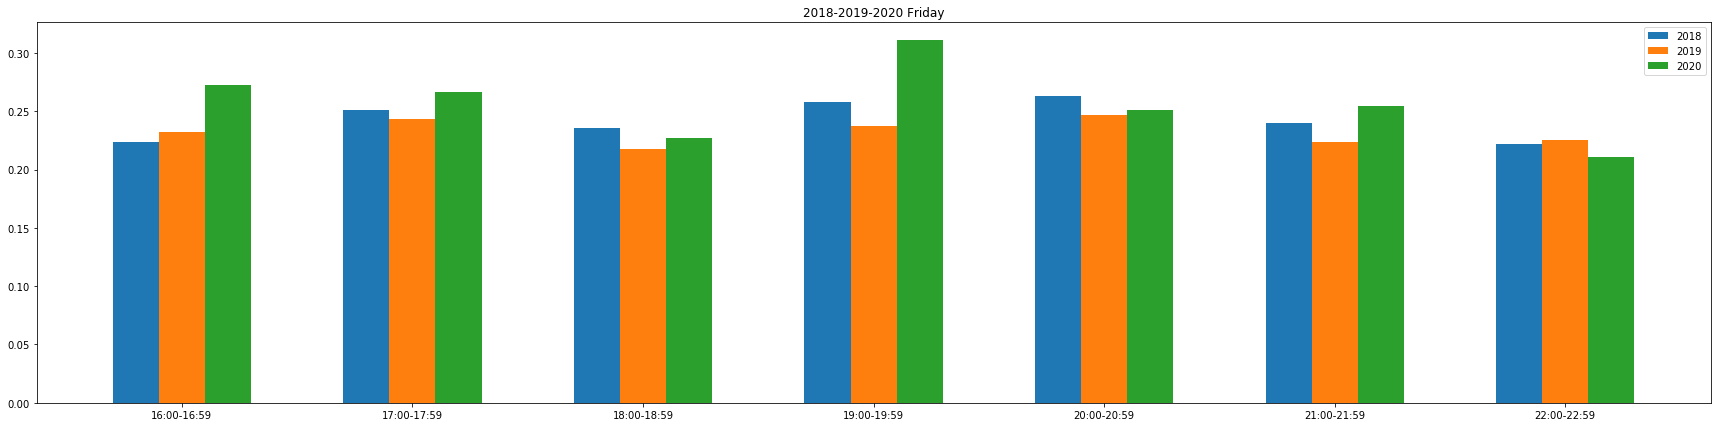

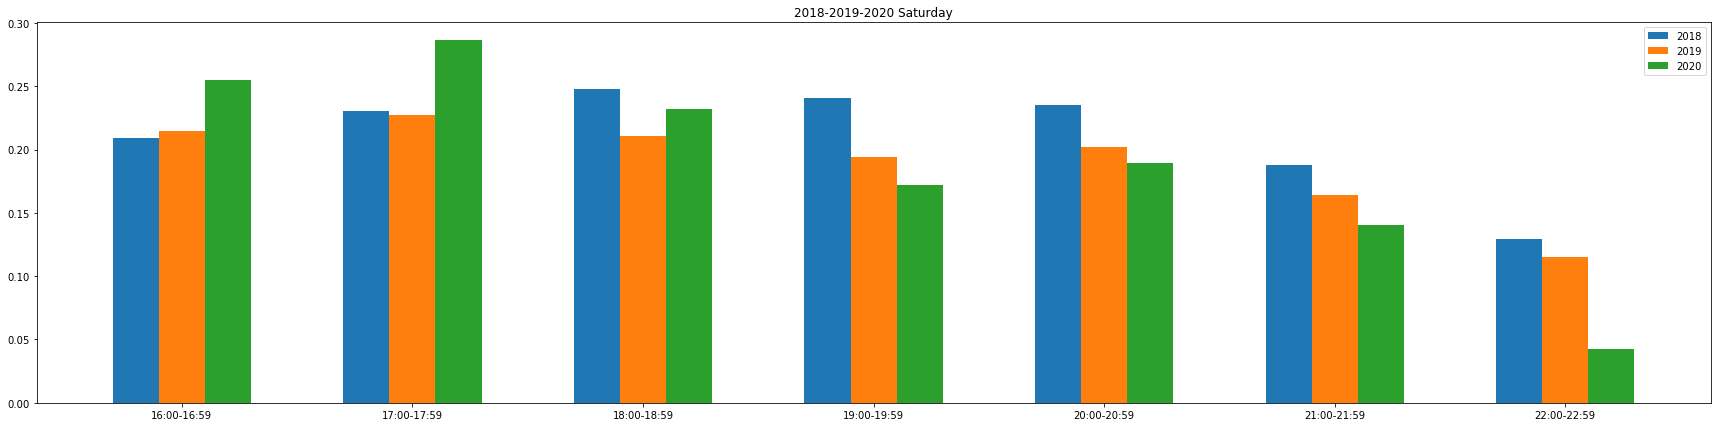

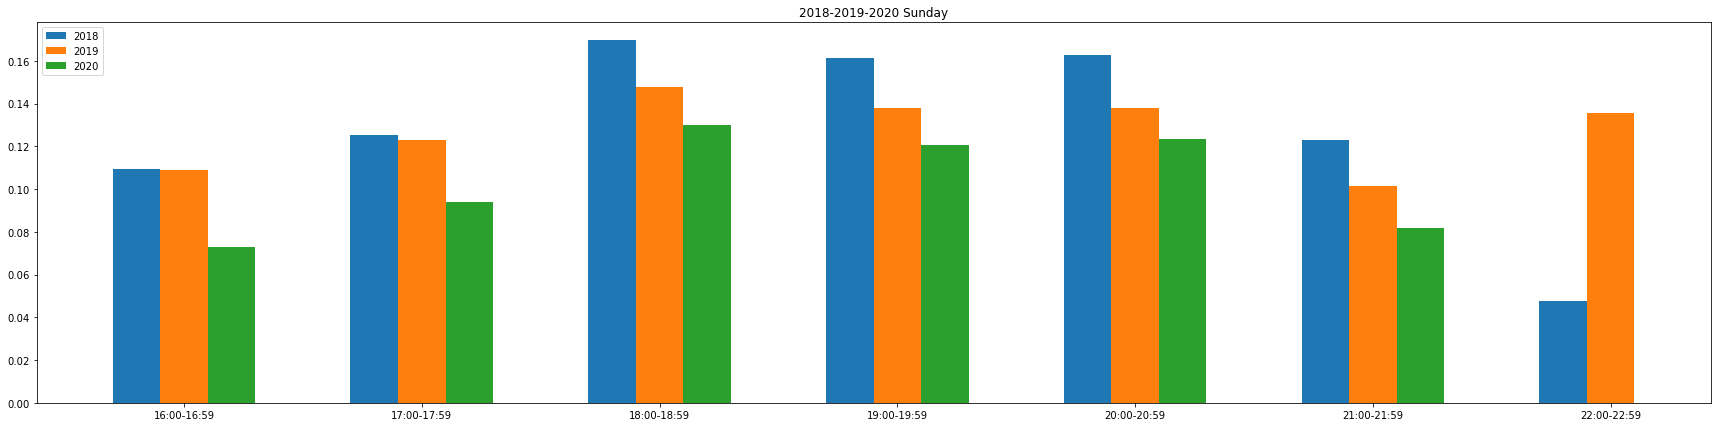

In [475]:
for i in stats_prime_avg:
    if i+2 == 2021: break
    for j in stats_prime_avg[i]:
        f, ax = plt.subplots(figsize=(30,7))

        plt.bar(np.arange(len(stats_prime_avg[i][j]))-.2, list(stats_prime_avg[i][j].values()), width=.2, align='center')
        plt.bar(np.arange(len(stats_prime_avg[i][j])), list(stats_prime_avg[i+1][j].values()), width=.2, align='center')
        plt.bar(np.arange(len(stats_prime_avg[i][j]))+.2, list(stats_prime_avg[i+2][j].values()), width=.2, align='center')
        plt.xticks(range(len(stats_prime_avg[i][j])), list(stats_prime_avg[i][j].keys()), rotation=0)
        plt.title(str(i)+'-'+str(i+1)+'-'+str(i+2)+' '+j)

        plt.legend((str(i), str(i+1), str(i+2)))

        plt.show()

## Genres by year

In [66]:
genre = set()
all_genres = showings.tmdb_genre_ids.tolist()
for i in all_genres:
    genre.update(i)

In [67]:
%%time
stats = dict()
for i in range(2007, 2021):
    stats[i] = dict()
    temp = showings.loc[showings.showtime.dt.strftime('%Y').between(str(i), str(i))]
    for j in genre:
        stats[i][genres[j]] = temp.loc[temp.tmdb_genre_ids.apply(lambda numbers: j in numbers), 'coverage']

Wall time: 1min 2s


In [95]:
stats_avg = dict()
stats_cnt = dict()
for i in stats:
    stats_avg[i] = dict()
    stats_cnt[i] = dict()
    for j in stats[i]:
        stats_avg[i][j] = stats[i][j].mean()
        stats_cnt[i][j] = stats[i][j].count()

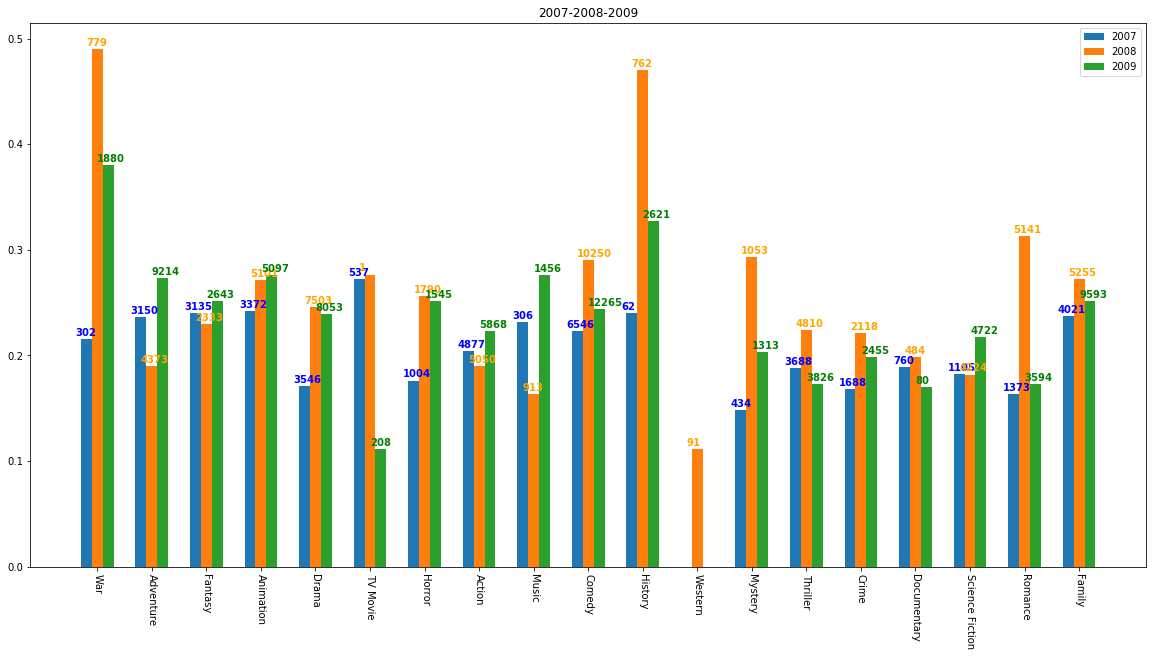

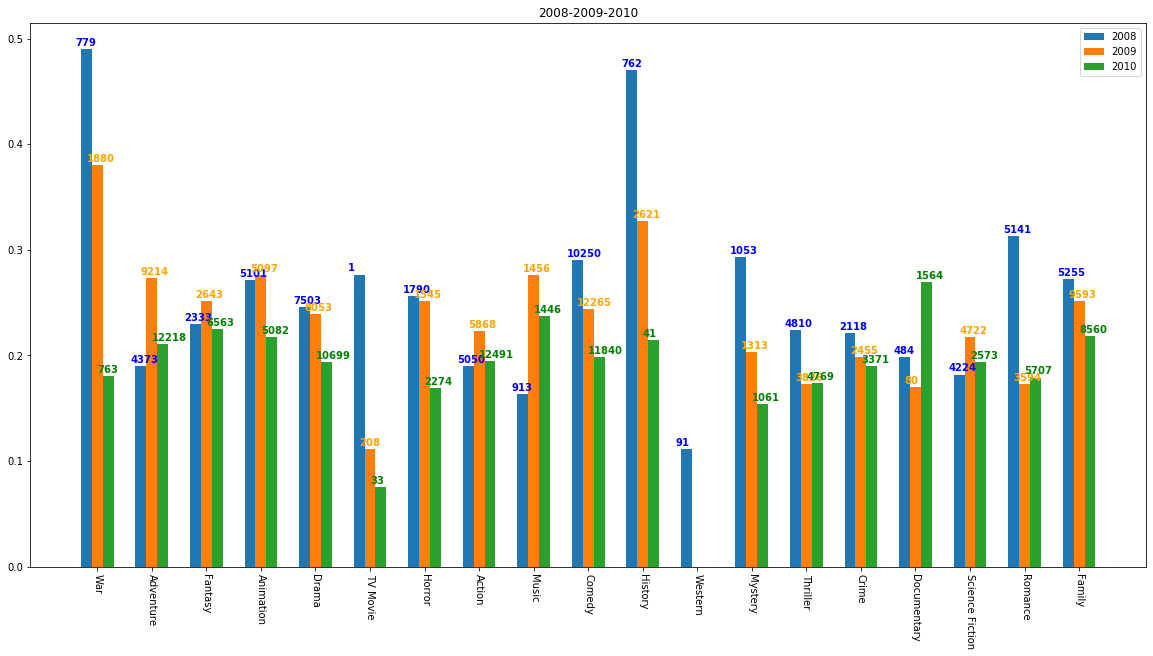

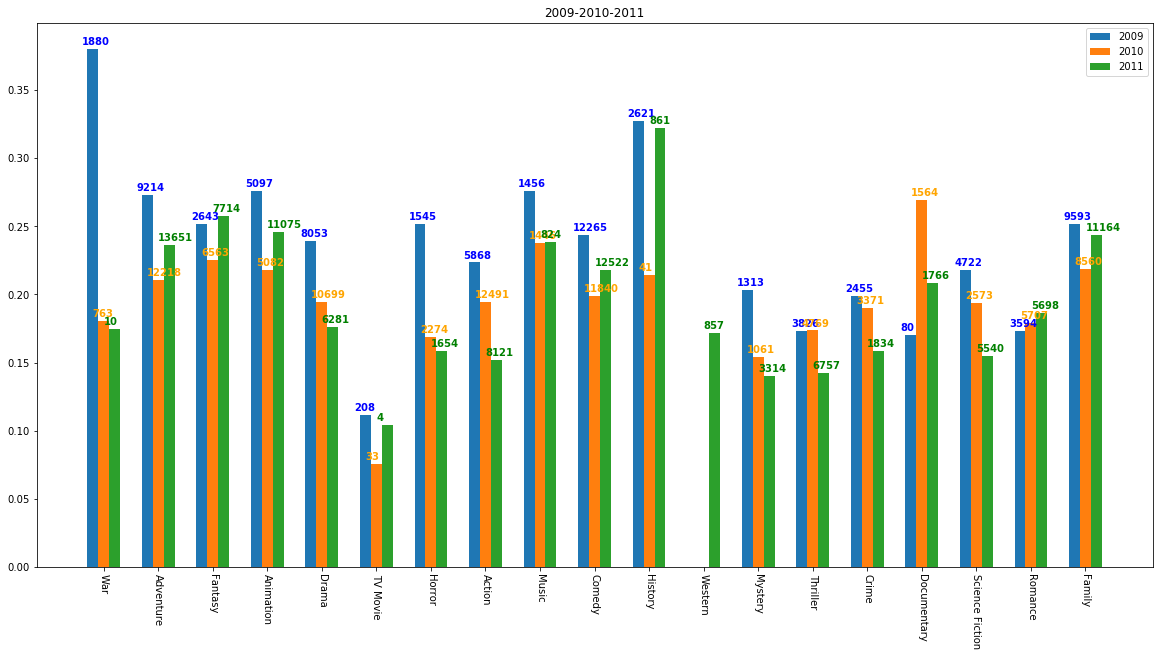

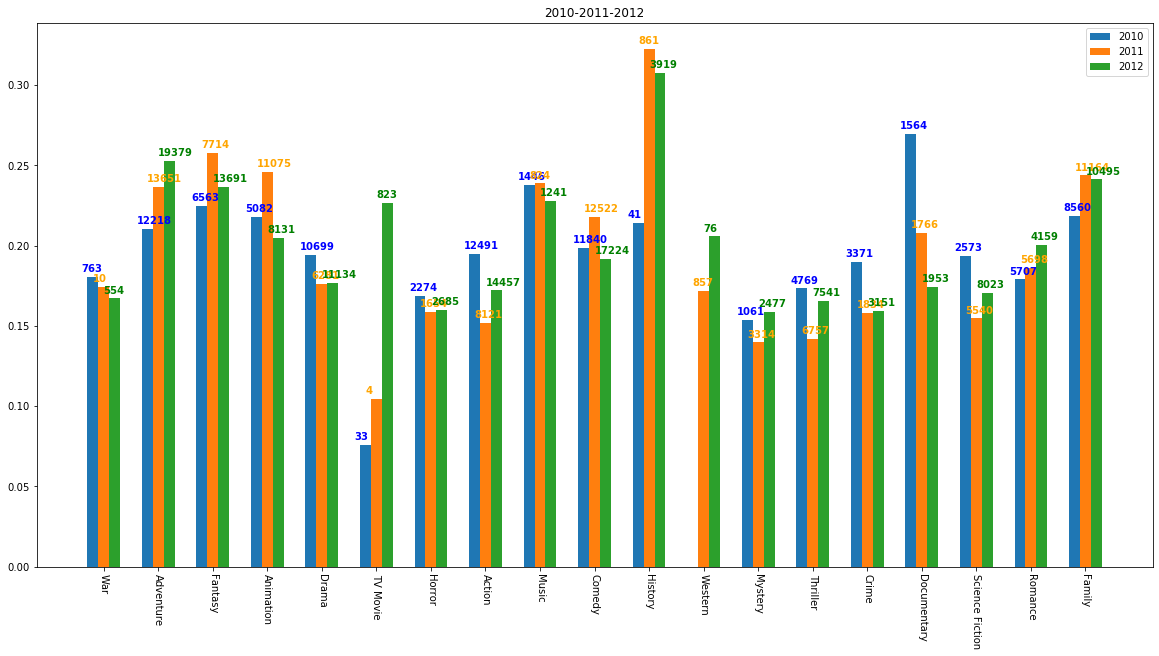

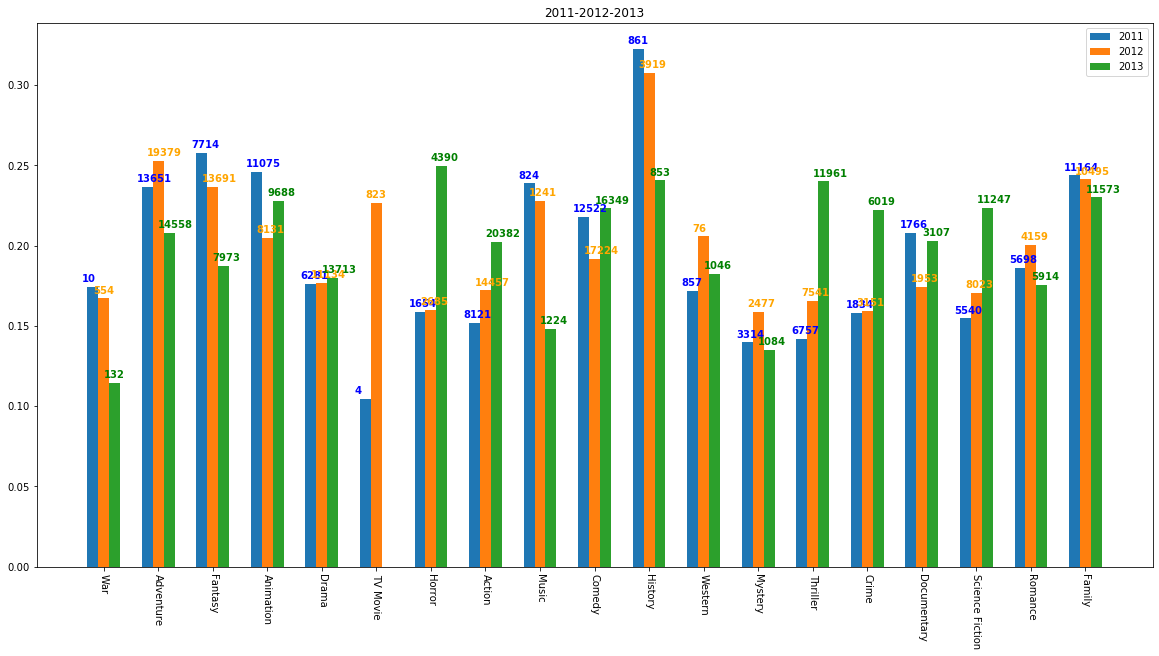

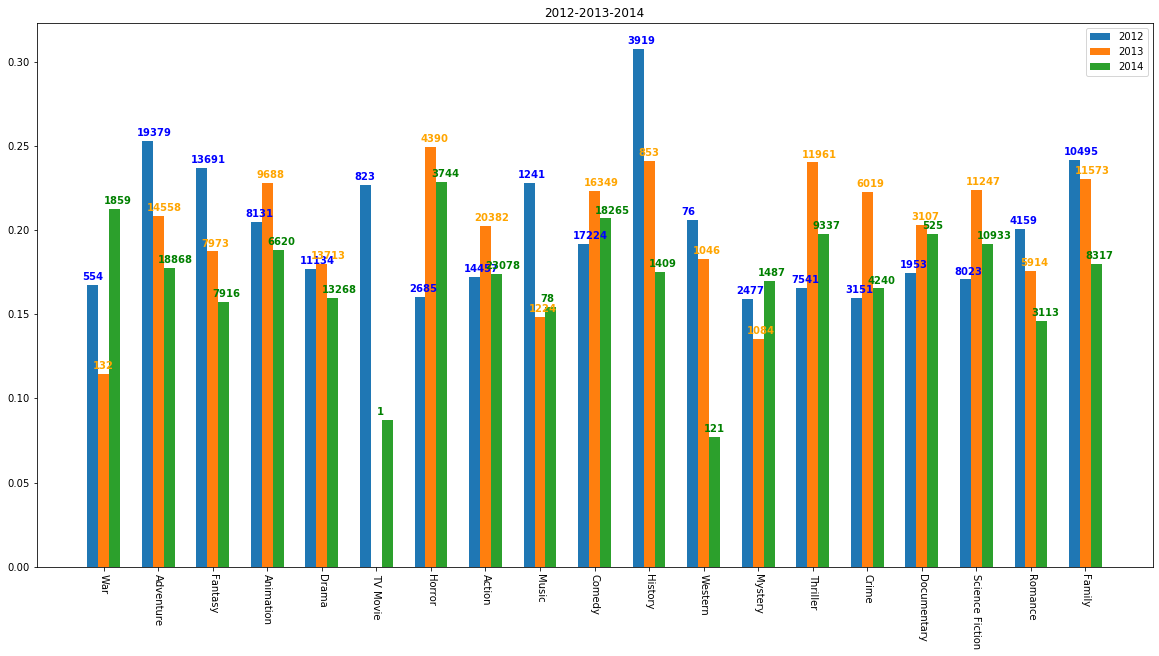

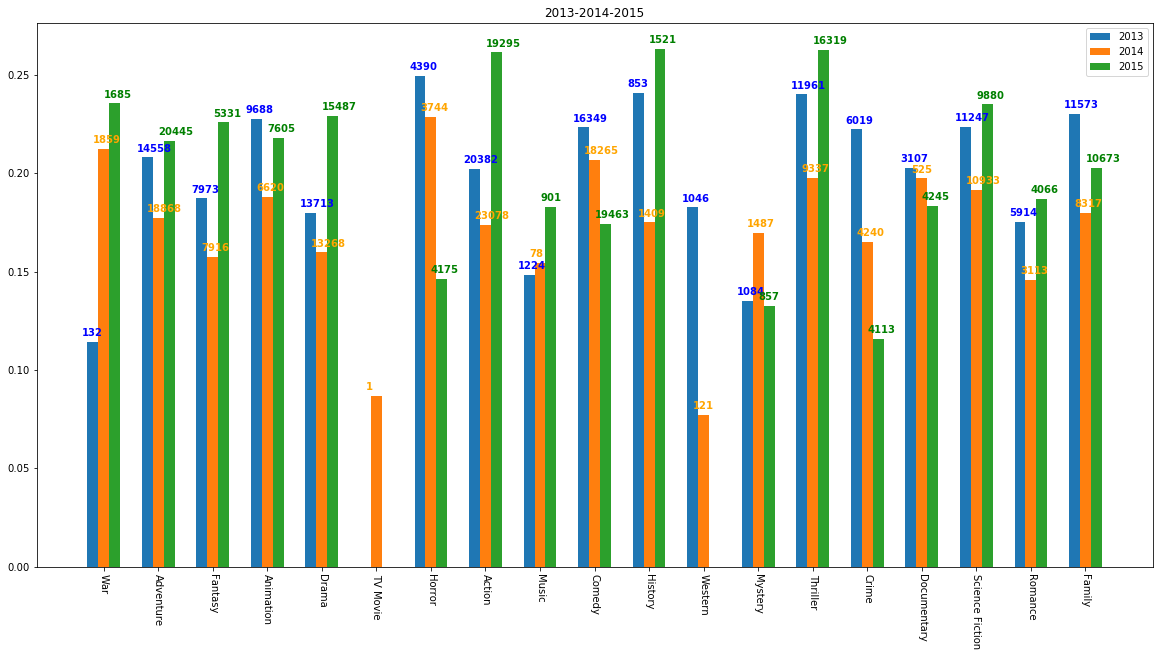

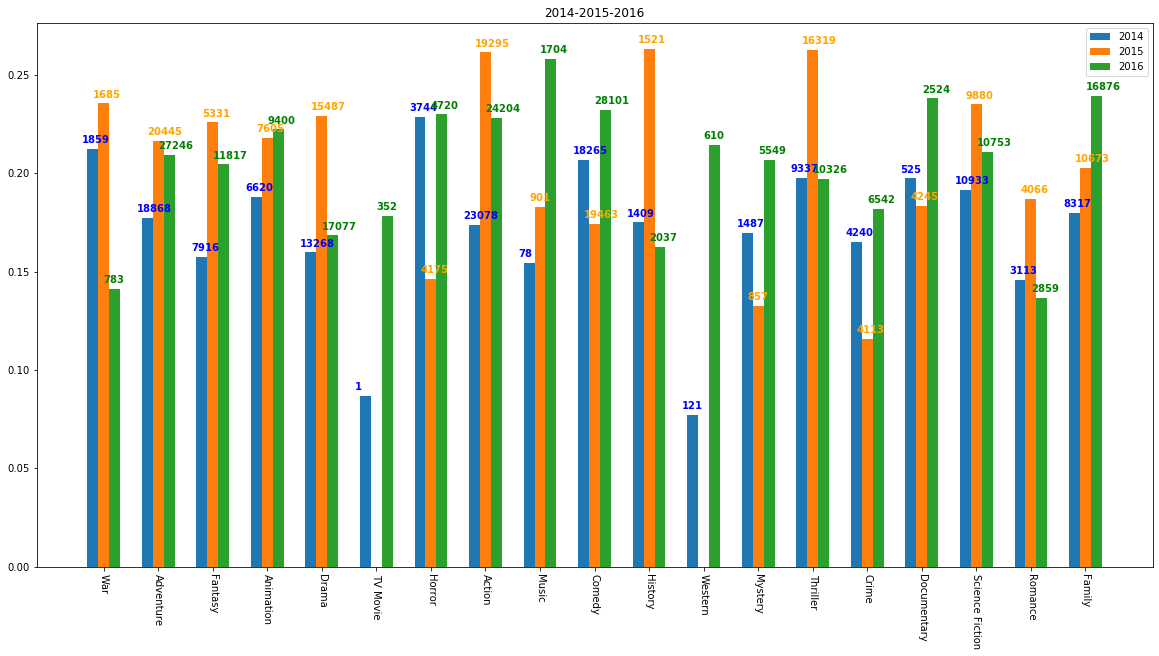

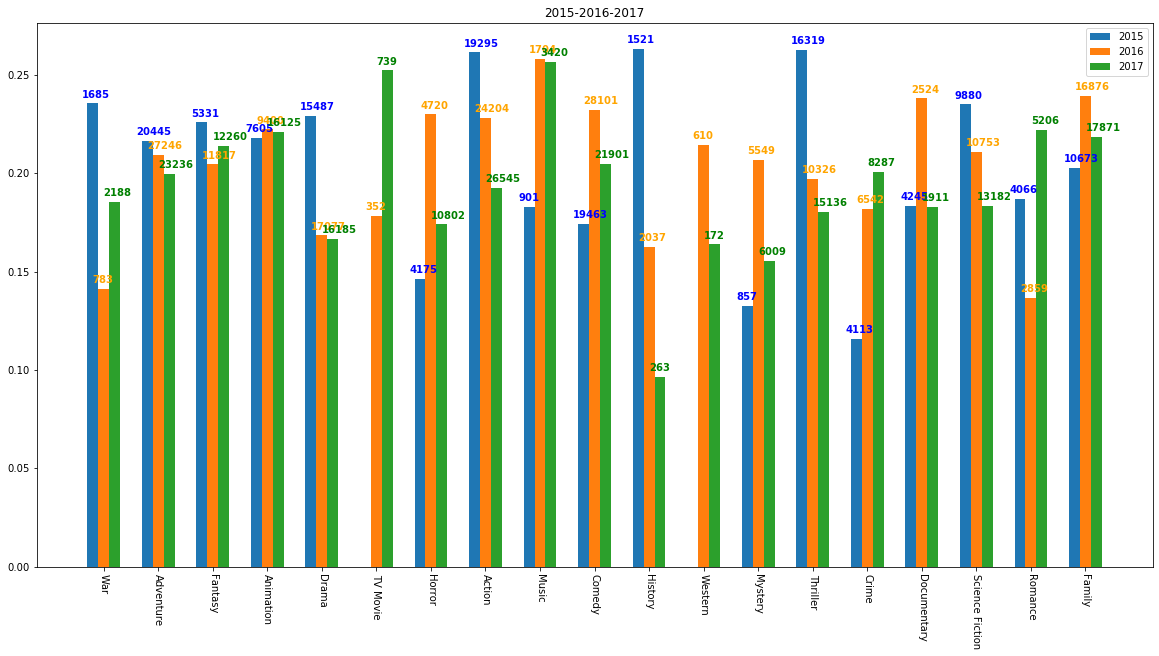

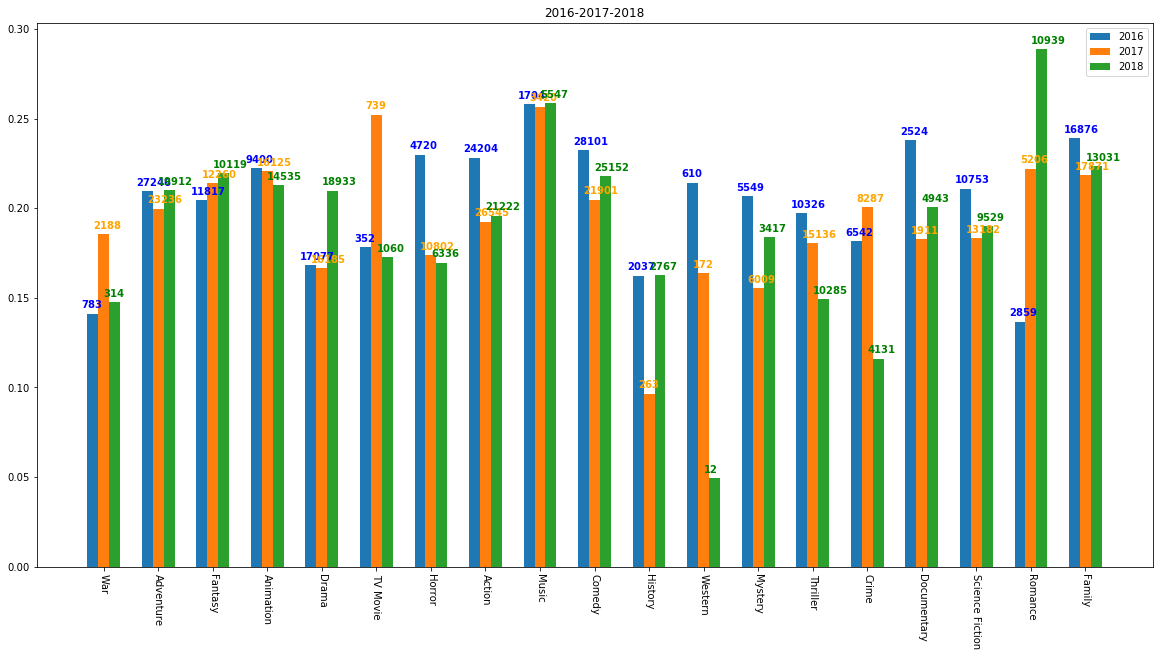

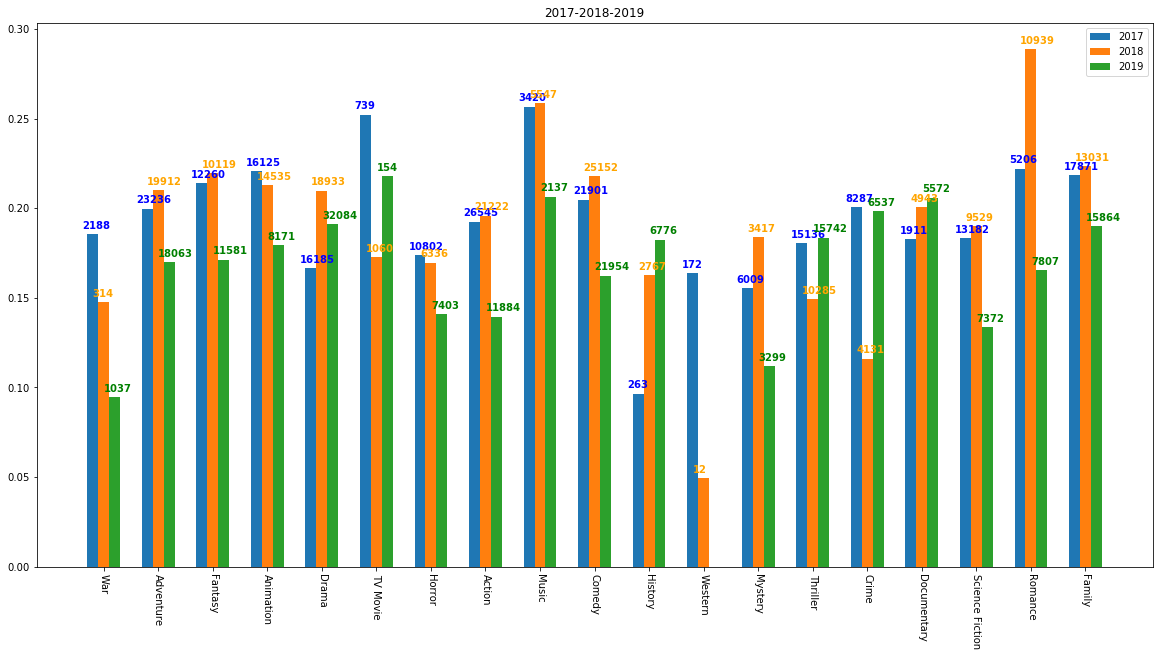

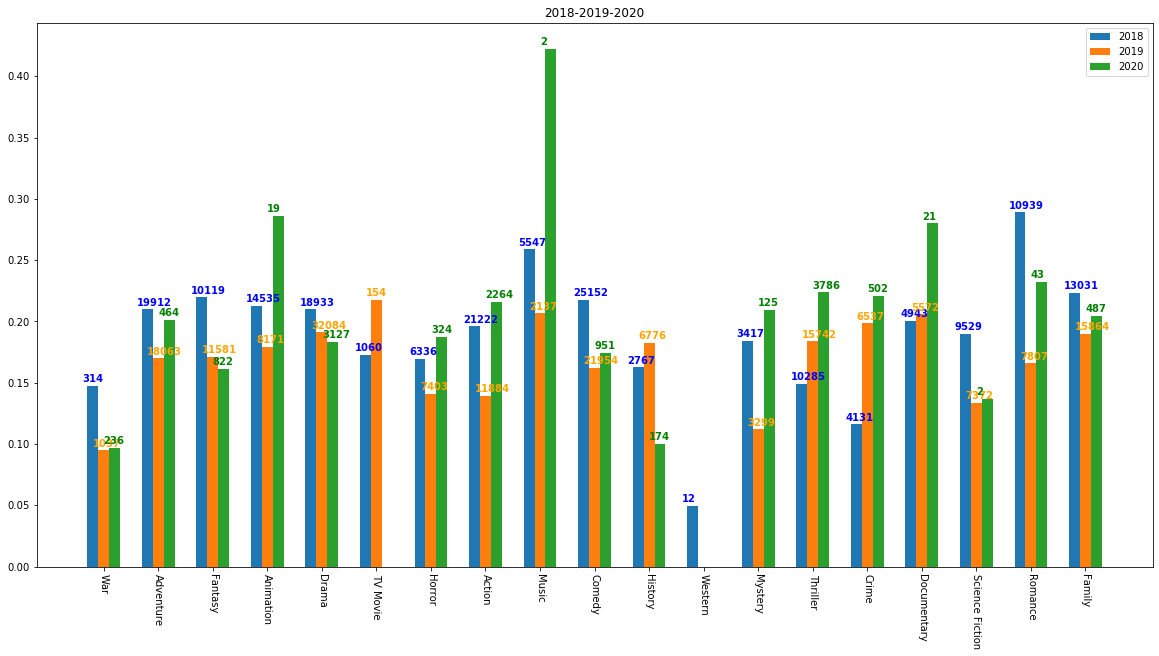

In [114]:
for i in stats_avg:
    if i+2 == 2021: break
    f, ax = plt.subplots(figsize=(20,10))

    plt.bar(np.arange(len(stats_avg[i]))-.2, list(stats_avg[i].values()), width=.2, align='center')
    plt.bar(np.arange(len(stats_avg[i])), list(stats_avg[i+1].values()), width=.2, align='center')
    plt.bar(np.arange(len(stats_avg[i]))+.2, list(stats_avg[i+2].values()), width=.2, align='center')
    plt.xticks(range(len(stats_avg[i])), list(stats_avg[i].keys()), rotation=270)

    for j, (k, v) in enumerate(stats_cnt[i].items()):
        if not np.isfinite(stats_avg[i][k]): continue
        ax.text(j - .4, stats_avg[i][k] + 0.003, str(v), color='blue', fontweight='bold')
    for j, (k, v) in enumerate(stats_cnt[i+1].items()):
        if not np.isfinite(stats_avg[i+1][k]): continue
        ax.text(j - .2, stats_avg[i+1][k] + 0.003, str(v), color='orange', fontweight='bold')
    for j, (k, v) in enumerate(stats_cnt[i+2].items()):
        if not np.isfinite(stats_avg[i+2][k]): continue
        ax.text(j, stats_avg[i+2][k] + 0.003, str(v), color='green', fontweight='bold')
    
    plt.title(str(i)+'-'+str(i+1)+'-'+str(i+2))
    plt.legend((str(i), str(i+1), str(i+2)))

    plt.show()

# Analysis over the past 5 years

In [492]:
showings_5years = showings.loc[showings.showtime.dt.strftime('%Y').between('2015', '2020')]

In [493]:
showings_5years.head()

showtime  seats  room  std_movienr  \
arr_nr                                                 
55837  2017-01-10 12:15:00   66.0     2  SFN20151241   
62933  2019-11-01 16:35:00   66.0     2  SFN20190978   
62930  2019-11-01 13:10:00  386.0     1  NOR20180345   
53455  2016-02-09 12:00:00   66.0     2  ART20150247   
62927  2019-11-01 10:20:00   66.0     2  NOR20180530   

                                               full_title  coverage  seats_b  \
arr_nr                                                                         
55837                           Dyrene i Hakkebakkeskogen       1.0     63.0   
62933                                               Joker       1.0     63.0   
62930   Snekker Andersen og Julenissen: Den vesle bygd...       1.0    382.0   
53455                                               45 år       1.0     63.0   
62927            Kaptein Sabeltann og Den Magiske Diamant       1.0     63.0   

        sold                                     stripped_title  \
arr_nr                                                            
55837     74                          dyrene i hakkebakkeskogen   
62933     66                                              joker   
62930    386  snekker andersen og julenissen den vesle bygda...   
53455     66                                              45 år   
62927     66           kaptein sabeltann og den magiske diamant   

             tmdb_genre_ids tmdb_original_language  \
arr_nr                                               
55837   [14, 16, 35, 10751]                     en   
62933   [12, 16, 35, 10751]                     en   
62930           [10751, 35]                     no   
53455           [18, 10749]                     en   
62927       [12, 14, 10751]                     en   

                   tmdb_original_title  \
arr_nr                                   
55837                     The Smurfs 2   
62933           Penguins of Madagascar   
62930   Snekker Andersen og Julenissen   
53455                         Fly Away   
62927                            Dumbo   

                                            tmdb_overview  tmdb_popularity  \
arr_nr                                                                       
55837   The evil wizard Gargamel creates a couple of m...           14.105   
62933   Skipper, Kowalski, Rico and Private join force...           23.444   
62930   Carpenter Andersen and Santa Claus makes a dea...            2.575   
53455   The poignant yet humor filled story about a si...            1.745   
62927   A young elephant, whose oversized ears enable ...           23.007   

       tmdb_release_date                                tmdb_title  \
arr_nr                                                               
55837         2013-07-30                              The Smurfs 2   
62933         2014-11-22                    Penguins of Madagascar   
62930         2016-11-11  Santa Swap: Merry Christmas Mr. Andersen   
53455         2011-07-17                                  Fly Away   
62927         2019-03-27                                     Dumbo   

        tmdb_vote_average  tmdb_vote_count  
arr_nr                                      
55837                 5.7           1338.0  
62933                 6.4           2493.0  
62930                 5.9              8.0  
53455                 5.5              6.0  
62927                 6.6           2339.0

# Analysis relative to the release date, first 10 days after premiere

In [118]:
showings.tmdb_release_date = pd.to_datetime(showings.tmdb_release_date, format='%Y-%m-%d')

In [129]:
from copy import deepcopy

In [165]:
week_of_release = deepcopy(showings.loc[((showings.showtime - showings.tmdb_release_date) < dt.timedelta(days=11)) & ((showings.showtime - showings.tmdb_release_date) > dt.timedelta(days=-7))])

In [166]:
week_of_release.loc[:, ('showtime', 'tmdb_release_date', 'stripped_title', 'tmdb_title', 'coverage')]

showtime tmdb_release_date                  stripped_title  \
11      2017-09-13 21:00:00        2017-09-15                          thelma   
17      2018-11-02 13:00:00        2018-11-08                        grinchen   
19      2017-03-19 18:40:00        2017-03-16           skjønnheten og udyret   
26      2016-10-10 21:00:06        2016-10-12                       børning 2   
34      2016-11-04 13:40:00        2016-11-11  snekker andersen og julenissen   
...                     ...               ...                             ...   
1217336 2012-05-15 18:00:00        2012-05-15                    the dictator   
1217345 2020-01-01 19:45:00        2019-12-25                        tunnelen   
1217357 2013-09-07 20:00:00        2013-08-30                   one direction   
1217362 2016-05-28 20:00:00        2016-05-25                        warcraft   
1217363 2011-06-29 20:00:00        2011-06-28                  transformers 3   

                                       tmdb_title  coverage  
11                                         Thelma  1.000000  
17                                     The Grinch  1.000000  
19                           Beauty and the Beast  1.000000  
26                                      Burnout 2  1.000000  
34       Santa Swap: Merry Christmas Mr. Andersen  0.997409  
...                                           ...       ...  
1217336                              The Dictator  0.109890  
1217345                                The Tunnel  0.120879  
1217357                 One Direction: This Is Us  0.274725  
1217362                                  Warcraft  0.406593  
1217363            Transformers: Dark of the Moon  0.373626  

[136499 rows x 5 columns]

## Coverage per hour per day

In [167]:
%%time
stats_outlier = dict()
stats_prime = dict()
stats_early = dict()
for i in range(7):
    temp = week_of_release.loc[week_of_release.showtime.dt.dayofweek == i, ('showtime', 'coverage')]
    stats_outlier[calendar.day_name[i]] = dict()
    stats_prime[calendar.day_name[i]] = dict()
    stats_early[calendar.day_name[i]] = dict()
    for j in range(24):
        if j == 0:
            stats_outlier[calendar.day_name[i]]['23:00-08:59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between('23:00:00', '23:59:59')
                | temp.showtime.dt.strftime('%H:%M:%S').between('00:00:00', '08:59:59'),
                'coverage']
        elif j == 23 or j < 9: continue
        elif j < 10:
            stats_early[calendar.day_name[i]]['0' + str(j) + ':00-0' + str(j) + ':59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between('0' + str(j) + ':00:00', '0' + str(j) + ':59:59'),
                'coverage']
        elif j < 16:
            stats_early[calendar.day_name[i]][str(j) + ':00-' + str(j) + ':59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between(str(j) + ':00:00', str(j) + ':59:59'),
                'coverage']
        else:
            stats_prime[calendar.day_name[i]][str(j) + ':00-' + str(j) + ':59'] = temp.loc[
                temp.showtime.dt.strftime('%H:%M:%S').between(str(j) + ':00:00', str(j) + ':59:59'),
                'coverage']

Wall time: 16 s


In [168]:
stats_prime_avg = dict()
for i in stats_prime:
    stats_prime_avg[i] = dict()
    for j in stats_prime[i]:
        stats_prime_avg[i][j] = stats_prime[i][j].mean()
        
stats_early_avg = dict()
for i in stats_early:
    stats_early_avg[i] = dict()
    for j in stats_early[i]:
        stats_early_avg[i][j] = stats_early[i][j].mean()

In [169]:
stats_prime_cnt = dict()
for i in stats_prime:
    stats_prime_cnt[i] = dict()
    for j in stats_prime[i]:
        stats_prime_cnt[i][j] = stats_prime[i][j].count()
        
stats_early_cnt = dict()
for i in stats_early:
    stats_early_cnt[i] = dict()
    for j in stats_early[i]:
        stats_early_cnt[i][j] = stats_early[i][j].count()

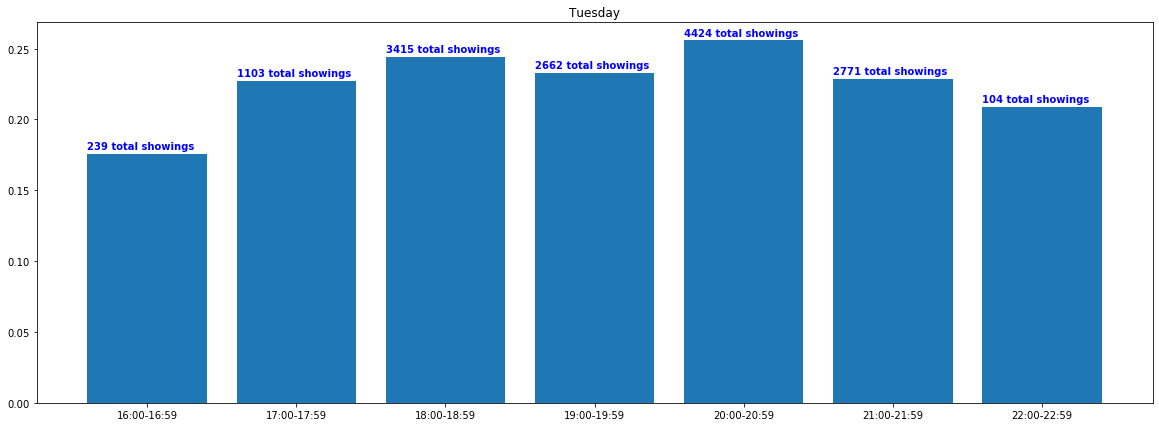

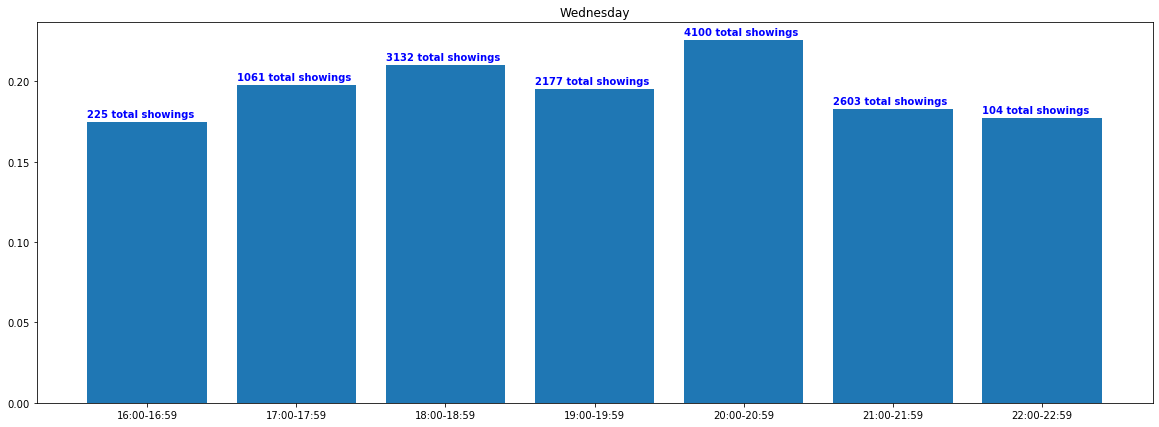

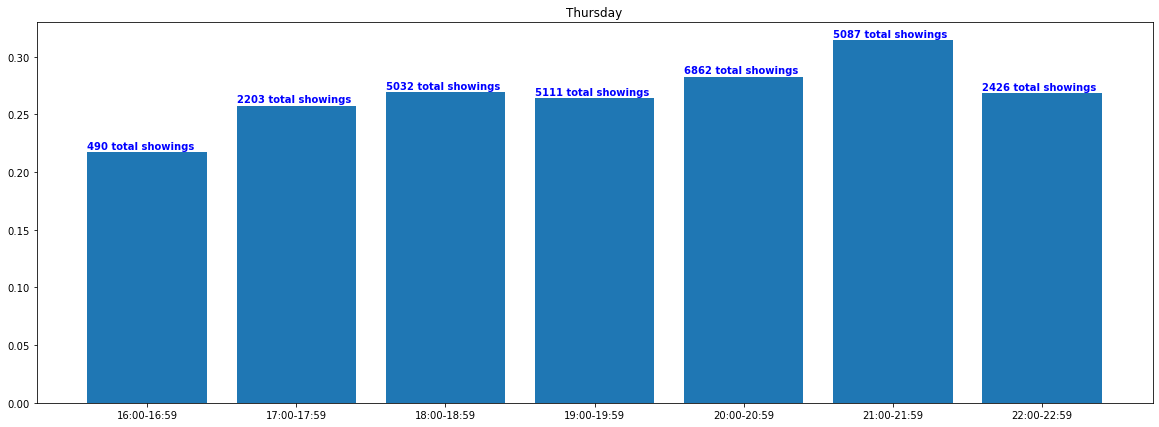

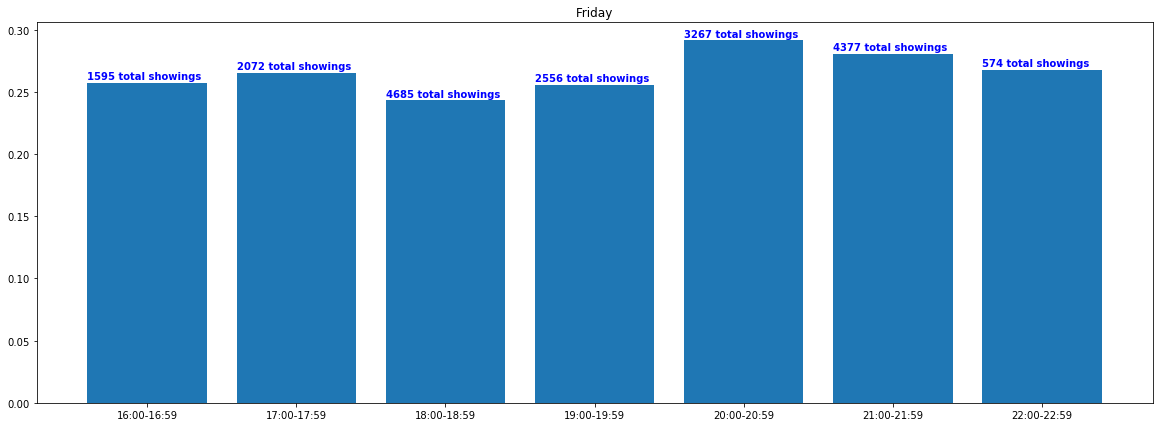

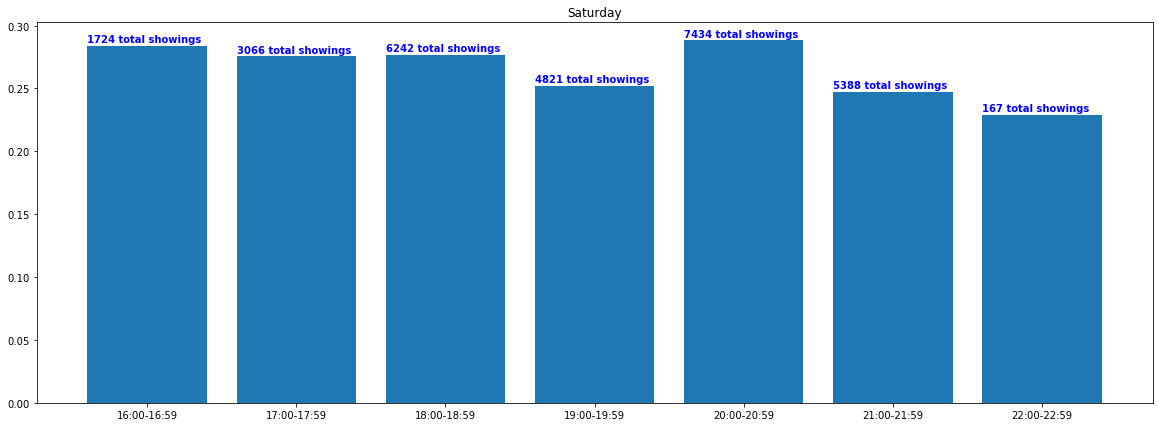

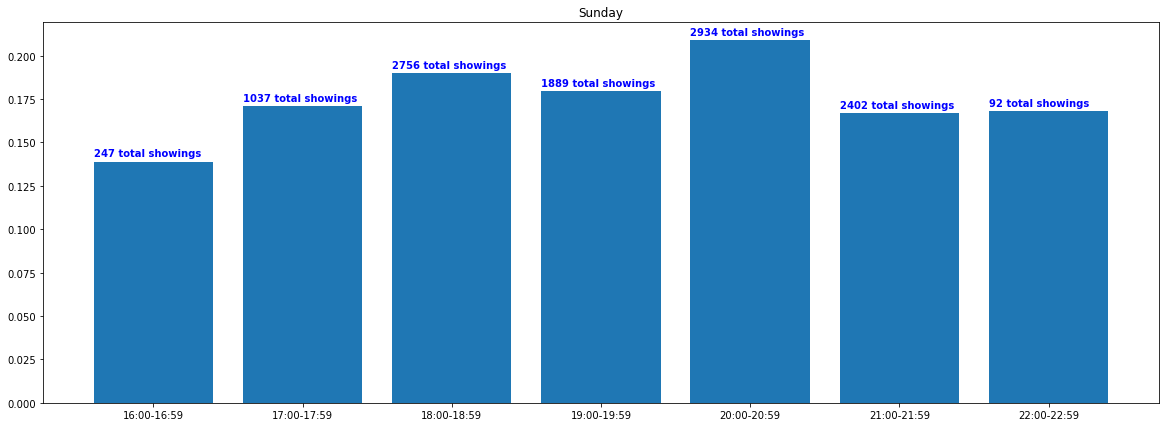

In [170]:
for i in stats_prime_avg:
    f, ax = plt.subplots(figsize=(20,7))
    
    plt.bar(range(len(stats_prime_avg[i])), list(stats_prime_avg[i].values()), align='center')
    plt.xticks(range(len(stats_prime_avg[i])), list(stats_prime_avg[i].keys()), rotation=0)
    plt.title(i)
    
    for j, (k, v) in enumerate(stats_prime_cnt[i].items()):
        ax.text(j - .4, stats_prime_avg[i][k] + 0.003, str(v) + ' total showings', color='blue', fontweight='bold')

    plt.show()

In [171]:
%%time
stats = dict()
for i in range(24):
    if i < 10:
        stats['0' + str(i) + ':00-0' + str(i) + ':59'] = week_of_release.loc[week_of_release.showtime.dt.strftime('%H:%M:%S').between('0' + str(i) + ':00:00', '0' + str(i) + ':59:59'), 'coverage']
    else:
        stats[str(i) + ':00-' + str(i) + ':59'] = week_of_release.loc[week_of_release.showtime.dt.strftime('%H:%M:%S').between(str(i) + ':00:00', str(i) + ':59:59'), 'coverage']

Wall time: 24 s


In [172]:
stats_avg = dict()
stats_num = dict()
for i in stats:
    stats_avg[i] = stats[i].mean()
    stats_num[i] = stats[i].count()

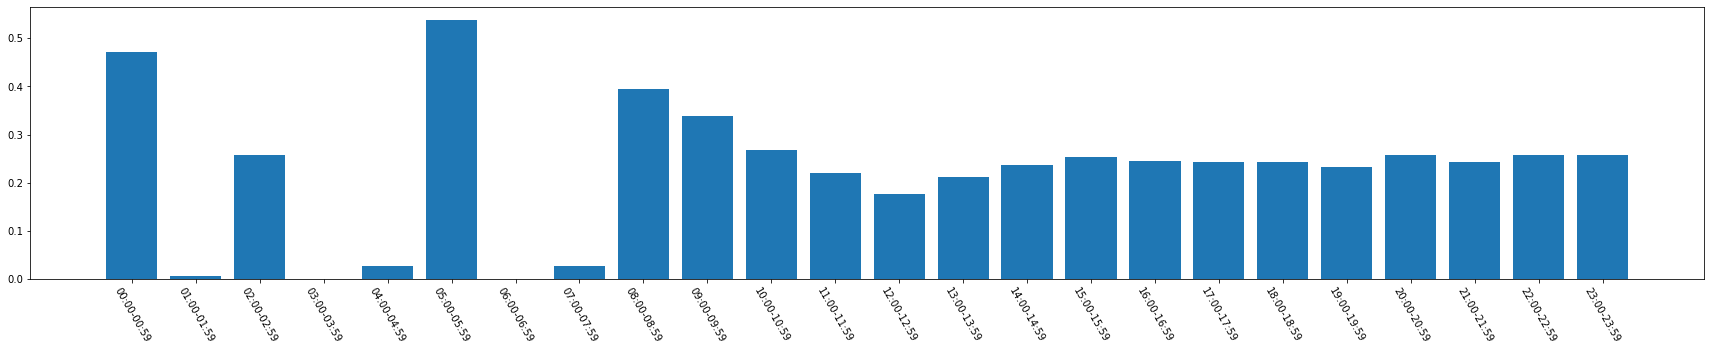

In [173]:
f, ax = plt.subplots(figsize=(30,5))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=300)

plt.show()

## Coverage by day of week

In [174]:
%%time
stats = dict()
for i in range(7):
    stats[calendar.day_name[i]] = week_of_release.loc[week_of_release.showtime.dt.dayofweek == i, 'coverage']

Wall time: 88.9 ms


In [175]:
stats_avg = dict()
for i in stats:
    stats_avg[i] = stats[i].mean()

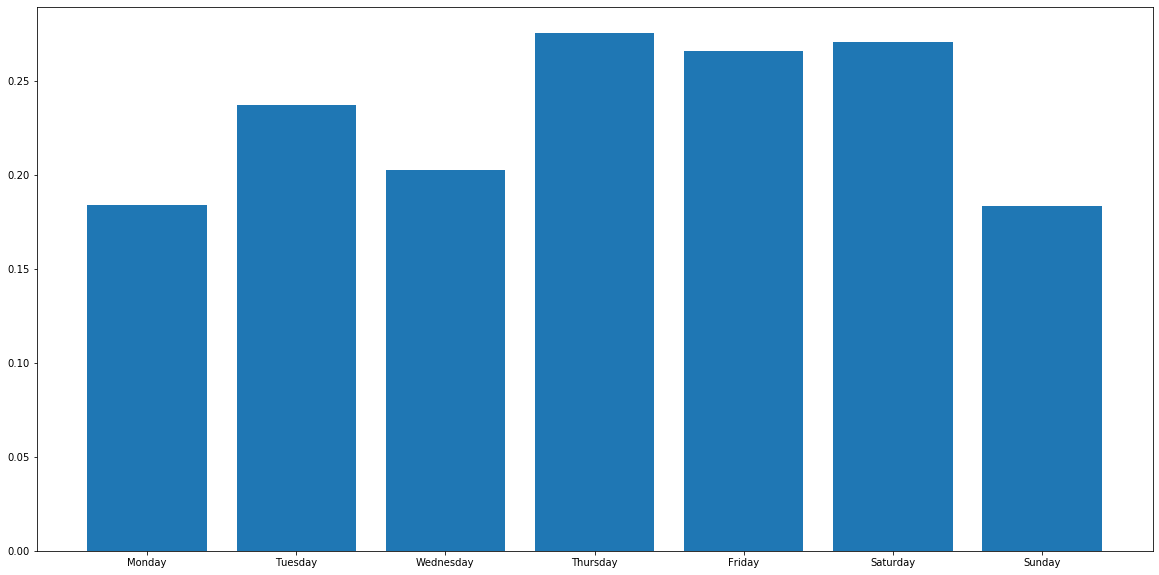

In [176]:
f, ax = plt.subplots(figsize=(20,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=0)

plt.show()

## Genres by year

In [177]:
genre = set()
all_genres = week_of_release.tmdb_genre_ids.tolist()
for i in all_genres:
    genre.update(i)

In [178]:
%%time
stats = dict()
for i in range(2007, 2021):
    stats[i] = dict()
    temp = week_of_release.loc[week_of_release.showtime.dt.strftime('%Y').between(str(i), str(i))]
    for j in genre:
        stats[i][genres[j]] = temp.loc[temp.tmdb_genre_ids.apply(lambda numbers: j in numbers), 'coverage']

Wall time: 13.7 s


In [179]:
stats_avg = dict()
stats_cnt = dict()
for i in stats:
    stats_avg[i] = dict()
    stats_cnt[i] = dict()
    for j in stats[i]:
        stats_avg[i][j] = stats[i][j].mean()
        stats_cnt[i][j] = stats[i][j].count()

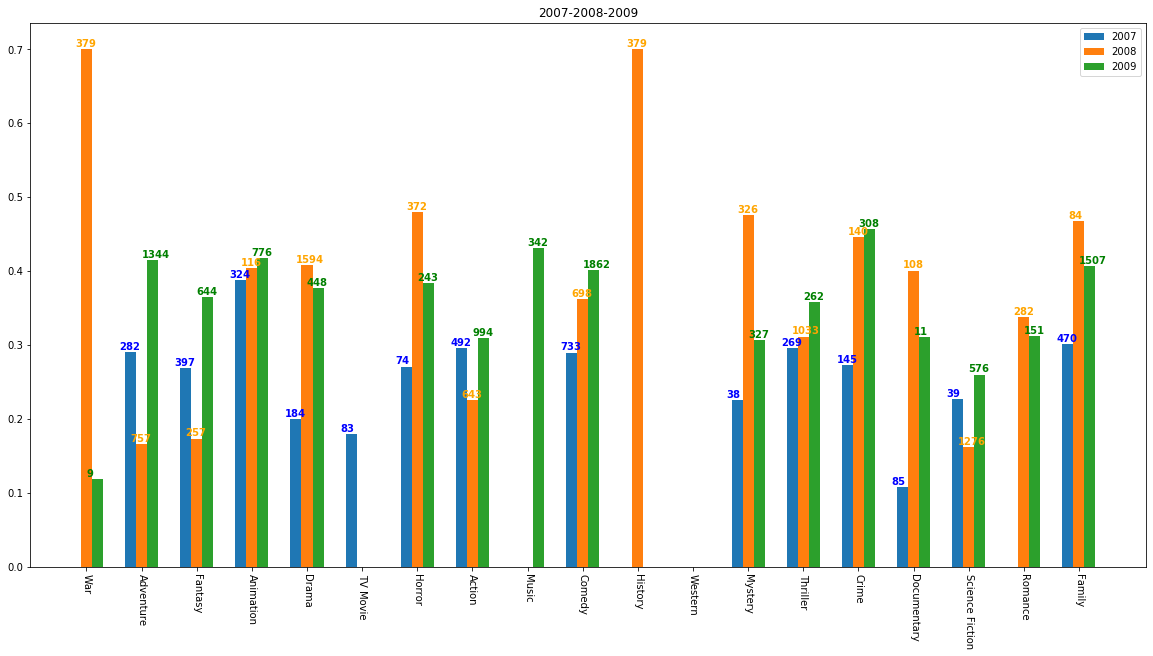

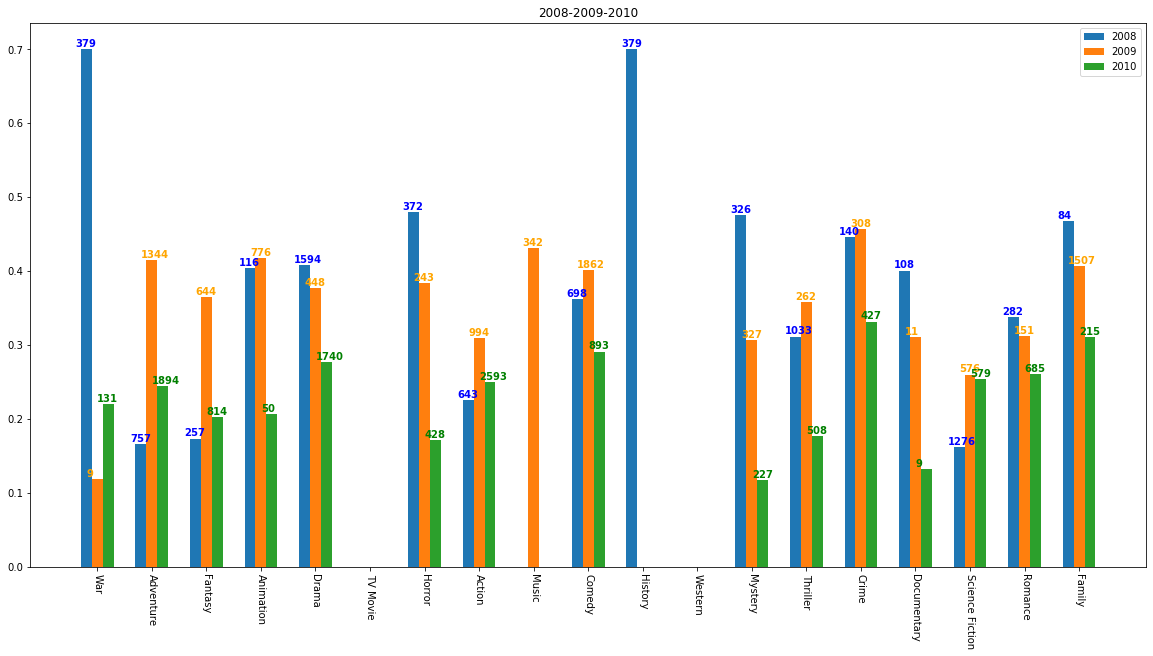

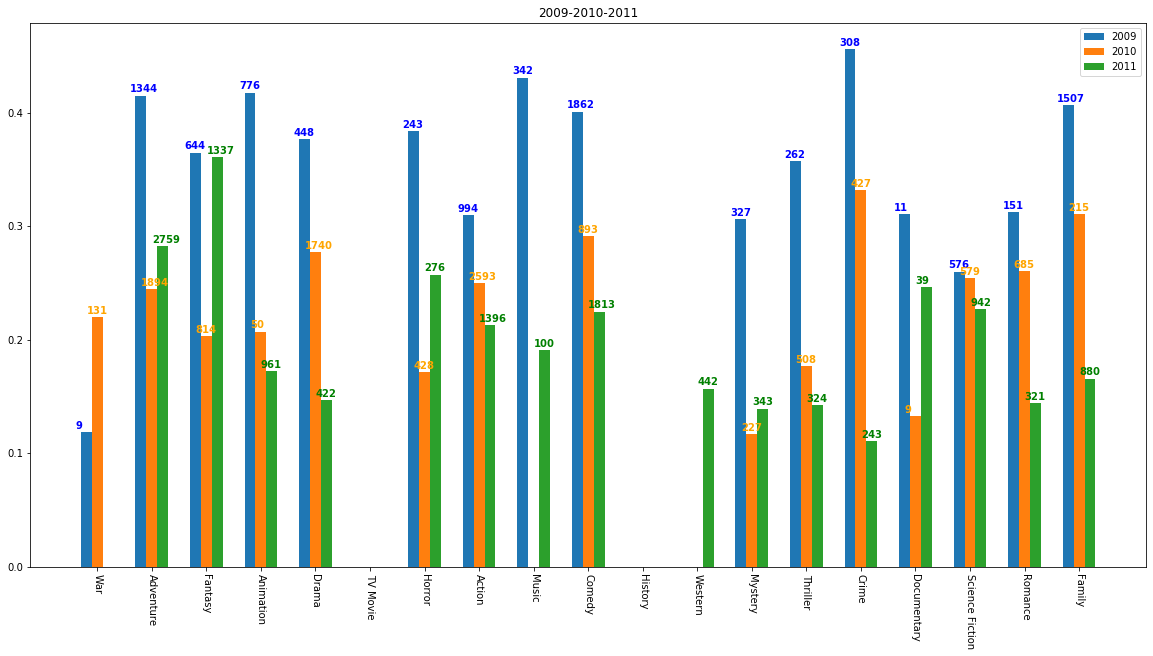

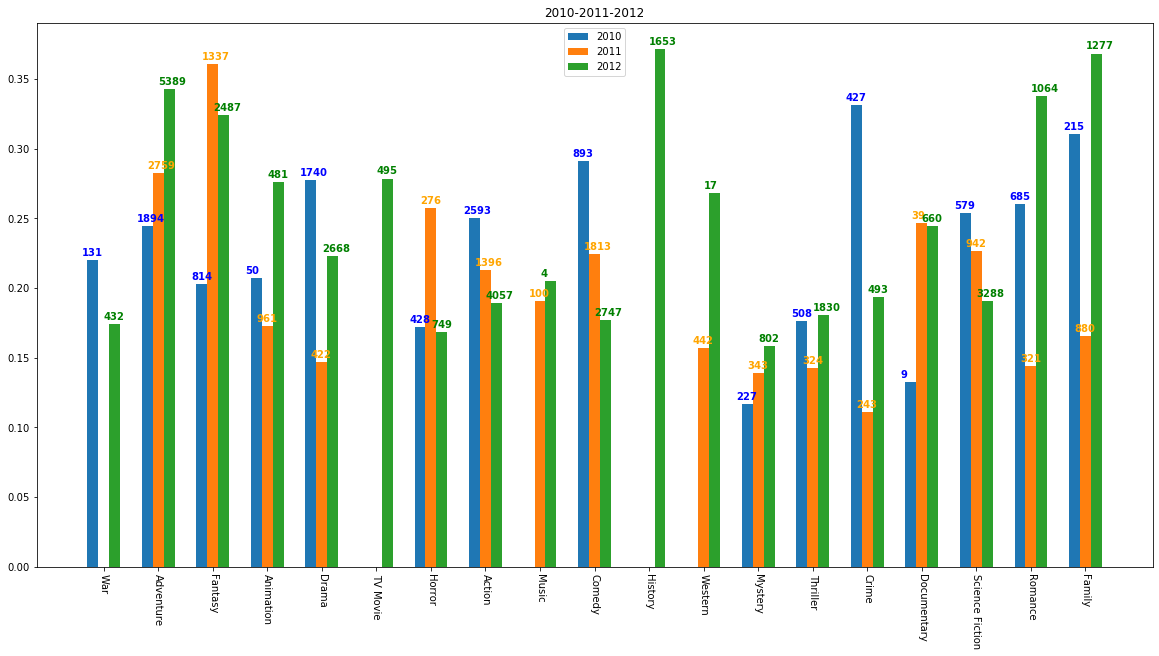

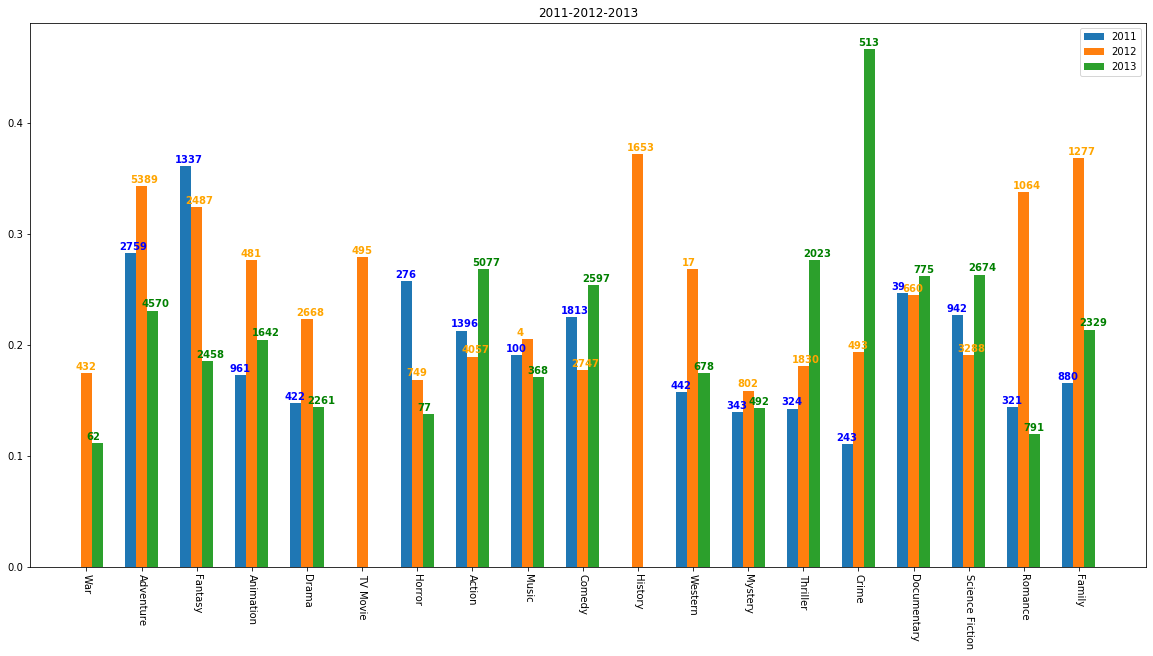

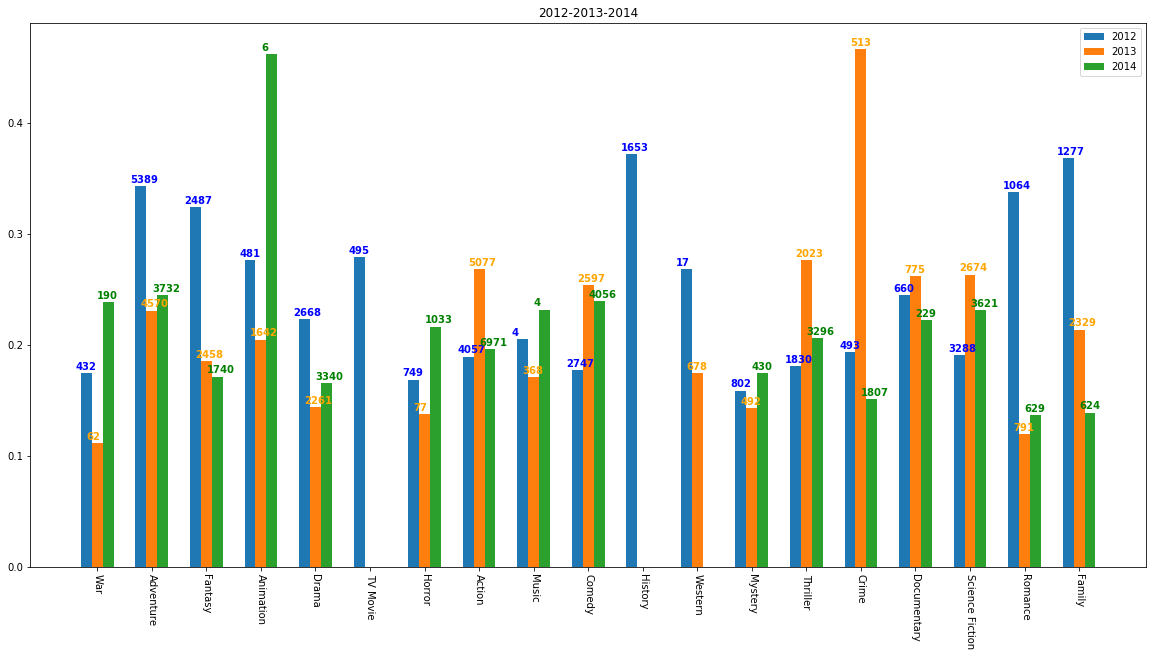

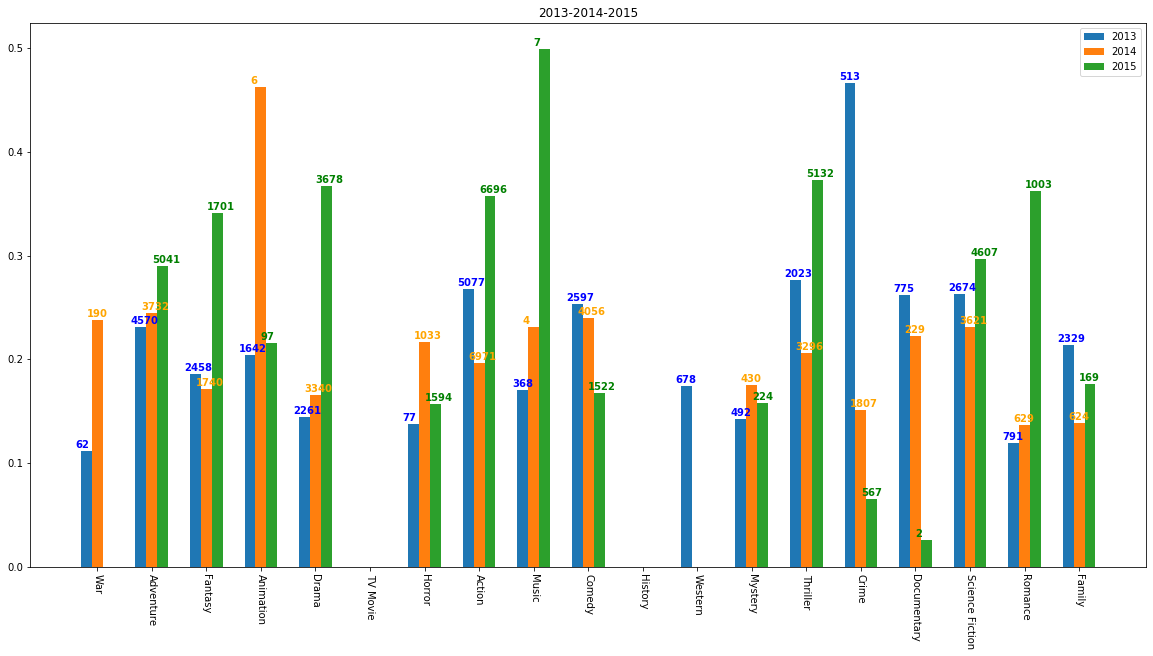

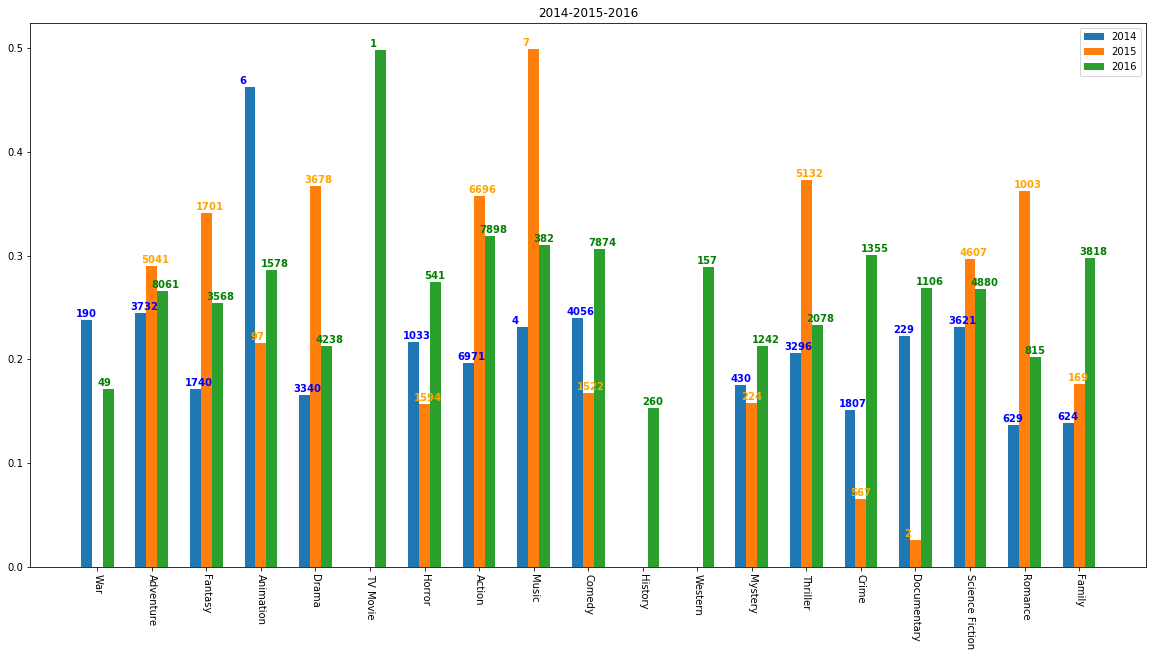

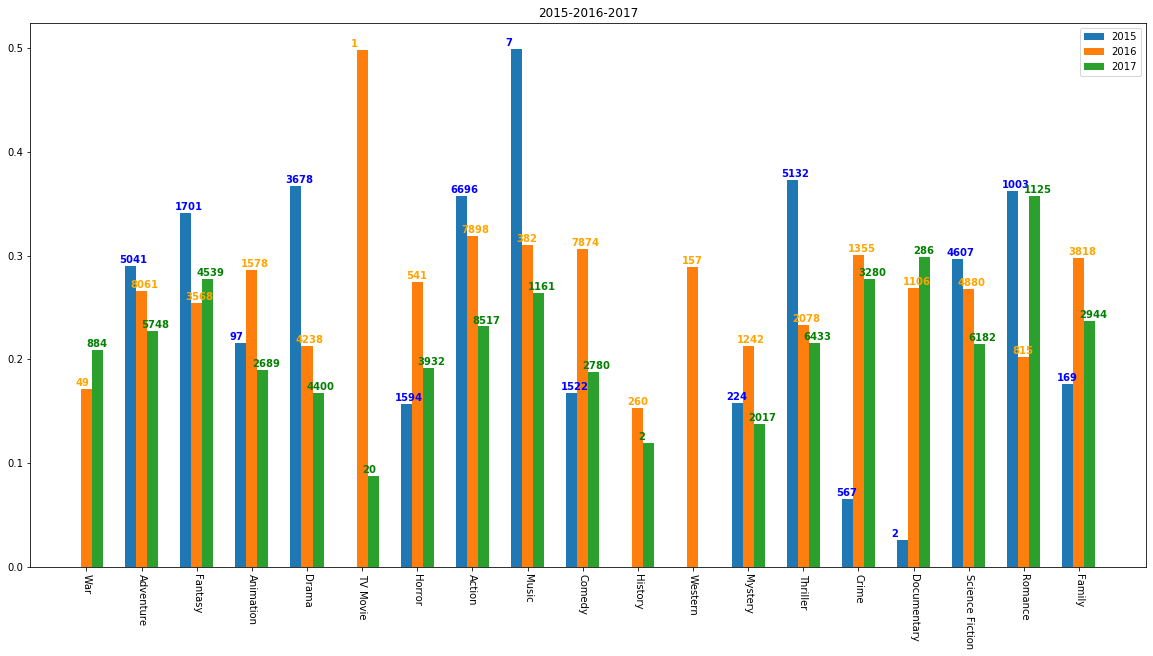

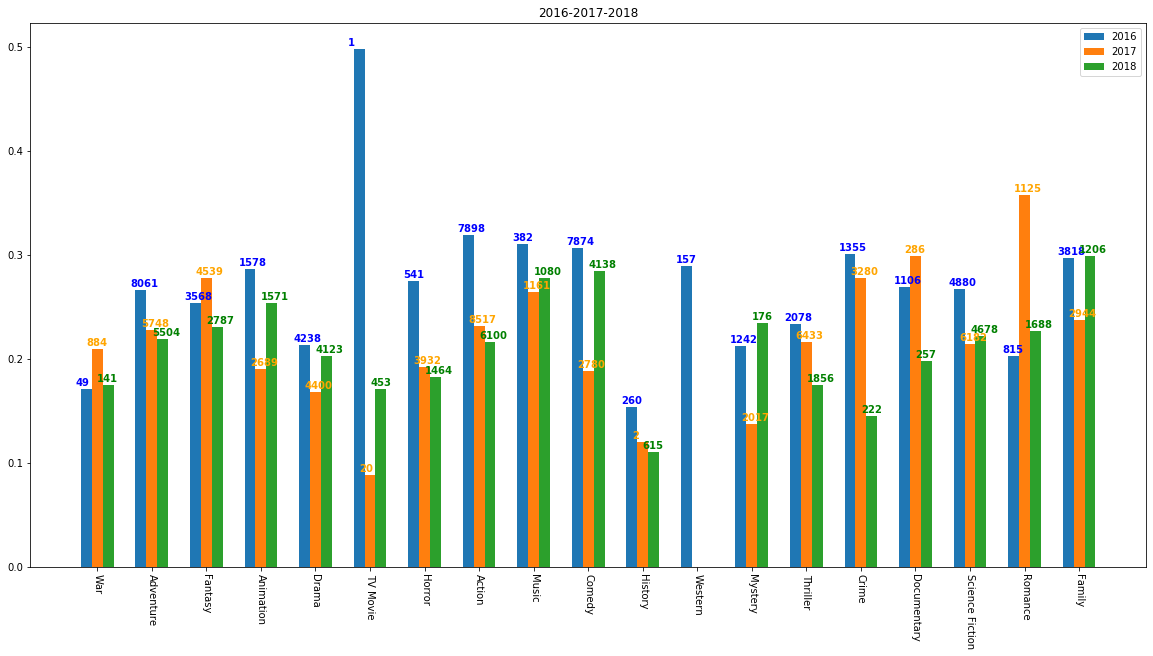

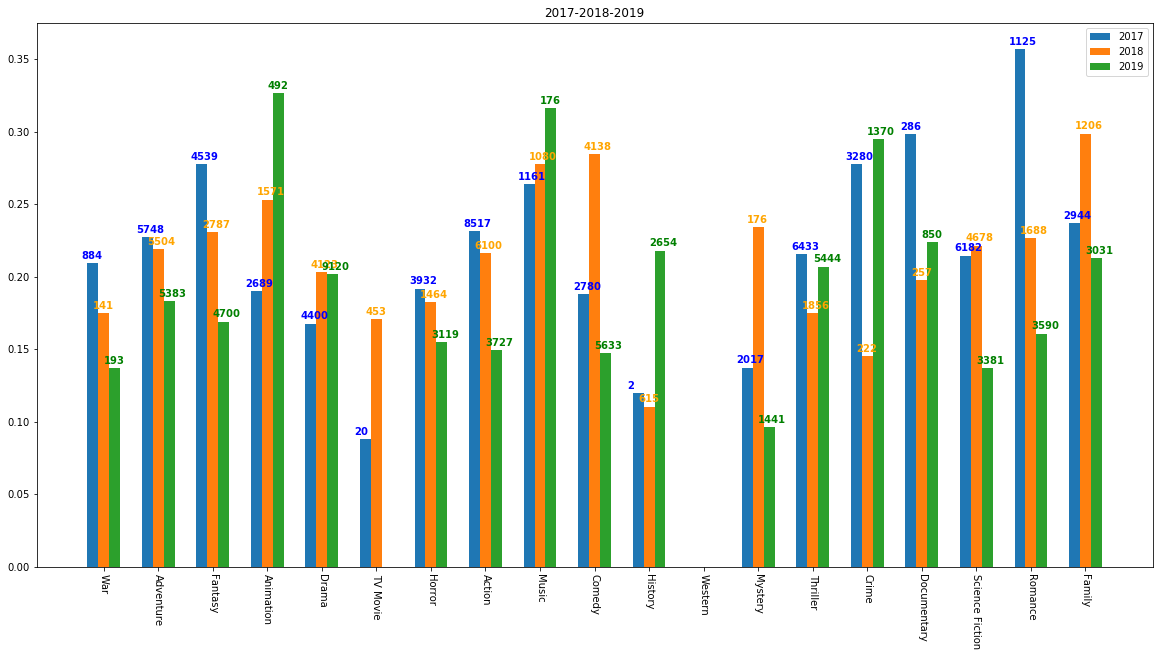

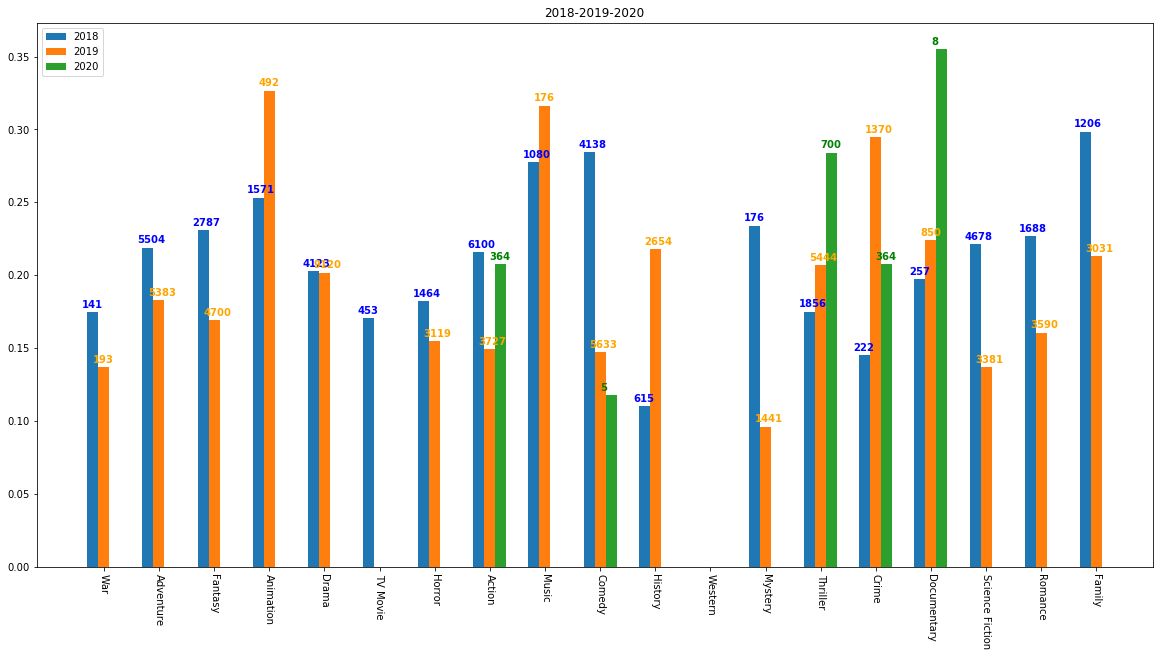

In [180]:
for i in stats_avg:
    if i+2 == 2021: break
    f, ax = plt.subplots(figsize=(20,10))

    plt.bar(np.arange(len(stats_avg[i]))-.2, list(stats_avg[i].values()), width=.2, align='center')
    plt.bar(np.arange(len(stats_avg[i])), list(stats_avg[i+1].values()), width=.2, align='center')
    plt.bar(np.arange(len(stats_avg[i]))+.2, list(stats_avg[i+2].values()), width=.2, align='center')
    plt.xticks(range(len(stats_avg[i])), list(stats_avg[i].keys()), rotation=270)

    for j, (k, v) in enumerate(stats_cnt[i].items()):
        if not np.isfinite(stats_avg[i][k]): continue
        ax.text(j - .4, stats_avg[i][k] + 0.003, str(v), color='blue', fontweight='bold')
    for j, (k, v) in enumerate(stats_cnt[i+1].items()):
        if not np.isfinite(stats_avg[i+1][k]): continue
        ax.text(j - .2, stats_avg[i+1][k] + 0.003, str(v), color='orange', fontweight='bold')
    for j, (k, v) in enumerate(stats_cnt[i+2].items()):
        if not np.isfinite(stats_avg[i+2][k]): continue
        ax.text(j, stats_avg[i+2][k] + 0.003, str(v), color='green', fontweight='bold')
    
    plt.title(str(i)+'-'+str(i+1)+'-'+str(i+2))
    plt.legend((str(i), str(i+1), str(i+2)))

    plt.show()

## Combination of genres

In [181]:
genre_combo = set(tuple(np.sort(i)) for i in all_genres if len(i) > 1)

### Two genre combo

In [182]:
%%time
stats = dict()
for i in genre_combo:
    if len(i) == 2:
        stats[genres[i[0]] + '-' + genres[i[1]]] = week_of_release.loc[
            week_of_release.tmdb_genre_ids.apply(lambda numbers: i[0] in numbers and i[1] in numbers),
            'coverage']

Wall time: 4.76 s


In [183]:
stats_avg = dict()
for i in stats:
    stats_avg[i] = stats[i].mean()

In [184]:
stats_cnt = dict()
for i in stats:
    stats_cnt[i] = stats[i].count()

In [185]:
for i in sorted(stats_cnt.items(), key=lambda kv: kv[1]):
    print(i[1], '\t\t', i[0])

20 		 Romance-TV Movie
22 		 Documentary-War
361 		 History-Documentary
368 		 Drama-Documentary
495 		 Documentary-TV Movie
501 		 Documentary-Music
654 		 Horror-Crime
808 		 Drama-Family
844 		 Action-History
858 		 Comedy-Mystery
1064 		 Fantasy-Music
1120 		 Adventure-History
1172 		 Drama-Music
1338 		 Horror-Comedy
2095 		 Fantasy-Horror
2375 		 Drama-War
2664 		 Comedy-Science Fiction
2968 		 Horror-Mystery
3040 		 Comedy-Crime
3624 		 Drama-History
3914 		 Drama-Crime
4230 		 Drama-Horror
4824 		 Comedy-Romance
5109 		 Drama-Comedy
5547 		 Drama-Romance
6241 		 Adventure-Thriller
6574 		 Horror-Thriller
6755 		 Action-Crime
6860 		 Fantasy-Comedy
7034 		 Thriller-Science Fiction
7121 		 Drama-Science Fiction
7611 		 Thriller-Crime
8162 		 Drama-Action
9327 		 Animation-Family
10278 		 Comedy-Family
10951 		 Action-Comedy
11257 		 Drama-Thriller
11781 		 Adventure-Family
14722 		 Action-Thriller
20590 		 Adventure-Fantasy
29548 		 Action-Science Fiction
33255 		 Adventure-Actio

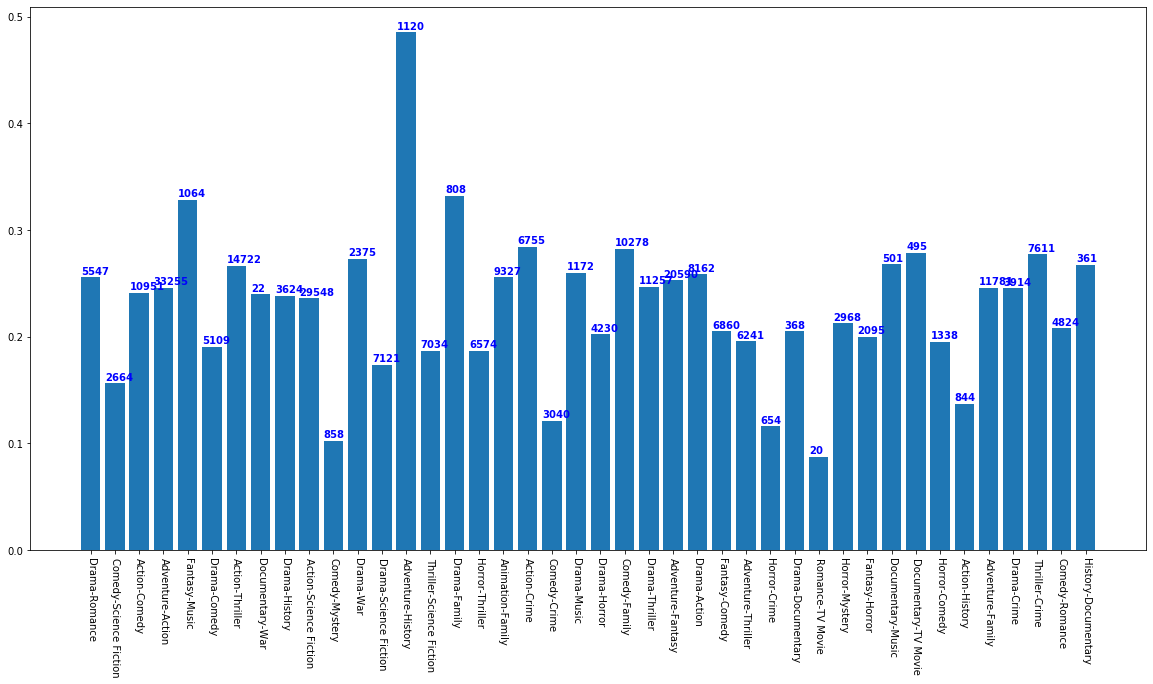

In [186]:
f, ax = plt.subplots(figsize=(20,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=270)

for i, (j, v) in enumerate(stats_cnt.items()):
    ax.text(i - .4, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

### Three genre combo

In [187]:
%%time
stats = dict()
for i in genre_combo:
    if len(i) == 3:
        stats[genres[i[0]] + '-' + genres[i[1]] + '-' + genres[i[2]]] = week_of_release.loc[
            week_of_release.tmdb_genre_ids.apply(lambda numbers: i[0] in numbers and i[1] in numbers and i[2] in numbers),
            'coverage']

Wall time: 8.64 s


In [40]:
stats.keys()

dict_keys(['Adventure-Action-Crime', 'Fantasy-Comedy-Romance', 'Action-Crime-Mystery', 'Drama-Comedy-Crime', 'Fantasy-Action-Thriller', 'Adventure-Action-Thriller', 'Drama-Action-Thriller', 'Fantasy-Music-Romance', 'Comedy-Thriller-Romance', 'Drama-Science Fiction-Romance', 'Drama-Thriller-Romance', 'Drama-Horror-Mystery', 'Fantasy-Animation-Drama', 'Drama-Comedy-Romance', 'Drama-Thriller-War', 'Drama-Science Fiction-War', 'Adventure-Action-Western', 'Drama-Music-Romance', 'Comedy-Crime-Romance', 'Drama-Documentary-Family', 'Drama-Thriller-Crime', 'Action-Science Fiction-Mystery', 'Drama-Action-History', 'Fantasy-Horror-Thriller', 'Drama-Romance-TV Movie', 'Horror-Science Fiction-Mystery', 'Drama-Crime-Documentary', 'Adventure-Comedy-Family', 'Horror-Action-Thriller', 'Comedy-Crime-Mystery', 'Adventure-History-War', 'Drama-Action-Romance', 'Comedy-Romance-Family', 'Horror-Thriller-Crime', 'Animation-Comedy-Science Fiction', 'Comedy-Thriller-Science Fiction', 'Adventure-Horror-Comedy', 

In [192]:
stats_avg = dict()
stats_cnt = dict()
for i in stats:
    if stats[i].count() > 1e+3:
        stats_avg[i] = stats[i].mean()
        stats_cnt[i] = stats[i].count()

In [49]:
for i in sorted(stats_cnt.items(), key=lambda kv: kv[1]):
    print(i[1], '\t\t', i[0])

1035 		 Drama-Crime-Romance
1107 		 Adventure-Horror-Comedy
1156 		 Adventure-Thriller-Romance
1166 		 Adventure-Action-War
1232 		 Adventure-Thriller-Mystery
1243 		 Drama-Romance-Family
1265 		 Comedy-Music-Romance
1276 		 Horror-Comedy-Thriller
1329 		 Drama-Comedy-Music
1352 		 Action-Thriller-Romance
1401 		 Adventure-Drama-Comedy
1406 		 Drama-Science Fiction-Mystery
1407 		 Drama-Comedy-Mystery
1420 		 Animation-Comedy-Science Fiction
1476 		 Horror-Action-Comedy
1543 		 Comedy-Crime-Mystery
1559 		 Adventure-Action-Western
1583 		 Fantasy-Drama-Comedy
1596 		 Fantasy-Drama-Action
1761 		 Action-Science Fiction-Mystery
1896 		 Adventure-Horror-Action
1899 		 Horror-Thriller-Crime
1914 		 Drama-Horror-Science Fiction
2130 		 Adventure-Horror-Thriller
2133 		 Animation-Science Fiction-Family
2207 		 Animation-Drama-Family
2225 		 Adventure-Drama-Romance
2233 		 Fantasy-Horror-Thriller
2275 		 Fantasy-Drama-Horror
2282 		 Fantasy-Action-Thriller
2421 		 Drama-Thriller-Romance
2560 

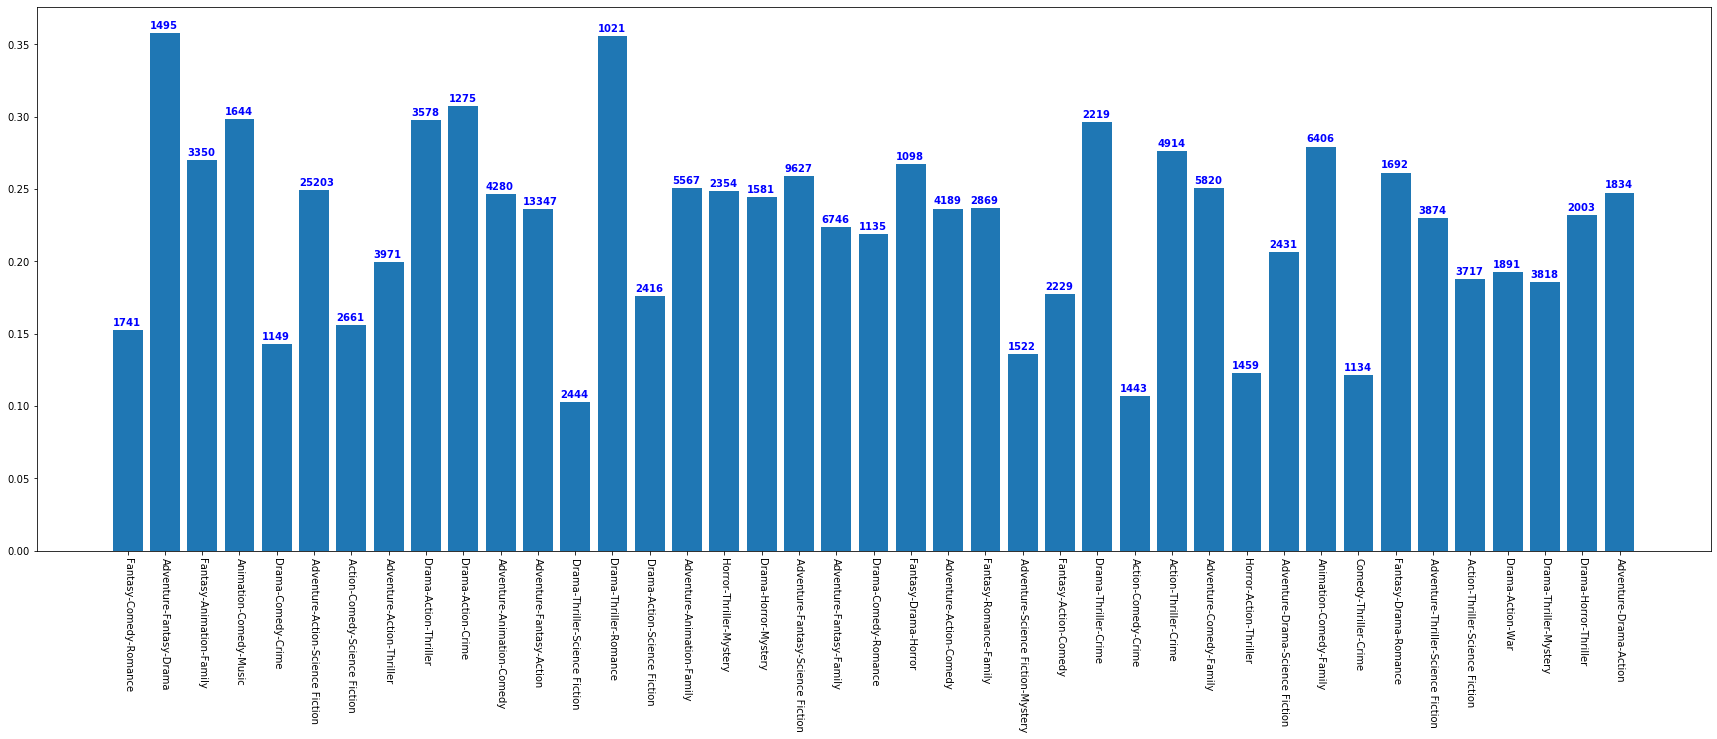

In [193]:
f, ax = plt.subplots(figsize=(30,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=270)

for i, (j, v) in enumerate(stats_cnt.items()):
    ax.text(i - .4, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

## Four genre combo

In [194]:
%%time
stats = dict()
for i in genre_combo:
    if len(i) == 4:
        stats[genres[i[0]] + '-' + genres[i[1]] + '-' + genres[i[2]] + '-' + genres[i[3]]] = week_of_release.loc[
            week_of_release.tmdb_genre_ids.apply(lambda numbers: i[0] in numbers and i[1] in numbers and i[2] in numbers and i[3] in numbers),
            'coverage']

Wall time: 5.19 s


In [198]:
stats_avg = dict()
stats_cnt = dict()
for i in stats:
    if stats[i].count() > 1e+2:
        stats_avg[i] = stats[i].mean()
        stats_cnt[i] = stats[i].count()

In [199]:
for i in sorted(stats_cnt.items(), key=lambda kv: kv[1]):
    print(i[1], '\t\t', i[0])

124 		 Adventure-Action-Crime-Mystery
156 		 Adventure-Fantasy-Drama-Comedy
166 		 Drama-Action-Thriller-War
229 		 Fantasy-Drama-Mystery-Romance
250 		 Drama-Action-History-War
288 		 Horror-Comedy-Thriller-Mystery
289 		 Animation-Drama-Comedy-Family
403 		 Adventure-Animation-Action-Science Fiction
409 		 Drama-Thriller-Crime-Mystery
416 		 Drama-Comedy-Crime-Mystery
453 		 Horror-Action-Science Fiction-TV Movie
455 		 Adventure-Fantasy-Drama-Family
517 		 Adventure-Action-Science Fiction-Mystery
587 		 Drama-Horror-Action-Thriller
686 		 Adventure-Fantasy-Drama-Romance
714 		 Drama-Action-Thriller-Science Fiction
880 		 Fantasy-Horror-Action-Thriller
901 		 Adventure-Drama-Action-Science Fiction
944 		 Action-Comedy-Thriller-Crime
960 		 Adventure-Animation-Action-Family
973 		 Drama-Action-Thriller-Crime
1017 		 Adventure-Fantasy-Action-Romance
1293 		 Drama-Horror-Thriller-Mystery
1529 		 Adventure-Fantasy-Action-Comedy
1695 		 Adventure-Fantasy-Animation-Family
1984 		 Adventure

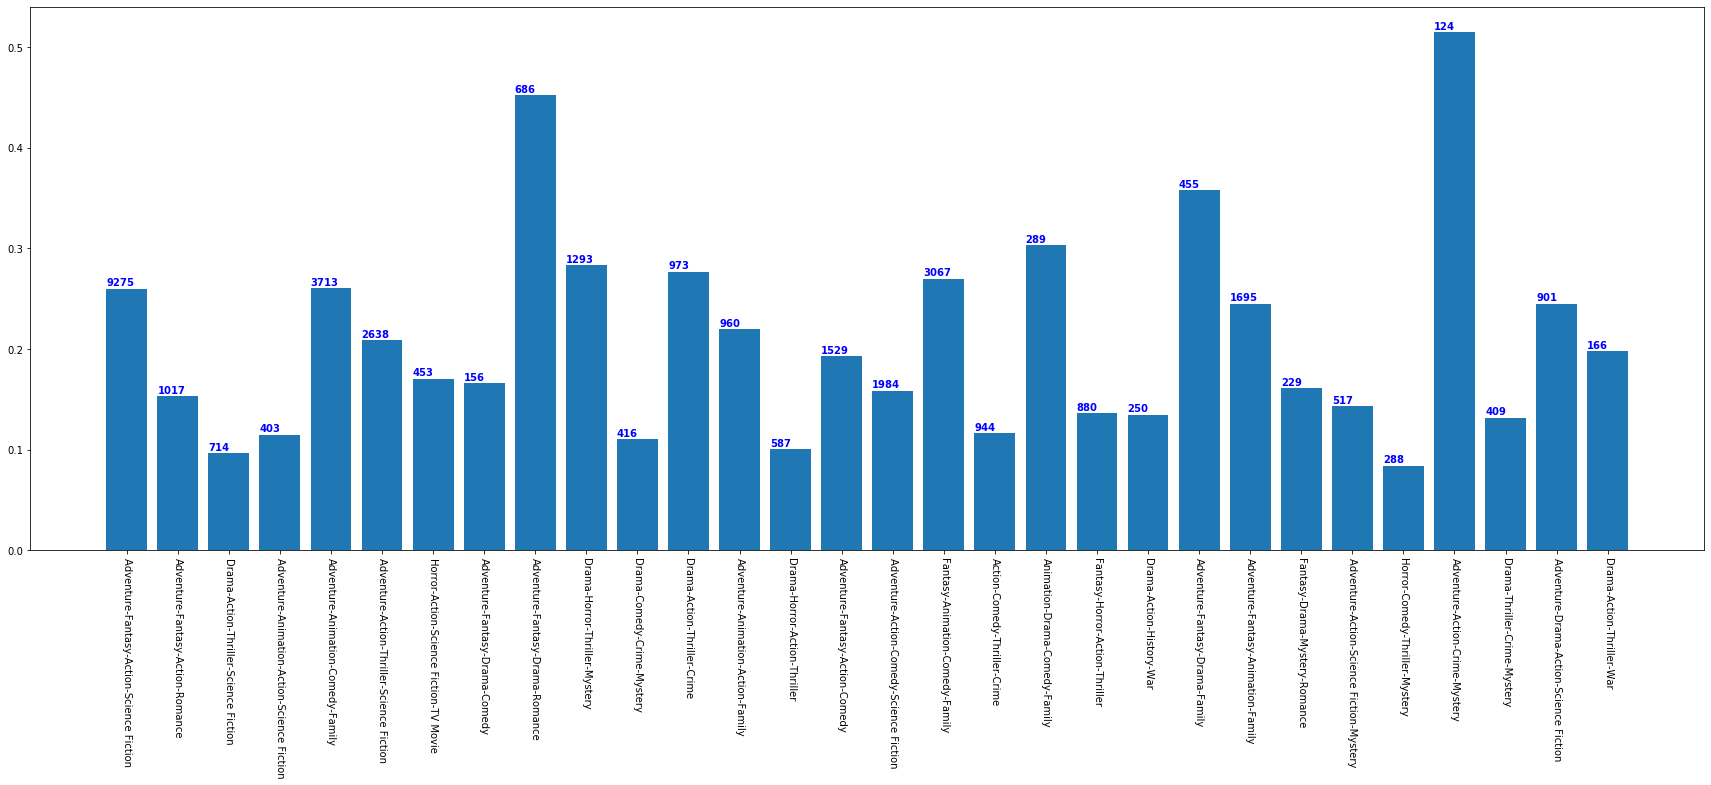

In [200]:
f, ax = plt.subplots(figsize=(30,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=270)

for i, (j, v) in enumerate(stats_cnt.items()):
    ax.text(i - .4, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

## Coverage by TMDb score

In [201]:
scores = week_of_release.tmdb_vote_average.unique()
scores.sort()

In [202]:
%%time
stats = dict()
for i in scores:
    stats[i] = week_of_release.loc[week_of_release.tmdb_vote_average == i, 'coverage']

Wall time: 38 ms


In [208]:
stats_avg = dict()
stats_cnt = dict()
for i in stats:
    if stats[i].count() > 100:
        stats_avg[i] = stats[i].mean()
        stats_cnt[i] = stats[i].count()

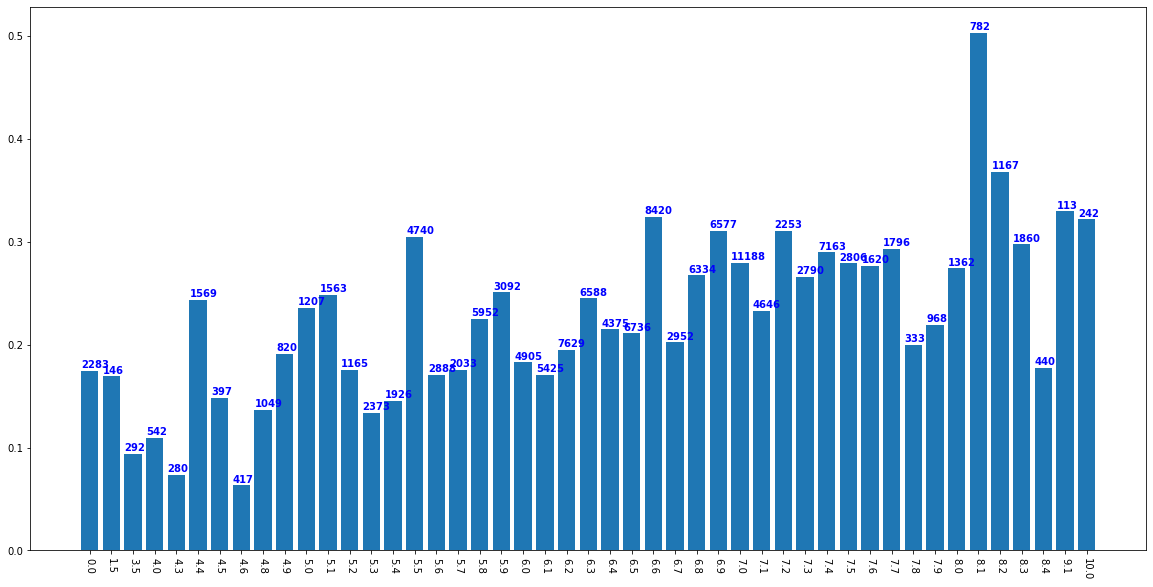

In [209]:
f, ax = plt.subplots(figsize=(20,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=270)

for i, (j, v) in enumerate(stats_cnt.items()):
    ax.text(i - .4, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

## Coverage by TMDb popularity

In [210]:
popularity = list(set(week_of_release.tmdb_popularity.unique().round()))
popularity.sort()

In [211]:
%%time
stats = dict()
for i in popularity:
    stats[i] = week_of_release.loc[week_of_release.tmdb_popularity.round() == i, 'coverage']

Wall time: 447 ms


In [213]:
stats_avg = dict()
stats_cnt = dict()
for i in stats:
    stats_avg[i] = stats[i].mean()
    stats_cnt[i] = stats[i].count()

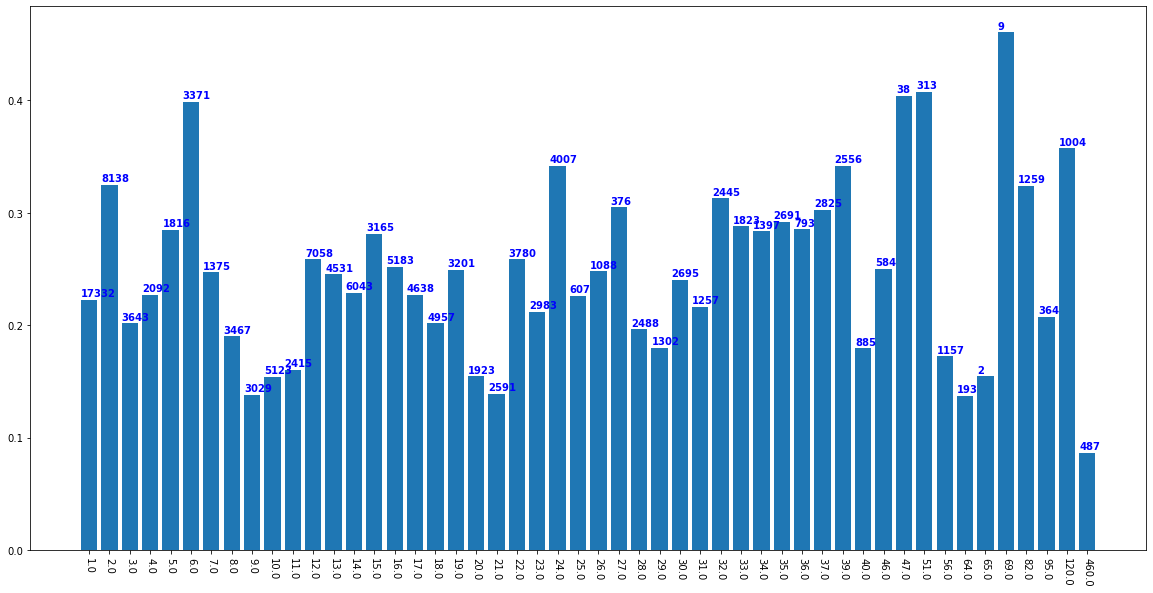

In [214]:
f, ax = plt.subplots(figsize=(20,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=270)

for i, (j, v) in enumerate(stats_cnt.items()):
    ax.text(i - .4, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

## Coverage by runtime

In [233]:
def custom_round(x, base=5):
    return int(base * round(float(x)/base))

In [250]:
runtime = list(set(week_of_release.tmdb_runtime.unique().round()))
runtime.sort()

In [261]:
%%time
stats = dict()
for i in runtime:
    if np.isfinite(i):
        j = custom_round(i, base=20)
        if j not in stats:
            stats[j] = week_of_release.loc[week_of_release.tmdb_runtime.round() == i, 'coverage']
        else:
            stats[j].append(week_of_release.loc[week_of_release.tmdb_runtime.round() == i, 'coverage'])

Wall time: 792 ms


In [262]:
stats_avg = dict()
stats_cnt = dict()
for i in stats:
    if stats[i].count() > 0:
        stats_avg[i] = stats[i].mean()
        stats_cnt[i] = stats[i].count()

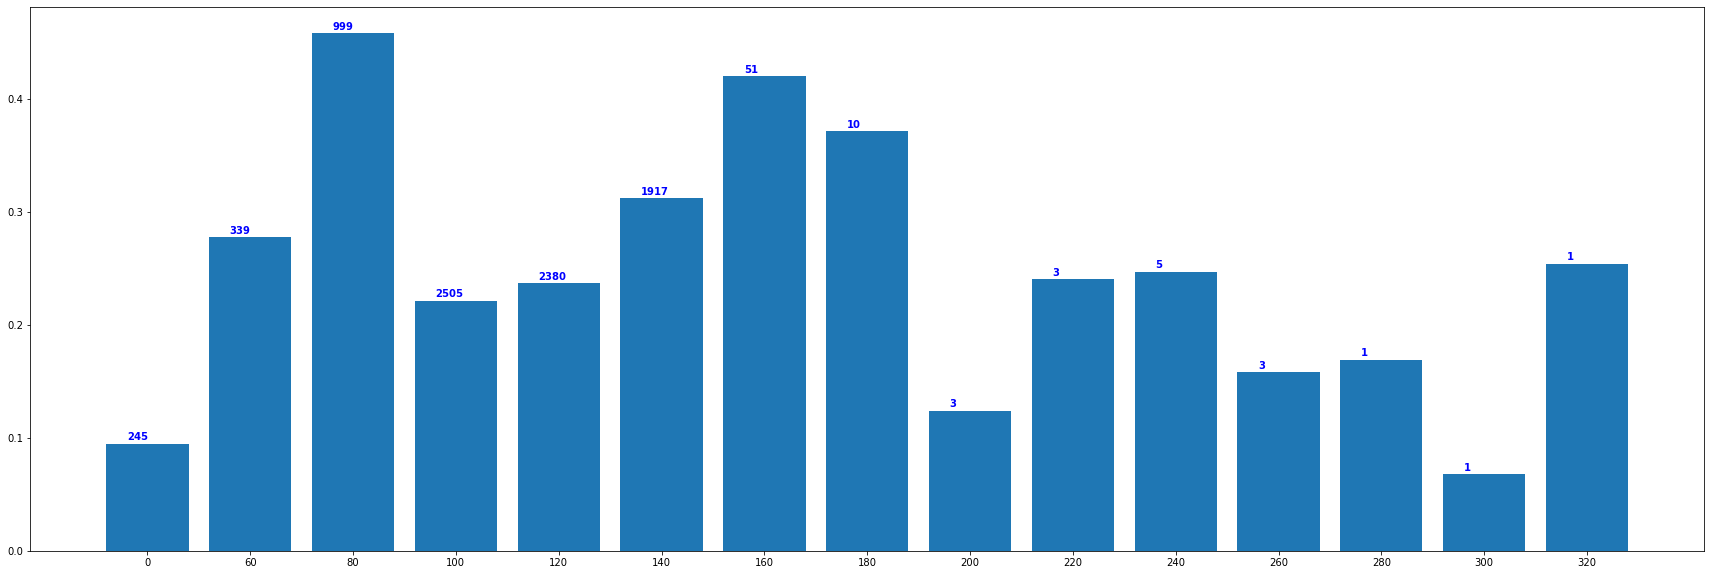

In [263]:
f, ax = plt.subplots(figsize=(30,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(stats_avg.keys()), rotation=0)

for i, (j, v) in enumerate(stats_cnt.items()):
    if not np.isfinite(stats_avg[j]): continue
    ax.text(i-.2, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

## Coverage by revenue

In [264]:
revenue = list(set(week_of_release.tmdb_revenue.unique().round()))
revenue.sort()

In [280]:
%%time
stats = dict()
for i in revenue:
    if np.isfinite(i):
        j = custom_round(i, base=1e+8)
        if j not in stats:
            stats[j] = week_of_release.loc[week_of_release.tmdb_revenue.round() == i, 'coverage']
        else:
            stats[j].append(week_of_release.loc[week_of_release.tmdb_revenue.round() == i, 'coverage'])

Wall time: 1.44 s


In [281]:
stats_avg = dict()
stats_cnt = dict()
for i in stats:
    if stats[i].count() > 0:
        stats_avg[i] = stats[i].mean()
        stats_cnt[i] = stats[i].count()

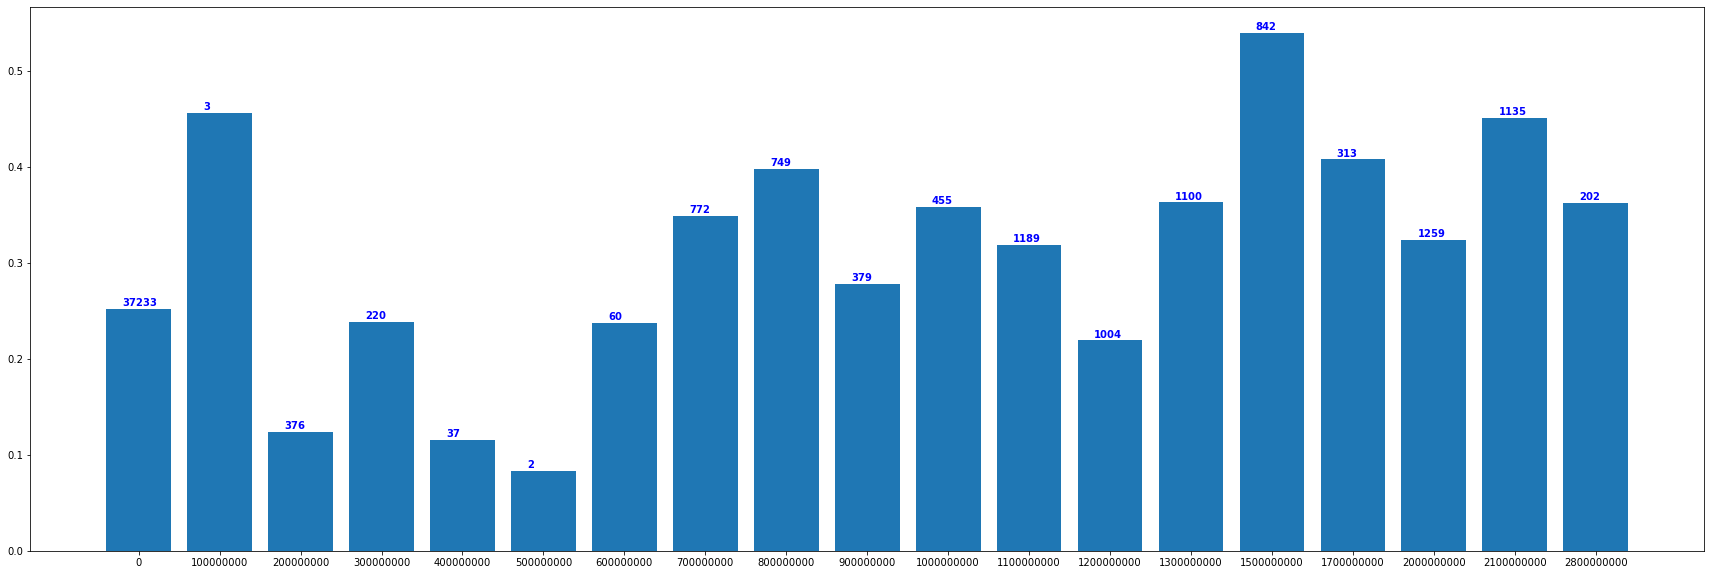

In [293]:
f, ax = plt.subplots(figsize=(30,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(map(int, stats_avg.keys())), rotation=0)

for i, (j, v) in enumerate(stats_cnt.items()):
    if not np.isfinite(stats_avg[j]): continue
    ax.text(i-.2, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

## Coverage by budget

In [296]:
budget = list(set(week_of_release.tmdb_budget.unique().round()))
budget.sort()

In [310]:
%%time
stats = dict()
for i in budget:
    if np.isfinite(i):
        j = custom_round(i, base=2e+7)
        if j not in stats:
            stats[j] = week_of_release.loc[week_of_release.tmdb_budget.round() == i, 'coverage']
        else:
            stats[j].append(week_of_release.loc[week_of_release.tmdb_budget.round() == i, 'coverage'])

Wall time: 600 ms


In [311]:
stats_avg = dict()
stats_cnt = dict()
for i in stats:
    if stats[i].count() > 0:
        stats_avg[i] = stats[i].mean()
        stats_cnt[i] = stats[i].count()

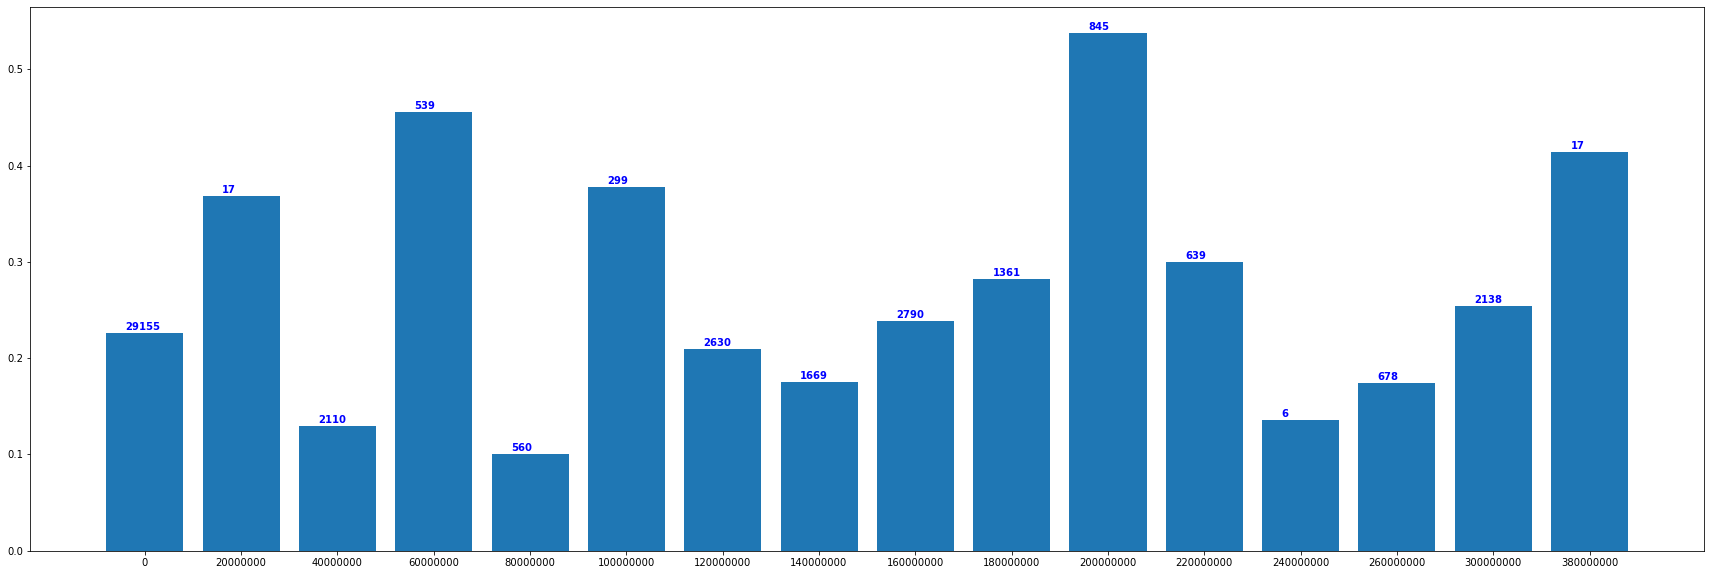

In [312]:
f, ax = plt.subplots(figsize=(30,10))

plt.bar(range(len(stats_avg)), list(stats_avg.values()), align='center')
plt.xticks(range(len(stats_avg)), list(map(int, stats_avg.keys())), rotation=0)

for i, (j, v) in enumerate(stats_cnt.items()):
    if not np.isfinite(stats_avg[j]): continue
    ax.text(i-.2, stats_avg[j] + 0.003, str(v), color='blue', fontweight='bold')

plt.show()

## Correlation

In [315]:
week_of_release.corr()

arr_nr     seats      room  coverage   seats_b      sold  \
arr_nr             1.000000 -0.033694  0.209064  0.042028 -0.041908  0.041522   
seats             -0.033694  1.000000 -0.064232 -0.255424  0.987265  0.303416   
room               0.209064 -0.064232  1.000000 -0.005441 -0.078617 -0.066004   
coverage           0.042028 -0.255424 -0.005441  1.000000 -0.252890  0.671859   
seats_b           -0.041908  0.987265 -0.078617 -0.252890  1.000000  0.312835   
sold               0.041522  0.303416 -0.066004  0.671859  0.312835  1.000000   
tmdb_popularity    0.040775  0.037380  0.025633 -0.005004  0.037829  0.013064   
tmdb_vote_average  0.020497  0.053521  0.017090  0.124144  0.054802  0.139333   
tmdb_vote_count   -0.053745  0.118451 -0.017146  0.120387  0.123126  0.167769   
tmdb_id            0.241465 -0.138237  0.111377 -0.082799 -0.147063 -0.134564   
tmdb_runtime      -0.015133  0.086479  0.025226  0.058179  0.089236  0.102048   
tmdb_budget       -0.051494  0.124750 -0.018838  0.049178  0.129899  0.100392   
tmdb_revenue      -0.025498  0.114610 -0.003975  0.183999  0.118749  0.231640   

                   tmdb_popularity  tmdb_vote_average  tmdb_vote_count  \
arr_nr                    0.040775           0.020497        -0.053745   
seats                     0.037380           0.053521         0.118451   
room                      0.025633           0.017090        -0.017146   
coverage                 -0.005004           0.124144         0.120387   
seats_b                   0.037829           0.054802         0.123126   
sold                      0.013064           0.139333         0.167769   
tmdb_popularity           1.000000           0.210081         0.304335   
tmdb_vote_average         0.210081           1.000000         0.445231   
tmdb_vote_count           0.304335           0.445231         1.000000   
tmdb_id                   0.037758          -0.041228        -0.283679   
tmdb_runtime              0.282129           0.487118         0.553342   
tmdb_budget               0.279203           0.315161         0.716814   
tmdb_revenue              0.307291           0.400781         0.804392   

                    tmdb_id  tmdb_runtime  tmdb_budget  tmdb_revenue  
arr_nr             0.241465     -0.015133    -0.051494     -0.025498  
seats             -0.138237      0.086479     0.124750      0.114610  
room               0.111377      0.025226    -0.018838     -0.003975  
coverage          -0.082799      0.058179     0.049178      0.183999  
seats_b           -0.147063      0.089236     0.129899      0.118749  
sold              -0.134564      0.102048     0.100392      0.231640  
tmdb_popularity    0.037758      0.282129     0.279203      0.307291  
tmdb_vote_average -0.041228      0.487118     0.315161      0.400781  
tmdb_vote_count   -0.283679      0.553342     0.716814      0.804392  
tmdb_id            1.000000     -0.217578    -0.365340     -0.230340  
tmdb_runtime      -0.217578      1.000000     0.585384      0.513100  
tmdb_budget       -0.365340      0.585384     1.000000      0.781982  
tmdb_revenue      -0.230340      0.513100     0.781982      1.000000

In [316]:
showings.corr()

arr_nr     seats      room  coverage   seats_b      sold  \
arr_nr             1.000000 -0.110429  0.201335  0.071502 -0.120577  0.022114   
seats             -0.110429  1.000000 -0.049819 -0.265651  0.989160  0.287415   
room               0.201335 -0.049819  1.000000 -0.004016 -0.059976 -0.042996   
coverage           0.071502 -0.265651 -0.004016  1.000000 -0.265634  0.640431   
seats_b           -0.120577  0.989160 -0.059976 -0.265634  1.000000  0.293011   
sold               0.022114  0.287415 -0.042996  0.640431  0.293011  1.000000   
tmdb_popularity    0.055297  0.041074  0.029958  0.003927  0.041805  0.024053   
tmdb_vote_average  0.002665  0.014183  0.003356  0.043258  0.015039  0.048280   
tmdb_vote_count   -0.043671  0.099928 -0.004761  0.079383  0.104028  0.122783   
tmdb_id            0.283294 -0.095355  0.111942 -0.030516 -0.102275 -0.057988   
tmdb_runtime      -0.017448  0.038477  0.007466  0.007208  0.039838  0.035178   
tmdb_budget       -0.050691  0.132874 -0.006987  0.043784  0.138030  0.104482   
tmdb_revenue      -0.007312  0.115097  0.009476  0.122559  0.119015  0.180657   

                   tmdb_popularity  tmdb_vote_average  tmdb_vote_count  \
arr_nr                    0.055297           0.002665        -0.043671   
seats                     0.041074           0.014183         0.099928   
room                      0.029958           0.003356        -0.004761   
coverage                  0.003927           0.043258         0.079383   
seats_b                   0.041805           0.015039         0.104028   
sold                      0.024053           0.048280         0.122783   
tmdb_popularity           1.000000           0.247177         0.380221   
tmdb_vote_average         0.247177           1.000000         0.371816   
tmdb_vote_count           0.380221           0.371816         1.000000   
tmdb_id                   0.058962          -0.132775        -0.243254   
tmdb_runtime              0.315751           0.447657         0.474320   
tmdb_budget               0.341876           0.261885         0.666733   
tmdb_revenue              0.375106           0.301939         0.773048   

                    tmdb_id  tmdb_runtime  tmdb_budget  tmdb_revenue  
arr_nr             0.283294     -0.017448    -0.050691     -0.007312  
seats             -0.095355      0.038477     0.132874      0.115097  
room               0.111942      0.007466    -0.006987      0.009476  
coverage          -0.030516      0.007208     0.043784      0.122559  
seats_b           -0.102275      0.039838     0.138030      0.119015  
sold              -0.057988      0.035178     0.104482      0.180657  
tmdb_popularity    0.058962      0.315751     0.341876      0.375106  
tmdb_vote_average -0.132775      0.447657     0.261885      0.301939  
tmdb_vote_count   -0.243254      0.474320     0.666733      0.773048  
tmdb_id            1.000000     -0.216196    -0.313046     -0.185914  
tmdb_runtime      -0.216196      1.000000     0.440983      0.388779  
tmdb_budget       -0.313046      0.440983     1.000000      0.758999  
tmdb_revenue      -0.185914      0.388779     0.758999      1.000000

# Decision trees

In [319]:
showings.columns

Index(['arr_nr', 'showtime', 'seats', 'room', 'std_movienr', 'full_title',
       'coverage', 'seats_b', 'sold', 'stripped_title', 'tmdb_genre_ids',
       'tmdb_original_language', 'tmdb_original_title', 'tmdb_overview',
       'tmdb_popularity', 'tmdb_release_date', 'tmdb_title',
       'tmdb_vote_average', 'tmdb_vote_count', 'tmdb_id', 'tmdb_runtime',
       'tmdb_budget', 'tmdb_production_companies', 'tmdb_revenue',
       'tmdb_tagline', 'tmdb_cast', 'tmdb_crew', 'tmdb_keywords', 'imdb_id'],
      dtype='object')

In [405]:
X = showings.sort_values(by=['showtime']).loc[
    showings.showtime.dt.strftime('%Y').between('2007', '2018'),
    ('seats', 'tmdb_popularity',
     'tmdb_vote_average', 'tmdb_vote_count', 'tmdb_runtime', 'tmdb_budget', 'tmdb_revenue')
].fillna(0)
y = showings.sort_values(by=['showtime']).loc[
    showings.showtime.dt.strftime('%Y').between('2007', '2018'),
    ('coverage')
]

In [404]:
testX = showings.sort_values(by=['showtime']).loc[
    showings.showtime.dt.strftime('%Y').between('2019', '2019'),
    ('seats', 'tmdb_popularity',
     'tmdb_vote_average', 'tmdb_vote_count', 'tmdb_runtime', 'tmdb_budget', 'tmdb_revenue')
].fillna(0)
testY = showings.sort_values(by=['showtime']).loc[
    showings.showtime.dt.strftime('%Y').between('2019', '2019'),
    ('coverage')
]

In [416]:
model = DecisionTreeRegressor(max_depth=3)
model.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [417]:
pred = model.predict(testX)

In [420]:
round(mean_squared_error(testY, pred), 4)

0.039

In [421]:
round(mean_squared_error(testY, pred, squared=False), 4)

0.1975

In [422]:
X.columns

Index(['seats', 'tmdb_popularity', 'tmdb_vote_average', 'tmdb_vote_count',
       'tmdb_runtime', 'tmdb_budget', 'tmdb_revenue'],
      dtype='object')

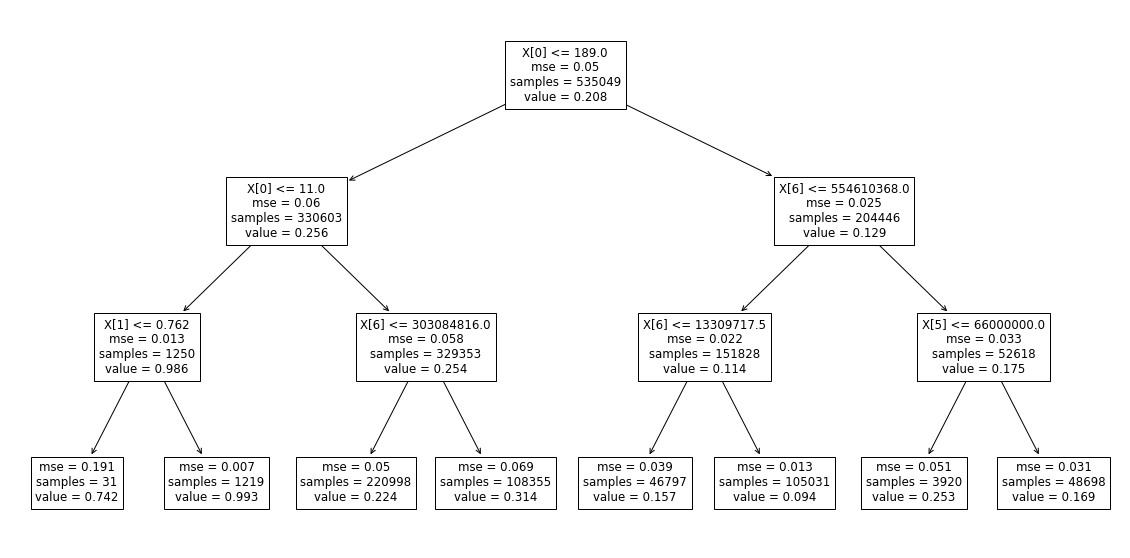

In [424]:
fig, ax = plt.subplots(figsize=(20, 10))  # whatever size you want
tree.plot_tree(model, max_depth=4, ax=ax)
plt.show()

# Clustering

In [438]:
y = list(y)

In [459]:
y_pred = KMeans(n_clusters=100, random_state=170).fit_predict(X)

In [460]:
stats = dict()
for i, v in enumerate(y_pred):
    if v not in stats:
        stats[v] = [y[i]]
    else:
        stats[v].append(y[i])
stats_avg = dict()
for i, v in stats.items():
    stats_avg[i] = np.mean(v)
pred = list()
for i in y_pred:
    pred.append(stats_avg[i])

In [461]:
round(mean_squared_error(y, pred), 4)

0.0476

In [454]:
y[4029:4039]

[0.06289308176100601,
 0.016393442622950002,
 0.022727272727272003,
 0.059701492537313,
 0.49038461538461503,
 0.15686274509803902,
 0.15686274509803902,
 0.644067796610169,
 0.42142857142857104,
 0.42142857142857104]

In [462]:
pred[4029:4039]

[0.1439808259644041,
 0.1439808259644041,
 0.2956096148491776,
 0.1439808259644041,
 0.2153515201976306,
 0.2153515201976306,
 0.2153515201976306,
 0.2153515201976306,
 0.2153515201976306,
 0.2153515201976306]